# Initial

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import * 
import time
import seaborn as sns
import random
from gymnasium import Env, spaces

In [7]:
def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    
    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
            
    return points

class Agent:
    def __init__(self, field_height, field_width, pos=None):
        self.field_height = field_height
        self.field_width = field_width
        self.action_space = spaces.Discrete(10)  # 8 moves + pass + stay still
        self.pos = pos
        self.position = np.array(pos) if pos is not None else np.array([
            np.random.randint(0, field_height),
            np.random.randint(0, field_width)
        ])
        self.pass_speed = 4
        self.pass_speed_decay = 1

    def policy(self, state, epsilon):
        if np.random.uniform(0, 1) < epsilon:
            return self.action_space.sample()
        else:
            return np.argmax(self.q_table[state, :])

    def reset_position(self):
        if self.pos is None:
            self.position = np.array([
                np.random.randint(0, self.field_height),
                np.random.randint(0, self.field_width)
            ])
        return self.position

    def pass_ball(self, current_position, target_position):
        """
        Calculate ball trajectory using Bresenham's line algorithm.
        
        :param current_position: Current ball position (x, y)
        :param target_position: Target position for pass (x, y)
        :return: ball trajectory points, initial speed, and direction vector
        """
        # Convert positions to integers for Bresenham algorithm
        start_x, start_y = int(current_position[0]), int(current_position[1])
        target_x, target_y = int(target_position[0]), int(target_position[1])
        
        # Calculate trajectory points using Bresenham's algorithm
        trajectory_points = bresenham_line(start_x, start_y, target_x, target_y)
        
        # Skip the first point (current position)
        if len(trajectory_points) > 1:
            trajectory_points = trajectory_points[1:]
        
        # Calculate direction vector (normalized)
        direction = np.array([target_position[0] - current_position[0], 
                             target_position[1] - current_position[1]])
        direction_norm = np.linalg.norm(direction)
        
        if direction_norm > 0:
            direction = direction / direction_norm
        else:
            direction = np.array([0, 0])
        
        return trajectory_points, self.pass_speed, direction

class FootballEnv(Env):
    def __init__(self, field_height, field_width, agents):
        super(FootballEnv, self).__init__()

        self.field_height = field_height  # x-axis (rows)
        self.field_width = field_width  # y-axis (columns)
        self.goal_y = self.field_width - 1  # Goal at the far right (y-axis)

        # Observation Space: (player_x, player_y, ball_x, ball_y)
        self.observation_space = spaces.Discrete(field_height * field_width)

        self.field = np.full((self.field_height, self.field_width), '.', dtype=str)
        self.rewards = np.full((self.field_height, self.field_width), -1, dtype=np.float32)
        
        # Goal area has a higher reward
        # self.rewards[:, self.goal_y] = 10.0  

        self.ball_holder = None  # None: no one has the ball, 0: agent1, 1: agent2
        self.agents = agents
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0

        for agent in self.agents:
            agent.q_table = np.zeros((self.observation_space.n, agent.action_space.n))

        self.reset()

    def reset(self, seed=None, options=None):
        self.agents_positions = [agent.reset_position() for agent in self.agents]
        # self.ball_pos = np.array([np.random.randint(0, self.field_height), np.random.randint(0, self.field_width)]  # (x, y) format
        self.ball_pos = np.array([self.field_height // 2, self.field_width // 2])  # Center of the field
        self.ball_holder = None
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0
        self.done = False
        return self._get_agents_positions(), self.ball_pos, self.ball_holder

    def _get_agents_positions(self):
        return [pos[0] * self.field_width + pos[1] for pos in self.agents_positions]
    
    def closest_pass(self):
        # find the agent closest to the ball holder
        ball_holder_pos = self.agents_positions[self.ball_holder]
        distances = [np.linalg.norm(agent.position - ball_holder_pos) for agent in self.agents]
        # find agent closest to the ball other than the ball holder
        closest_agent = np.argmin([distances[i] if (i != self.ball_holder and distances[i] >= 3) else np.inf for i in range(len(distances))])
        # print(f'Agent {closest_agent+1} is closest to the ball holder')
        return closest_agent

    
    def step(self, actions):
        rewards = [0] * len(self.agents)  # Initialize rewards

        # Define movement mapping for 8 directions
        move_map = {
            0: np.array([0, 1]),   # Right
            1: np.array([1, 1]),   # Down-Right
            2: np.array([1, 0]),   # Down
            3: np.array([1, -1]),  # Down-Left
            4: np.array([0, -1]),  # Left
            5: np.array([-1, -1]), # Up-Left
            6: np.array([-1, 0]),  # Up
            7: np.array([-1, 1])   # Up-Right
        }

        # Ball in transit logic
        if self.ball_in_transit and self.ball_trajectory:
            steps_to_move = min(self.ball_transit_speed, len(self.ball_trajectory) - self.ball_trajectory_index)

            for _ in range(steps_to_move):
                if self.ball_trajectory_index < len(self.ball_trajectory):
                    next_x, next_y = self.ball_trajectory[self.ball_trajectory_index]
                    self.ball_pos = np.array([next_x, next_y])
                    self.ball_trajectory_index += 1

                    # Check if any agent receives the ball
                    for i, agent in enumerate(self.agents):
                        if np.array_equal(agent.position, self.ball_pos):
                            self.ball_holder = i
                            self.ball_in_transit = False
                            rewards[i] += 20  # Reward for receiving a pass
                            rewards[self.last_passer] += 500  # Reward for successful pass
                            # print(f'Agent {i+1} received the ball successfully! (Passer: Agent {self.last_passer+1})')

                            # End episode if the pass reaches the target
                            self.done = True
                            return (self._get_agents_positions(), self.ball_pos, self.ball_holder), rewards, self.done, {}

                else:
                    self.ball_in_transit = False
                    break

            # Apply speed decay
            self.ball_transit_speed = max(0, self.ball_transit_speed - self.agents[0].pass_speed_decay)

            if self.ball_transit_speed == 0 or self.ball_trajectory_index >= len(self.ball_trajectory):
                self.ball_in_transit = False
                # print('Ball stopped in transit')

        # Agent movements and actions
        for i, action in enumerate(actions):
            agent = self.agents[i]
            
            # Current position before movement
            old_position = agent.position.copy()

            if action in move_map:
                new_position = agent.position + move_map[action]
                new_position[0] = np.clip(new_position[0], 0, self.field_height - 1)
                new_position[1] = np.clip(new_position[1], 0, self.field_width - 1)
                agent.position = new_position
                self.agents_positions[i] = new_position

                # If this agent is holding the ball, update ball position
                if self.ball_holder == i and not self.ball_in_transit:
                    self.ball_pos = new_position.copy()
                    # print(f'Agent {i+1} moved with the ball')

                # If agent moves to a position with the ball on the field
                if not self.ball_in_transit and np.array_equal(agent.position, self.ball_pos) and self.ball_holder is None:
                    self.ball_holder = i
                    rewards[i] += 20  # Picking up the ball
                    # print(f'Agent {i+1} picked up the ball')

            elif action == 8:  # Passing
                if self.ball_holder == i and not self.ball_in_transit:
                    closest_pass = self.closest_pass()
                    target_agent_index = closest_pass
                    target_position = self.agents[target_agent_index].position
                    trajectory_points, pass_speed, pass_direction = agent.pass_ball(self.ball_pos, target_position)

                    self.ball_trajectory = [(int(x), int(y)) for x, y in trajectory_points]
                    self.ball_trajectory_index = 0

                    self.ball_in_transit = True
                    self.ball_transit_speed = pass_speed
                    self.ball_transit_direction = pass_direction
                    self.last_passer = i  # Store who made the pass
                    self.ball_holder = None
                    # print(f'Ball passed by Agent {i+1} → Target: Agent {target_agent_index+1}')

            elif action == 9:  # Stay still
                pass  # Do nothing

        return (self._get_agents_positions(), self.ball_pos, self.ball_holder), rewards, self.done, {}



    def train(self, episodes, max_steps, epsilon, gamma, alpha, print_frequency=1000):
        for episode in range(episodes):
            states, ball_pos, ball_holder = self.reset()
            total_rewards = [0] * len(self.agents)
            done = False
            steps = 0
            target_agent_index = None  # Track which agent is the target of a pass
            
            # Initial action selection based on policy
            actions = [agent.policy(states[i], epsilon) for i, agent in enumerate(self.agents)]
    
            while not done and steps < max_steps:
                # If ball is in transit, set target agent to stay still but let others move
                if self.ball_in_transit and target_agent_index is not None:
                    # Only force the target agent to stay still
                    actions[target_agent_index] = 9
                    
                    # Let other agents move normally based on their policy
                    for i in range(len(self.agents)):
                        if i != target_agent_index:
                            # Keep the actions that were already selected for non-target agents
                            pass
                
                # Take step with current actions
                (next_states, next_ball_pos, next_ball_holder), rewards, done, _ = self.step(actions)
                
                # If ball was passed in this step, update target_agent_index
                if not self.ball_in_transit and target_agent_index is not None:
                    # Reset target agent since ball is no longer in transit
                    target_agent_index = None
                
                # If a pass action was taken in this step, identify the target agent
                for i, action in enumerate(actions):
                    if action == 8 and self.ball_holder == i:  # Agent attempted to pass
                        # The closest_pass method is called within the step function
                        # We need to capture who will be the target before the next actions
                        target_agent_index = self.closest_pass()
                        break
                
                # Determine next actions based on new state
                next_actions = [agent.policy(next_states[i], epsilon) for i, agent in enumerate(self.agents)]
                
                # If ball is in transit, force target agent to stay still in next actions
                if self.ball_in_transit and target_agent_index is not None:
                    next_actions[target_agent_index] = 9
                
                # SARSA update
                for i, agent in enumerate(self.agents):
                    agent.q_table[states[i], actions[i]] += alpha * (
                        rewards[i] + gamma * agent.q_table[next_states[i], next_actions[i]] - agent.q_table[states[i], actions[i]]
                    )
                    total_rewards[i] += rewards[i]
    
                states = next_states
                actions = next_actions
                steps += 1
                # self.render()
    
            # Print only at specified frequency or at the final episode
            if (episode + 1) % print_frequency == 0 or episode == episodes - 1:
                print(f"Episode {episode + 1}/{episodes}, Total Rewards: {total_rewards}, Steps: {steps}")

    def render(self):
        field_copy = np.full((self.field_height, self.field_width), '.', dtype=str)
        
        # First, place the ball (if it's not held by an agent)
        if self.ball_holder is None:
            field_copy[self.ball_pos[0], self.ball_pos[1]] = 'B'  # (x, y) indexing
        
        # Place agents (will overwrite ball if they're in the same position)
        for i, pos in enumerate(self.agents_positions):
            field_copy[pos[0], pos[1]] = str(i + 1)  # Always just show the agent number
                
        # If ball is in transit, show trajectory
        if self.ball_in_transit:
            for idx, (x, y) in enumerate(self.ball_trajectory):
                if idx >= self.ball_trajectory_index:  # Only show remaining trajectory
                    if 0 <= x < self.field_height and 0 <= y < self.field_width:
                        if field_copy[x, y] == '.':  # Don't overwrite agents
                            field_copy[x, y] = '*'

        print("\n".join(["".join(row) for row in field_copy]) + "\n")

In [ ]:
def evaluate_football_env(env, num_episodes=3, max_steps_per_episode=30, output_file="football_simulation.gif"):
    """
    Evaluate the football environment by running episodes and creating a GIF visualization.
    
    Args:
        env: The football environment
        num_episodes: Number of episodes to run
        max_steps_per_episode: Maximum steps per episode
        output_file: Output GIF filename
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    import matplotlib.patches as patches
    from matplotlib.animation import FuncAnimation
    import numpy as np
    
    # Initialize figures and axes
    fig, ax = plt.subplots(figsize=(10, 6))
    all_frames = []
    
    # Custom colormap for the field
    cmap = ListedColormap(['#8BBF73', '#9BCF83'])  # Light green colors for the field
    
    # Agent colors
    agent_colors = ['red', 'blue', 'purple', 'orange', 'cyan']
    
    for episode in range(num_episodes):
        print(f"Running evaluation episode {episode+1}/{num_episodes}")
        states, ball_pos, ball_holder = env.reset()
        
        # Record frames for this episode
        episode_frames = []
        
        for step in range(max_steps_per_episode):
            # Clear the axis for the new frame
            ax.clear()
            
            # Create a checkerboard pattern for the field
            field_pattern = np.zeros((env.field_height, env.field_width))
            for i in range(env.field_height):
                for j in range(env.field_width):
                    field_pattern[i, j] = (i + j) % 2
            
            # Display the field
            ax.imshow(field_pattern, cmap=cmap, origin='upper')
            
            # Add grid
            ax.set_xticks(np.arange(-0.5, env.field_width, 1), minor=True)
            ax.set_yticks(np.arange(-0.5, env.field_height, 1), minor=True)
            ax.grid(which='minor', color='white', linestyle='-', linewidth=1)
            ax.set_xticks(np.arange(0, env.field_width, 1))
            ax.set_yticks(np.arange(0, env.field_height, 1))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
            # Draw goal area
            goal_rect = patches.Rectangle((env.goal_y-0.5, -0.5), 1, env.field_height, 
                                         linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
            ax.add_patch(goal_rect)
            
            # Plot agents
            for i, pos in enumerate(env.agents_positions):
                agent_label = f"A{i+1}"
                if i == env.ball_holder:
                    agent_label += "🏀"  # Ball holder indicator
                    
                ax.plot(pos[1], pos[0], 'o', markersize=12, color=agent_colors[i % len(agent_colors)])
                ax.text(pos[1], pos[0], agent_label, ha='center', va='center', fontsize=8, 
                        color='white', fontweight='bold')
            
            # Plot the ball if it's not with any agent
            if env.ball_holder is None:
                ax.plot(env.ball_pos[1], env.ball_pos[0], 'o', markersize=8, color='black')
                ax.text(env.ball_pos[1], env.ball_pos[0], '🏀', ha='center', va='center', fontsize=8)
            
            # Display ball trajectory if in transit
            if env.ball_in_transit and env.ball_trajectory:
                # Only show remaining trajectory
                remaining_traj = env.ball_trajectory[env.ball_trajectory_index:]
                if remaining_traj:
                    traj_x = [p[1] for p in remaining_traj]  # y-coordinate for plotting
                    traj_y = [p[0] for p in remaining_traj]  # x-coordinate for plotting
                    ax.plot(traj_x, traj_y, 'k--', alpha=0.5)
                    # Add arrow to show direction
                    if len(traj_x) > 1:
                        ax.annotate('', xy=(traj_x[-1], traj_y[-1]), 
                                  xytext=(traj_x[0], traj_y[0]),
                                  arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
            
            # Add episode/step info
            ax.set_title(f"Episode {episode+1}, Step {step+1}\n"
                        f"Ball holder: {'None' if env.ball_holder is None else f'Agent {env.ball_holder+1}'}")
            
            # Add caption explaining the current state
            status_text = ""
            if env.ball_in_transit:
                status_text = "Ball in transit"
                if hasattr(env, 'last_passer') and env.last_passer is not None:
                    status_text += f" (from Agent {env.last_passer+1})"
            elif env.ball_holder is not None:
                status_text = f"Agent {env.ball_holder+1} has the ball"
            else:
                status_text = "Ball is free"
                
            ax.text(env.field_width/2, env.field_height+0.8, status_text, 
                   ha='center', fontsize=10)
            
            # Capture the frame
            fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            episode_frames.append(frame)
            
            # Take actions according to the current policy (no exploration)
            actions = [np.argmax(agent.q_table[states[i], :]) for i, agent in enumerate(env.agents)]
            (states, ball_pos, ball_holder), rewards, done, _ = env.step(actions)
            
            if done:
                # Add one final frame showing the completed state
                ax.clear()
                field_pattern = np.zeros((env.field_height, env.field_width))
                for i in range(env.field_height):
                    for j in range(env.field_width):
                        field_pattern[i, j] = (i + j) % 2
                
                ax.imshow(field_pattern, cmap=cmap, origin='upper')
                
                # Add grid
                ax.set_xticks(np.arange(-0.5, env.field_width, 1), minor=True)
                ax.set_yticks(np.arange(-0.5, env.field_height, 1), minor=True)
                ax.grid(which='minor', color='white', linestyle='-', linewidth=1)
                ax.set_xticks(np.arange(0, env.field_width, 1))
                ax.set_yticks(np.arange(0, env.field_height, 1))
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                
                # Draw goal area
                goal_rect = patches.Rectangle((env.goal_y-0.5, -0.5), 1, env.field_height, 
                                             linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
                ax.add_patch(goal_rect)
                
                # Plot agents
                for i, pos in enumerate(env.agents_positions):
                    agent_label = f"A{i+1}"
                    if i == env.ball_holder:
                        agent_label += "🏀"  # Ball holder indicator
                        
                    ax.plot(pos[1], pos[0], 'o', markersize=12, color=agent_colors[i % len(agent_colors)])
                    ax.text(pos[1], pos[0], agent_label, ha='center', va='center', fontsize=8, 
                            color='white', fontweight='bold')
                
                if env.ball_holder is None:
                    ax.plot(env.ball_pos[1], env.ball_pos[0], 'o', markersize=8, color='black')
                    ax.text(env.ball_pos[1], env.ball_pos[0], '🏀', ha='center', va='center', fontsize=8)
                
                ax.set_title(f"Episode {episode+1} Complete!")
                ax.text(env.field_width/2, env.field_height+0.8, "Episode complete", 
                       ha='center', fontsize=10)
                
                fig.canvas.draw()
                frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
                frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                episode_frames.append(frame)
                break
                
        # Add frames to the overall collection
        all_frames.extend(episode_frames)
        # Add a few blank frames between episodes
        for _ in range(10):
            all_frames.append(episode_frames[-1])  # Repeat the last frame as a pause
    
    # Save as GIF
    print(f"Creating GIF with {len(all_frames)} frames...")
    from PIL import Image
    frames_pil = [Image.fromarray(frame) for frame in all_frames]
    frames_pil[0].save(
        output_file,
        save_all=True,
        append_images=frames_pil[1:],
        optimize=False,
        duration=200,  # milliseconds per frame
        loop=0  # 0 means loop forever
    )
    print(f"GIF saved as {output_file}")
    
    return output_file

In [71]:
agent1 = Agent(7, 15, pos=[0, 0])
agent2 = Agent(7, 15, pos=[4, 10])  # Near goal
agent3 = Agent(7, 15, pos=[-1, -1])  # Near goal
agent4 = Agent(7, 15)  # Near goal
agent5 = Agent(7, 15)  # Near goal
env = FootballEnv(7, 15, [agent1, agent2, agent3, agent4, agent5])

# Test pass sequence
env.reset()
env.render()

env.train(5000, 10000, 0.9, 0.9, 0.1)

1..............
............4..
5..............
.......B.......
..........2....
...............
..............3

Episode 1000/5000, Total Rewards: 181.9, Steps: 10, Epsilon: 0.900, Pass Success: 1000/1693 (59.1%)
Episode 2000/5000, Total Rewards: 168.6, Steps: 6, Epsilon: 0.900, Pass Success: 1000/1627 (61.5%)
Episode 3000/5000, Total Rewards: 172.9, Steps: 10, Epsilon: 0.900, Pass Success: 1000/1707 (58.6%)
Episode 4000/5000, Total Rewards: 184.3, Steps: 18, Epsilon: 0.900, Pass Success: 1000/1656 (60.4%)
Episode 5000/5000, Total Rewards: 201.9, Steps: 34, Epsilon: 0.900, Pass Success: 1000/1686 (59.3%)


([310.60000000000014,
  389.29999999999995,
  201.0,
  274.8,
  175.5,
  194.70000000000002,
  213.6,
  207.99999999999997,
  262.7,
  283.20000000000005,
  187.1,
  337.6000000000001,
  285.6,
  222.4,
  195.6,
  275.70000000000005,
  234.1,
  215.4,
  201.5,
  203.9,
  307.90000000000003,
  235.10000000000002,
  463.10000000000014,
  175.5,
  381.5000000000001,
  192.99999999999997,
  215.8,
  228.79999999999998,
  226.80000000000004,
  248.1,
  172.0,
  210.70000000000002,
  191.0,
  217.20000000000005,
  388.49999999999994,
  233.0,
  178.5,
  178.39999999999998,
  282.50000000000006,
  276.7,
  246.10000000000002,
  268.1,
  177.29999999999998,
  215.70000000000002,
  212.0,
  213.7,
  308.8,
  192.20000000000002,
  180.9,
  189.5,
  269.9000000000001,
  212.9,
  203.70000000000002,
  201.4,
  177.7,
  379.00000000000006,
  237.79999999999998,
  215.6,
  197.7,
  195.79999999999998,
  202.2,
  215.3,
  165.5,
  216.5,
  177.6,
  216.10000000000002,
  193.3,
  330.1,
  219.50000000

Running evaluation episode 1/4


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13776\1499905063.py:611: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


KeyError: ((0, 52, 105, 0), slice(None, None, None))

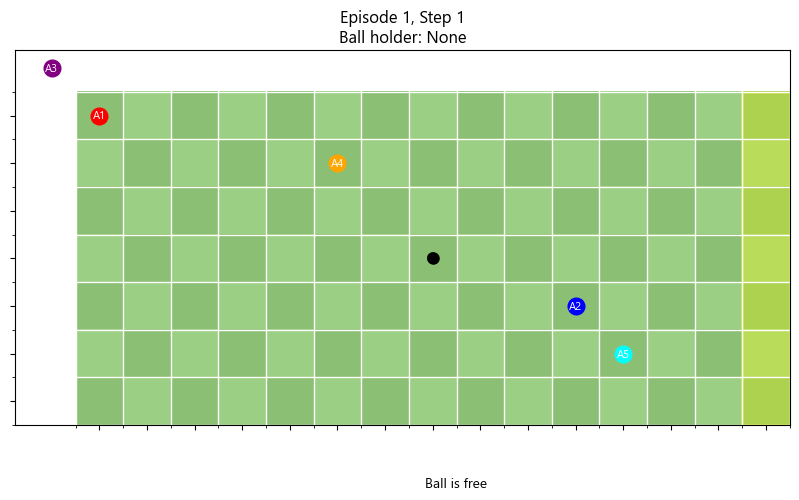

In [69]:
# Evaluate and create GIF
evaluate_football_env(env, num_episodes=4, max_steps_per_episode=50, output_file="football_simulation.gif")

# 4 player

In [8]:
import numpy as np
from gymnasium import Env
from gymnasium import spaces

def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    
    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
            
    return points

class Agent:
    def __init__(self, field_height, field_width, pos=None):
        self.field_height = field_height
        self.field_width = field_width
        self.action_space = spaces.Discrete(10)  # 8 moves + pass + stay still
        self.pos = pos
        self.position = np.array(pos) if pos is not None else np.array([
            np.random.randint(0, field_height),
            np.random.randint(0, field_width)
        ])
        self.pass_speed = 4
        self.pass_speed_decay = 1
        
        # Use dictionary for Q-table to handle complex state representation
        self.q_table = {}
    
    def get_q_value(self, state, action):
        """Get Q-value, initializing to zero if state-action pair not seen before"""
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space.n)
        return self.q_table[state][action]
    
    def update_q_value(self, state, action, value):
        """Update Q-value for a state-action pair"""
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space.n)
        self.q_table[state][action] = value
    
    def policy(self, state, epsilon):
        """Select action using epsilon-greedy policy"""
        if np.random.uniform(0, 1) < epsilon:
            return self.action_space.sample()
        else:
            if state not in self.q_table:
                self.q_table[state] = np.zeros(self.action_space.n)
            return np.argmax(self.q_table[state])

    def reset_position(self):
        if self.pos is None:
            self.position = np.array([
                np.random.randint(0, self.field_height),
                np.random.randint(0, self.field_width)
            ])
        else:
            self.position = np.array(self.pos)
        return self.position

    def pass_ball(self, current_position, target_position):
        """
        Calculate ball trajectory using Bresenham's line algorithm.
        
        :param current_position: Current ball position (x, y)
        :param target_position: Target position for pass (x, y)
        :return: ball trajectory points, initial speed, and direction vector
        """
        # Convert positions to integers for Bresenham algorithm
        start_x, start_y = int(current_position[0]), int(current_position[1])
        target_x, target_y = int(target_position[0]), int(target_position[1])
        
        # Calculate trajectory points using Bresenham's algorithm
        trajectory_points = bresenham_line(start_x, start_y, target_x, target_y)
        
        # Skip the first point (current position)
        if len(trajectory_points) > 1:
            trajectory_points = trajectory_points[1:]
        
        # Calculate direction vector (normalized)
        direction = np.array([target_position[0] - current_position[0], 
                             target_position[1] - current_position[1]])
        direction_norm = np.linalg.norm(direction)
        
        if direction_norm > 0:
            direction = direction / direction_norm
        else:
            direction = np.array([0, 0])
        
        return trajectory_points, self.pass_speed, direction

class FootballEnv(Env):
    def __init__(self, field_height, field_width, agents):
        super(FootballEnv, self).__init__()

        self.field_height = field_height  # x-axis (rows)
        self.field_width = field_width  # y-axis (columns)
        self.goal_y = self.field_width - 1  # Goal at the far right (y-axis)

        # Observation Space: Handled differently with complex state representation
        self.observation_space = spaces.Discrete(field_height * field_width)

        self.field = np.full((self.field_height, self.field_width), '.', dtype=str)
        self.rewards = np.full((self.field_height, self.field_width), -0.1, dtype=np.float32)
        
        self.ball_holder = None  # None: no one has the ball, 0: agent1, 1: agent2
        self.agents = agents
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0
        self.last_passer = None
        self.pass_target = None
        self.pass_attempts = 0
        self.successful_passes = 0

        self.reset()

    def _get_observation(self, agent_idx):
        """
        Create a comprehensive state representation for an agent that includes:
        - Agent's own position
        - Ball position
        - Ball holder information
        """
        # Calculate individual state features
        agent_pos = self.agents_positions[agent_idx]
        
        # Flatten the field into a 1D state space (encoding agent's own position)
        agent_pos_state = agent_pos[0] * self.field_width + agent_pos[1]
        
        # Encode ball position as a flattened state
        ball_pos_state = self.ball_pos[0] * self.field_width + self.ball_pos[1]
        
        # Encode ball holder (add field size to indicate no holder)
        ball_holder_state = self.field_height * self.field_width if self.ball_holder is None else self.ball_holder
        
        # Encode if ball is in transit
        ball_transit_state = 1 if self.ball_in_transit else 0
        
        # Combine features into a tuple that can be used as a dictionary key
        state_tuple = (agent_pos_state, ball_pos_state, ball_holder_state, ball_transit_state)
        
        return state_tuple

    def reset(self, seed=None, options=None):
        self.agents_positions = [agent.reset_position() for agent in self.agents]
        # Center of the field
        self.ball_pos = np.array([self.field_height // 2, self.field_width // 2])
        self.ball_holder = None
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0
        self.last_passer = None
        self.pass_target = None
        self.done = False
        
        # Initial observations
        observations = [self._get_observation(i) for i in range(len(self.agents))]
        
        return observations, self.ball_pos, self.ball_holder

    def closest_pass(self, ball_holder_idx):
        """Find the best agent to pass to based on position and distance"""
        ball_holder_pos = self.agents_positions[ball_holder_idx]
        
        # Calculate distances to all other agents
        distances = []
        for i, agent in enumerate(self.agents):
            if i != ball_holder_idx:
                # Calculate distance
                dist = np.linalg.norm(agent.position - ball_holder_pos)
                
                # Calculate position advantage (prefer agents ahead toward goal)
                position_advantage = 0
                if agent.position[1] > ball_holder_pos[1]:  # Agent is ahead (toward goal)
                    position_advantage = 10  # Strong preference for forward passes
                
                # Calculate score (lower is better - adjust weights as needed)
                score = dist - position_advantage
                
                # Only consider agents at a reasonable passing distance
                if 3 <= dist <= 8:
                    distances.append((i, score))
        
        # Sort by score and return the best option
        if distances:
            distances.sort(key=lambda x: x[1])
            return distances[0][0]  # Return the index of best agent to pass to
        
        # If no good passing option, find the closest agent as fallback
        closest_idx = -1
        min_dist = float('inf')
        for i, agent in enumerate(self.agents):
            if i != ball_holder_idx:
                dist = np.linalg.norm(agent.position - ball_holder_pos)
                if dist < min_dist:
                    min_dist = dist
                    closest_idx = i
        
        return closest_idx

    def calculate_reward(self, agent_idx, old_position, new_position):
        """Calculate rewards based on game situation and agent actions"""
        reward = 0
        
        # Base small negative reward to encourage efficiency
        reward -= 0.1
        
        # If agent has the ball
        if self.ball_holder == agent_idx:
            # Reward for moving toward the goal (but passing is higher priority)
            if new_position[1] > old_position[1]:  # Moving right toward goal
                reward += 0.5
            
            # Check for potential passing opportunities
            pass_target = self.closest_pass(agent_idx)
            if pass_target != -1:
                target_pos = self.agents_positions[pass_target]
                # If there's a good passing lane, encourage passing
                if 3 <= np.linalg.norm(new_position - target_pos) <= 8:
                    reward += 0.8  # Incentivize moving to positions where passing is good
        
        # If agent doesn't have the ball
        else:
            # If ball is free (no one has it) and not in transit
            if self.ball_holder is None and not self.ball_in_transit:
                # Reward for moving toward the ball
                ball_dist_old = np.linalg.norm(old_position - self.ball_pos)
                ball_dist_new = np.linalg.norm(new_position - self.ball_pos)
                if ball_dist_new < ball_dist_old:
                    reward += 0.7
            
            # If ball is in transit - reward for moving to receive position
            elif self.ball_in_transit:
                # If this agent is the target of a pass
                if self.pass_target == agent_idx:
                    # Reward for moving toward the predicted ball landing point
                    if self.ball_trajectory and self.ball_trajectory_index < len(self.ball_trajectory):
                        target_point = self.ball_trajectory[-1]  # Final point in trajectory
                        target_point = np.array(target_point)
                        
                        old_dist = np.linalg.norm(old_position - target_point)
                        new_dist = np.linalg.norm(new_position - target_point)
                        
                        if new_dist < old_dist:
                            reward += 1.5  # Significant reward for moving to receive position
            
            # If teammate has the ball
            elif self.ball_holder is not None:
                holder_pos = self.agents_positions[self.ball_holder]
                
                # Reward for positioning for a pass
                dist_to_holder = np.linalg.norm(new_position - holder_pos)
                
                # Calculate optimal passing distance range
                if 3 <= dist_to_holder <= 8:
                    reward += 0.5
                    
                    # Bonus for being ahead of ball holder (toward goal)
                    if new_position[1] > holder_pos[1]:
                        reward += 0.7
        
        return reward
    
    def step(self, actions):
        rewards = [0] * len(self.agents)
        
        # Store old positions for reward calculation
        old_positions = [agent.position.copy() for agent in self.agents]

        # Define movement mapping for 8 directions
        move_map = {
            0: np.array([0, 1]),   # Right
            1: np.array([1, 1]),   # Down-Right
            2: np.array([1, 0]),   # Down
            3: np.array([1, -1]),  # Down-Left
            4: np.array([0, -1]),  # Left
            5: np.array([-1, -1]), # Up-Left
            6: np.array([-1, 0]),  # Up
            7: np.array([-1, 1])   # Up-Right
        }

        # Ball in transit logic
        if self.ball_in_transit and self.ball_trajectory:
            steps_to_move = min(self.ball_transit_speed, len(self.ball_trajectory) - self.ball_trajectory_index)

            for _ in range(steps_to_move):
                if self.ball_trajectory_index < len(self.ball_trajectory):
                    next_x, next_y = self.ball_trajectory[self.ball_trajectory_index]
                    self.ball_pos = np.array([next_x, next_y])
                    self.ball_trajectory_index += 1

                    # Check if any agent receives the ball
                    for i, agent in enumerate(self.agents):
                        if np.array_equal(agent.position, self.ball_pos):
                            self.ball_holder = i
                            self.ball_in_transit = False
                            
                            # Significant rewards for successful passes
                            rewards[i] += 30  # Reward for receiving a pass
                            rewards[self.last_passer] += 100  # Major reward for successful pass
                            
                            self.successful_passes += 1
                            
                            # End episode on successful pass
                            self.done = True
                            
                            # Get observations for return
                            observations = [self._get_observation(i) for i in range(len(self.agents))]
                            return observations, rewards, self.done, {}

                else:
                    self.ball_in_transit = False
                    break

            # Apply speed decay
            self.ball_transit_speed = max(0, self.ball_transit_speed - self.agents[0].pass_speed_decay)

            if self.ball_transit_speed == 0 or self.ball_trajectory_index >= len(self.ball_trajectory):
                self.ball_in_transit = False
                # Ball missed - negative reward for passer
                if self.last_passer is not None:
                    rewards[self.last_passer] -= 20  # Penalty for failed pass

        # Agent movements and actions
        for i, action in enumerate(actions):
            agent = self.agents[i]
            
            # Current position before movement
            old_position = agent.position.copy()

            if action in move_map:
                new_position = agent.position + move_map[action]
                new_position[0] = np.clip(new_position[0], 0, self.field_height - 1)
                new_position[1] = np.clip(new_position[1], 0, self.field_width - 1)
                
                # Check if new position overlaps with another agent
                position_valid = True
                for j, other_agent in enumerate(self.agents):
                    if j != i and np.array_equal(new_position, other_agent.position):
                        position_valid = False
                        break
                
                if position_valid:
                    agent.position = new_position
                    self.agents_positions[i] = new_position

                    # If this agent is holding the ball, update ball position
                    if self.ball_holder == i and not self.ball_in_transit:
                        self.ball_pos = new_position.copy()

                    # If agent moves to a position with the ball on the field
                    if not self.ball_in_transit and np.array_equal(agent.position, self.ball_pos) and self.ball_holder is None:
                        self.ball_holder = i
                        rewards[i] += (20)  # Picking up the ball
                
                # Calculate movement-based rewards
                move_reward = self.calculate_reward(i, old_position, agent.position)
                rewards[i] += move_reward

            elif action == 8:  # Passing
                if self.ball_holder == i and not self.ball_in_transit:
                    target_agent_index = self.closest_pass(i)
                    
                    if target_agent_index != -1:  # Valid target found
                        target_position = self.agents[target_agent_index].position
                        trajectory_points, pass_speed, pass_direction = agent.pass_ball(self.ball_pos, target_position)

                        self.ball_trajectory = [(int(x), int(y)) for x, y in trajectory_points]
                        self.ball_trajectory_index = 0

                        self.ball_in_transit = True
                        self.ball_transit_speed = pass_speed
                        self.ball_transit_direction = pass_direction
                        self.last_passer = i  # Store who made the pass
                        self.pass_target = target_agent_index  # Store the intended receiver
                        self.ball_holder = None
                        self.pass_attempts += 1
                        
                        # Small immediate reward for attempting pass
                        rewards[i] += 10

            elif action == 9:  # Stay still
                # Small reward for staying still if waiting to receive a pass
                if self.ball_in_transit and self.pass_target == i:
                    rewards[i] += 0.5

        # Get observations after all actions
        observations = [self._get_observation(i) for i in range(len(self.agents))]
        
        return observations, rewards, self.done, {}

    def train(self, episodes, max_steps, epsilon_start=0.9, epsilon_end=0.1, gamma=0.95, alpha=0.1, print_frequency=1000):
        # Epsilon decay
        epsilon_decay = (epsilon_start - epsilon_end) / (episodes * 0.8)  # Decay over 80% of episodes
        epsilon = epsilon_start
        
        episode_rewards_history = []
        pass_success_rate_history = []
        
        for episode in range(episodes):
            # Reset the environment
            observations, _, _ = self.reset()
            
            total_rewards = [0] * len(self.agents)
            done = False
            steps = 0
            
            while not done and steps < max_steps:
                # Select actions using the policy
                actions = [agent.policy(observations[i], epsilon) for i, agent in enumerate(self.agents)]
                
                # Take actions in the environment
                next_observations, rewards, done, _ = self.step(actions)
                
                # Update Q-values using Q-learning
                for i, agent in enumerate(self.agents):
                    # Current Q-value
                    current_q = agent.get_q_value(observations[i], actions[i])
                    
                    # Calculate max future Q-value
                    next_max_q = max([agent.get_q_value(next_observations[i], a) 
                                     for a in range(agent.action_space.n)])
                    
                    # Q-learning update formula
                    new_q = current_q + alpha * (rewards[i] + gamma * next_max_q - current_q)
                    
                    # Update Q-value
                    agent.update_q_value(observations[i], actions[i], new_q)
                    
                    total_rewards[i] += rewards[i]
                
                # Update observations
                observations = next_observations
                steps += 1
            
            # Decay epsilon
            if epsilon > epsilon_end:
                epsilon -= epsilon_decay
            
            # Track metrics
            episode_rewards_history.append(sum(total_rewards))
            
            # Calculate pass success rate if attempts were made
            success_rate = 0
            if self.pass_attempts > 0:
                success_rate = self.successful_passes / self.pass_attempts
            pass_success_rate_history.append(success_rate)
            
            # Print progress
            if (episode + 1) % print_frequency == 0 or episode == episodes - 1:
                print(f"Episode {episode + 1}/{episodes}, "
                      f"Total Rewards: {sum(total_rewards):.1f}, "
                      f"Steps: {steps}, "
                      f"Epsilon: {epsilon:.3f}, "
                      f"Pass Success: {self.successful_passes}/{self.pass_attempts} ({success_rate*100:.1f}%)")
                
                # Reset success counter for next reporting period
                self.pass_attempts = 0
                self.successful_passes = 0
        
        return episode_rewards_history, pass_success_rate_history

    def render(self):
        field_copy = np.full((self.field_height, self.field_width), '.', dtype=str)
        
        # First, place the ball (if it's not held by an agent)
        if self.ball_holder is None:
            field_copy[self.ball_pos[0], self.ball_pos[1]] = 'B'  # (x, y) indexing
        
        # Place agents (will overwrite ball if they're in the same position)
        for i, pos in enumerate(self.agents_positions):
            field_copy[pos[0], pos[1]] = str(i + 1)  # Always just show the agent number
                
        # If ball is in transit, show trajectory
        if self.ball_in_transit:
            for idx, (x, y) in enumerate(self.ball_trajectory):
                if idx >= self.ball_trajectory_index:  # Only show remaining trajectory
                    if 0 <= x < self.field_height and 0 <= y < self.field_width:
                        if field_copy[x, y] == '.':  # Don't overwrite agents
                            field_copy[x, y] = '*'

        print("\n".join(["".join(row) for row in field_copy]) + "\n")

def evaluate_football_env(env, num_episodes=3, max_steps_per_episode=30, output_file="football_simulation.gif"):
    """
    Evaluate the football environment by running episodes and creating a GIF visualization.
    
    Args:
        env: The football environment
        num_episodes: Number of episodes to run
        max_steps_per_episode: Maximum steps per episode
        output_file: Output GIF filename
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    import matplotlib.patches as patches
    from matplotlib.animation import FuncAnimation
    import numpy as np
    
    # Initialize figures and axes
    fig, ax = plt.subplots(figsize=(10, 6))
    all_frames = []
    
    # Custom colormap for the field
    cmap = ListedColormap(['#8BBF73', '#9BCF83'])  # Light green colors for the field
    
    # Agent colors
    agent_colors = ['red', 'blue', 'purple', 'orange', 'cyan']
    
    for episode in range(num_episodes):
        print(f"Running evaluation episode {episode+1}/{num_episodes}")
        states, ball_pos, ball_holder = env.reset()
        
        # Record frames for this episode
        episode_frames = []
        
        for step in range(max_steps_per_episode):
            # Clear the axis for the new frame
            ax.clear()
            
            # Create a checkerboard pattern for the field
            field_pattern = np.zeros((env.field_height, env.field_width))
            for i in range(env.field_height):
                for j in range(env.field_width):
                    field_pattern[i, j] = (i + j) % 2
            
            # Display the field
            ax.imshow(field_pattern, cmap=cmap, origin='upper')
            
            # Add grid
            ax.set_xticks(np.arange(-0.5, env.field_width, 1), minor=True)
            ax.set_yticks(np.arange(-0.5, env.field_height, 1), minor=True)
            ax.grid(which='minor', color='white', linestyle='-', linewidth=1)
            ax.set_xticks(np.arange(0, env.field_width, 1))
            ax.set_yticks(np.arange(0, env.field_height, 1))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
            # Draw goal area
            goal_rect = patches.Rectangle((env.goal_y-0.5, -0.5), 1, env.field_height, 
                                         linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
            ax.add_patch(goal_rect)
            
            # Plot agents
            for i, pos in enumerate(env.agents_positions):
                agent_label = f"A{i+1}"
                if i == env.ball_holder:
                    agent_label += "🏀"  # Ball holder indicator
                    
                ax.plot(pos[1], pos[0], 'o', markersize=12, color=agent_colors[i % len(agent_colors)])
                ax.text(pos[1], pos[0], agent_label, ha='center', va='center', fontsize=8, 
                        color='white', fontweight='bold')
            
            # Plot the ball if it's not with any agent
            if env.ball_holder is None:
                ax.plot(env.ball_pos[1], env.ball_pos[0], 'o', markersize=8, color='black')
                ax.text(env.ball_pos[1], env.ball_pos[0], '🏀', ha='center', va='center', fontsize=8)
            
            # Display ball trajectory if in transit
            if env.ball_in_transit and env.ball_trajectory:
                # Only show remaining trajectory
                remaining_traj = env.ball_trajectory[env.ball_trajectory_index:]
                if remaining_traj:
                    traj_x = [p[1] for p in remaining_traj]  # y-coordinate for plotting
                    traj_y = [p[0] for p in remaining_traj]  # x-coordinate for plotting
                    ax.plot(traj_x, traj_y, 'k--', alpha=0.5)
                    # Add arrow to show direction
                    if len(traj_x) > 1:
                        ax.annotate('', xy=(traj_x[-1], traj_y[-1]), 
                                  xytext=(traj_x[0], traj_y[0]),
                                  arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
            
            # Add episode/step info
            ax.set_title(f"Episode {episode+1}, Step {step+1}\n"
                        f"Ball holder: {'None' if env.ball_holder is None else f'Agent {env.ball_holder+1}'}")
            
            # Add caption explaining the current state
            status_text = ""
            if env.ball_in_transit:
                status_text = "Ball in transit"
                if hasattr(env, 'last_passer') and env.last_passer is not None:
                    status_text += f" (from Agent {env.last_passer+1})"
            elif env.ball_holder is not None:
                status_text = f"Agent {env.ball_holder+1} has the ball"
            else:
                status_text = "Ball is free"
                
            ax.text(env.field_width/2, env.field_height+0.8, status_text, 
                   ha='center', fontsize=10)
            
            # Capture the frame
            fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            episode_frames.append(frame)
            
            # Take actions according to the current policy (no exploration)
            actions = [np.argmax(agent.q_table[states[i], :]) for i, agent in enumerate(env.agents)]
            (states, ball_pos, ball_holder), rewards, done, _ = env.step(actions)
            
            if done:
                # Add one final frame showing the completed state
                ax.clear()
                field_pattern = np.zeros((env.field_height, env.field_width))
                for i in range(env.field_height):
                    for j in range(env.field_width):
                        field_pattern[i, j] = (i + j) % 2
                
                ax.imshow(field_pattern, cmap=cmap, origin='upper')
                
                # Add grid
                ax.set_xticks(np.arange(-0.5, env.field_width, 1), minor=True)
                ax.set_yticks(np.arange(-0.5, env.field_height, 1), minor=True)
                ax.grid(which='minor', color='white', linestyle='-', linewidth=1)
                ax.set_xticks(np.arange(0, env.field_width, 1))
                ax.set_yticks(np.arange(0, env.field_height, 1))
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                
                # Draw goal area
                goal_rect = patches.Rectangle((env.goal_y-0.5, -0.5), 1, env.field_height, 
                                             linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
                ax.add_patch(goal_rect)
                
                # Plot agents
                for i, pos in enumerate(env.agents_positions):
                    agent_label = f"A{i+1}"
                    if i == env.ball_holder:
                        agent_label += "🏀"  # Ball holder indicator
                        
                    ax.plot(pos[1], pos[0], 'o', markersize=12, color=agent_colors[i % len(agent_colors)])
                    ax.text(pos[1], pos[0], agent_label, ha='center', va='center', fontsize=8, 
                            color='white', fontweight='bold')
                
                if env.ball_holder is None:
                    ax.plot(env.ball_pos[1], env.ball_pos[0], 'o', markersize=8, color='black')
                    ax.text(env.ball_pos[1], env.ball_pos[0], '🏀', ha='center', va='center', fontsize=8)
                
                ax.set_title(f"Episode {episode+1} Complete!")
                ax.text(env.field_width/2, env.field_height+0.8, "Episode complete", 
                       ha='center', fontsize=10)
                
                fig.canvas.draw()
                frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
                frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                episode_frames.append(frame)
                break
                
        # Add frames to the overall collection
        all_frames.extend(episode_frames)
        # Add a few blank frames between episodes
        for _ in range(10):
            all_frames.append(episode_frames[-1])  # Repeat the last frame as a pause
    
    # Save as GIF
    print(f"Creating GIF with {len(all_frames)} frames...")
    from PIL import Image
    frames_pil = [Image.fromarray(frame) for frame in all_frames]
    frames_pil[0].save(
        output_file,
        save_all=True,
        append_images=frames_pil[1:],
        optimize=False,
        duration=200,  # milliseconds per frame
        loop=0  # 0 means loop forever
    )
    print(f"GIF saved as {output_file}")
    
    return output_file

Starting training with 4 agents for 8000 episodes...
Ball will spawn at random positions for each episode
Episode 500/8000, Total Rewards: 80.1, Steps: 50, Epsilon: 0.834, Pass Success: 183/398 (46.0%)
Episode 1000/8000, Total Rewards: 61.4, Steps: 50, Epsilon: 0.767, Pass Success: 270/536 (50.4%)
Episode 1500/8000, Total Rewards: 45.9, Steps: 50, Epsilon: 0.701, Pass Success: 358/695 (51.5%)
Episode 2000/8000, Total Rewards: 106.6, Steps: 50, Epsilon: 0.634, Pass Success: 413/791 (52.2%)
Episode 2500/8000, Total Rewards: 183.7, Steps: 10, Epsilon: 0.568, Pass Success: 457/860 (53.1%)
Episode 3000/8000, Total Rewards: 209.4, Steps: 24, Epsilon: 0.502, Pass Success: 470/841 (55.9%)
Episode 3500/8000, Total Rewards: 167.7, Steps: 5, Epsilon: 0.435, Pass Success: 488/841 (58.0%)
Episode 4000/8000, Total Rewards: 180.1, Steps: 10, Epsilon: 0.369, Pass Success: 496/884 (56.1%)
Episode 4500/8000, Total Rewards: 221.5, Steps: 22, Epsilon: 0.302, Pass Success: 495/922 (53.7%)
Episode 5000/8000

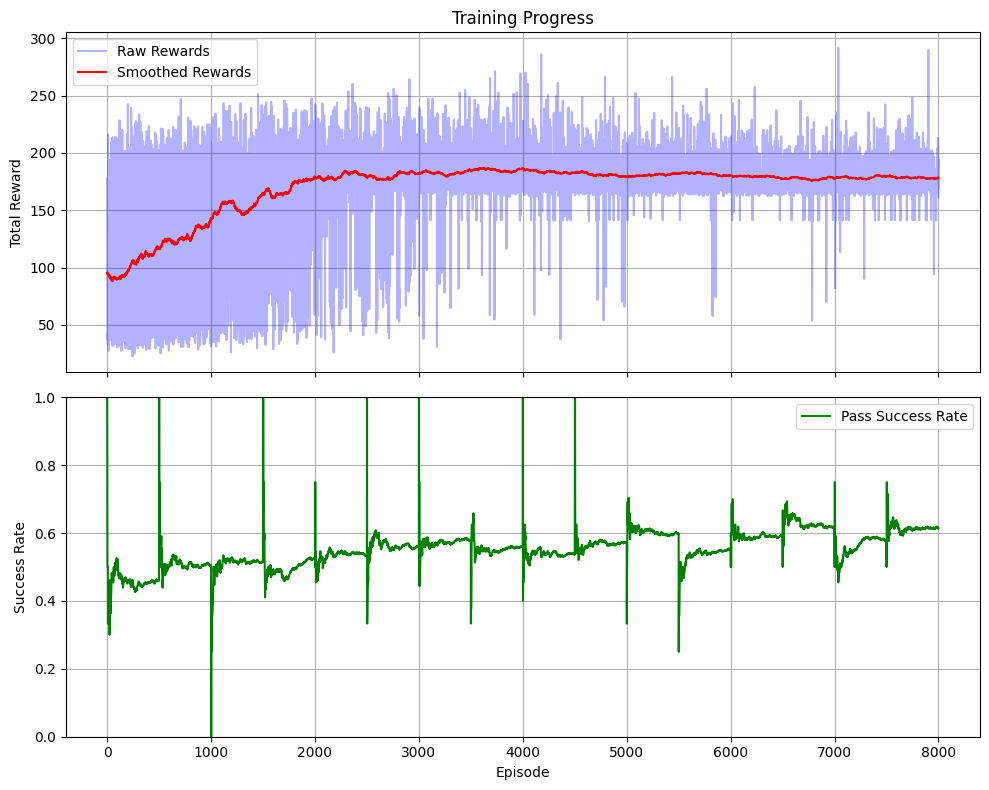


Evaluating agents for 5 episodes...
Using random ball placement for each episode
Episode 1/5
Ball starting position: [ 1 13], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:419: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from current font.
  fig.canvas.draw()
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:420: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:419: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from current font.
  fig.canvas.draw()
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:420: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Loca

Episode 2/5
Ball starting position: [ 5 10], Holder: 3


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:419: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from current font.
  fig.canvas.draw()
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:420: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:419: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from current font.
  fig.canvas.draw()
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:420: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Episode 3/5
Ball starting position: [2 6], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:419: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from current font.
  fig.canvas.draw()
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:420: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:419: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from current font.
  fig.canvas.draw()
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:420: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Loca

Episode 4/5
Ball starting position: [9 4], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:419: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from current font.
  fig.canvas.draw()
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:420: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:419: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from current font.
  fig.canvas.draw()
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:420: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Loca

Episode 5/5
Ball starting position: [5 2], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:419: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from current font.
  fig.canvas.draw()
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:420: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:419: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from current font.
  fig.canvas.draw()
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\3806695196.py:420: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Loca


Evaluation Results:
Average Reward: 168.62
Average Steps per Episode: 5.60
Pass Success Rate: 5/7 (71.4%)
Creating evaluation GIF with 28 frames...
Evaluation GIF saved as football_4agents_random_ball.gif


c:\Users\Pranaav_Prasad\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


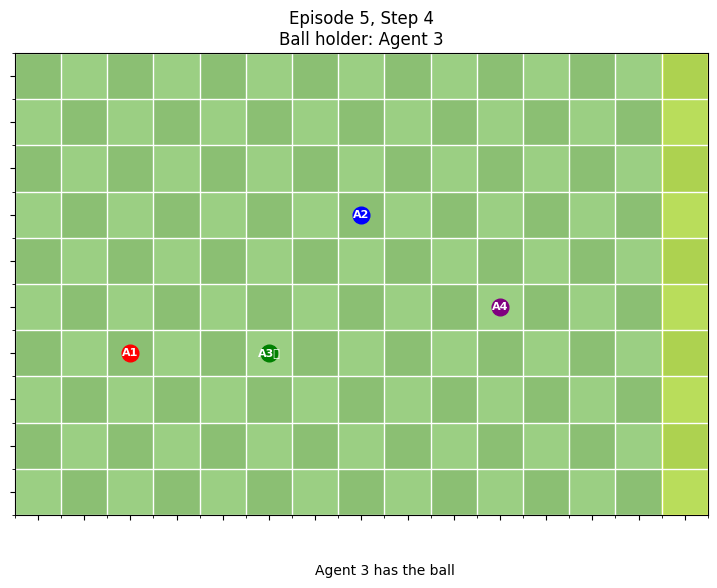

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import time

def train_football_agents(field_height=10, field_width=15, num_agents=4, episodes=10000, max_steps=50, 
                         learning_rate=0.1, discount_factor=0.95, epsilon_start=0.9, epsilon_end=0.05, 
                         print_frequency=500, plot_results=True):
    """
    Train multiple agents in the football environment using Q-learning.
    
    Args:
        field_height: Height of the football field
        field_width: Width of the football field
        num_agents: Number of agents to train
        episodes: Number of training episodes
        max_steps: Maximum steps per episode
        learning_rate: Learning rate (alpha)
        discount_factor: Discount factor (gamma)
        epsilon_start: Starting exploration rate
        epsilon_end: Final exploration rate
        print_frequency: How often to print progress
        plot_results: Whether to plot learning curves
        
    Returns:
        env: Trained environment with agents
        rewards_history: History of rewards during training
        pass_success_history: History of pass success rates
    """
    # Initialize agents at different positions
    agents = []
    for i in range(num_agents):
        # For simplicity, start agents at different positions
        if i == 0:
            pos = [field_height // 2, 1]  # Left side
        elif i == 1:
            pos = [field_height // 4, field_width // 3]  # Upper middle-left
        elif i == 2:
            pos = [3 * field_height // 4, field_width // 3]  # Lower middle-left
        else:
            pos = [field_height // 2, 2 * field_width // 3]  # Middle-right
            
        agents.append(Agent(field_height, field_width, pos=pos))
    
    # Create environment
    env = FootballEnv(field_height, field_width, agents)
    
    # Modify the reset method of the environment to spawn ball at random positions
    original_reset = env.reset
    
    def random_ball_reset(seed=None, options=None):
        # Call original reset to reset agents
        observations, _, _ = original_reset(seed, options)
        
        # Explicitly place the ball at a random position
        env.ball_pos = np.array([
            np.random.randint(0, field_height),
            np.random.randint(0, field_width)
        ])
        
        # No agent starts with the ball
        env.ball_holder = None
        env.ball_in_transit = False
        
        # Check if any agent is already at the ball position
        for i, agent_pos in enumerate(env.agents_positions):
            if np.array_equal(agent_pos, env.ball_pos):
                env.ball_holder = i  # This agent starts with the ball
                break
        
        # Return observations
        observations = [env._get_observation(i) for i in range(len(env.agents))]
        return observations, env.ball_pos, env.ball_holder
    
    # Replace the reset method
    env.reset = random_ball_reset
    
    # Train the agents
    print(f"Starting training with {num_agents} agents for {episodes} episodes...")
    print("Ball will spawn at random positions for each episode")
    start_time = time.time()
    
    rewards_history, pass_success_history = env.train(
        episodes=episodes,
        max_steps=max_steps,
        epsilon_start=epsilon_start,
        epsilon_end=epsilon_end,
        gamma=discount_factor,
        alpha=learning_rate,
        print_frequency=print_frequency
    )
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Plot learning curves if requested
    if plot_results:
        plot_training_results(rewards_history, pass_success_history)
    
    return env, rewards_history, pass_success_history

def plot_training_results(rewards_history, pass_success_history):
    """
    Plot the training progress metrics.
    
    Args:
        rewards_history: List of episode rewards
        pass_success_history: List of pass success rates
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Smooth the rewards for better visualization
    window_size = min(100, len(rewards_history) // 10)
    if window_size < 1:
        window_size = 1
    
    smoothed_rewards = []
    for i in range(len(rewards_history)):
        start_idx = max(0, i - window_size)
        end_idx = min(len(rewards_history), i + window_size + 1)
        smoothed_rewards.append(sum(rewards_history[start_idx:end_idx]) / (end_idx - start_idx))
    
    episodes = range(1, len(rewards_history) + 1)
    
    # Plot rewards
    ax1.plot(episodes, rewards_history, 'b-', alpha=0.3, label='Raw Rewards')
    ax1.plot(episodes, smoothed_rewards, 'r-', label='Smoothed Rewards')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Training Progress')
    ax1.legend()
    ax1.grid(True)
    
    # Plot pass success rate
    ax2.plot(episodes, pass_success_history, 'g-', label='Pass Success Rate')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Success Rate')
    ax2.set_ylim([0, 1])
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_progress.png')
    plt.show()

def evaluate_trained_agents(env, num_episodes=5, max_steps=30, render=True, output_gif="football_evaluation.gif", random_ball=True):
    """
    Evaluate trained agents in the football environment.
    
    Args:
        env: Trained FootballEnv instance
        num_episodes: Number of evaluation episodes
        max_steps: Maximum steps per episode
        render: Whether to render the environment
        output_gif: Filename for output GIF (if render=True)
        random_ball: Whether to spawn the ball randomly for each episode
        
    Returns:
        metrics: Dictionary with evaluation metrics
    """
    total_rewards = []
    episode_steps = []
    successful_passes = 0
    total_pass_attempts = 0
    
    if render:
        frames = []
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # If random_ball is True, make sure we're using the modified reset
    if random_ball and not hasattr(env, '_original_reset'):
        # Store the original reset function if not already stored
        env._original_reset = env.reset
        
        def random_ball_reset_eval(seed=None, options=None):
            # Call original reset
            observations, _, _ = env._original_reset(seed, options)
            
            # Place ball at random position
            env.ball_pos = np.array([
                np.random.randint(0, env.field_height),
                np.random.randint(0, env.field_width)
            ])
            
            # Check if any agent is at the ball position
            env.ball_holder = None
            for i, agent_pos in enumerate(env.agents_positions):
                if np.array_equal(agent_pos, env.ball_pos):
                    env.ball_holder = i
                    break
            
            # Reset other ball-related attributes
            env.ball_in_transit = False
            env.ball_trajectory = []
            env.ball_trajectory_index = 0
            env.pass_attempts = 0
            env.successful_passes = 0
            
            # Get updated observations
            observations = [env._get_observation(i) for i in range(len(env.agents))]
            return observations, env.ball_pos, env.ball_holder
        
        # Replace reset function for evaluation
        env.reset = random_ball_reset_eval
    
    print(f"\nEvaluating agents for {num_episodes} episodes...")
    if random_ball:
        print("Using random ball placement for each episode")
    
    for episode in range(num_episodes):
        observations, _, _ = env.reset()
        episode_reward = 0
        step_count = 0
        done = False
        
        print(f"Episode {episode+1}/{num_episodes}")
        print(f"Ball starting position: {env.ball_pos}, Holder: {env.ball_holder}")
        
        while not done and step_count < max_steps:
            # Use the learned policy (no exploration)
            actions = []
            for i, agent in enumerate(env.agents):
                state = observations[i]
                if state in agent.q_table:
                    actions.append(np.argmax(agent.q_table[state]))
                else:
                    # If state not seen during training, choose a reasonable action
                    if env.ball_holder == i:
                        actions.append(0)  # Move right (toward goal)
                    else:
                        # Move toward the ball
                        agent_pos = env.agents_positions[i]
                        ball_pos = env.ball_pos
                        
                        # Calculate direction vector to ball
                        dx = ball_pos[0] - agent_pos[0]
                        dy = ball_pos[1] - agent_pos[1]
                        
                        # Choose movement action based on direction
                        if abs(dx) > abs(dy):
                            # Prioritize vertical movement
                            if dx > 0:
                                actions.append(2)  # Down
                            else:
                                actions.append(6)  # Up
                        else:
                            # Prioritize horizontal movement
                            if dy > 0:
                                actions.append(0)  # Right
                            else:
                                actions.append(4)  # Left
            
            # Take actions in the environment
            next_observations, rewards, done, _ = env.step(actions)
            
            episode_reward += sum(rewards)
            observations = next_observations
            step_count += 1
            
            # Capture frames for GIF if rendering
            if render:
                frame = render_football_frame(env, ax, fig, episode, step_count)
                frames.append(frame)
            else:
                # Text-based rendering
                print(f"Step {step_count}:")
                env.render()
        
        total_rewards.append(episode_reward)
        episode_steps.append(step_count)
        successful_passes += env.successful_passes
        total_pass_attempts += env.pass_attempts
        
        # Add one final frame
        if render and not done:
            frame = render_football_frame(env, ax, fig, episode, step_count, done=True)
            frames.append(frame)
            
            # Add pause between episodes
            for _ in range(10):
                frames.append(frame)
    
    # Calculate evaluation metrics
    avg_reward = sum(total_rewards) / num_episodes if num_episodes > 0 else 0
    avg_steps = sum(episode_steps) / num_episodes if num_episodes > 0 else 0
    pass_success_rate = successful_passes / total_pass_attempts if total_pass_attempts > 0 else 0
    
    print("\nEvaluation Results:")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Average Steps per Episode: {avg_steps:.2f}")
    print(f"Pass Success Rate: {successful_passes}/{total_pass_attempts} ({pass_success_rate*100:.1f}%)")
    
    # Save GIF if rendering
    if render and frames:
        print(f"Creating evaluation GIF with {len(frames)} frames...")
        frames_pil = [Image.fromarray(frame) for frame in frames]
        frames_pil[0].save(
            output_gif,
            save_all=True,
            append_images=frames_pil[1:],
            optimize=False,
            duration=200,  # milliseconds per frame
            loop=0  # 0 means loop forever
        )
        print(f"Evaluation GIF saved as {output_gif}")
    
    # Restore original reset function if we modified it for evaluation
    if random_ball and hasattr(env, '_original_reset'):
        env.reset = env._original_reset
        delattr(env, '_original_reset')
    
    # Return metrics
    metrics = {
        'avg_reward': avg_reward,
        'avg_steps': avg_steps,
        'pass_success_rate': pass_success_rate,
        'total_passes': total_pass_attempts,
        'successful_passes': successful_passes
    }
    
    return metrics

def render_football_frame(env, ax, fig, episode, step, done=False):
    """
    Render a single frame of the football environment.
    
    Args:
        env: Football environment
        ax: Matplotlib axis
        fig: Matplotlib figure
        episode: Current episode number
        step: Current step number
        done: Whether the episode is done
        
    Returns:
        frame: Rendered frame as numpy array
    """
    # Clear the axis
    ax.clear()
    
    # Create a checkerboard pattern for the field
    field_pattern = np.zeros((env.field_height, env.field_width))
    for i in range(env.field_height):
        for j in range(env.field_width):
            field_pattern[i, j] = (i + j) % 2
    
    # Display the field with a green colormap
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(['#8BBF73', '#9BCF83'])  # Light green colors
    ax.imshow(field_pattern, cmap=cmap, origin='upper')
    
    # Add grid
    ax.set_xticks(np.arange(-0.5, env.field_width, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, env.field_height, 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=1)
    ax.set_xticks(np.arange(0, env.field_width, 1))
    ax.set_yticks(np.arange(0, env.field_height, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Draw goal area
    import matplotlib.patches as patches
    goal_rect = patches.Rectangle((env.goal_y-0.5, -0.5), 1, env.field_height, 
                                 linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
    ax.add_patch(goal_rect)
    
    # Agent colors
    agent_colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']
    
    # Plot agents
    for i, pos in enumerate(env.agents_positions):
        agent_label = f"A{i+1}"
        if i == env.ball_holder:
            agent_label += "🏀"  # Ball holder indicator
            
        ax.plot(pos[1], pos[0], 'o', markersize=12, color=agent_colors[i % len(agent_colors)])
        ax.text(pos[1], pos[0], agent_label, ha='center', va='center', fontsize=8, 
                color='white', fontweight='bold')
    
    # Plot the ball if it's not with any agent
    if env.ball_holder is None:
        ax.plot(env.ball_pos[1], env.ball_pos[0], 'o', markersize=8, color='black')
        ax.text(env.ball_pos[1], env.ball_pos[0], '🏀', ha='center', va='center', fontsize=8)
    
    # Display ball trajectory if in transit
    if env.ball_in_transit and env.ball_trajectory:
        # Only show remaining trajectory
        remaining_traj = env.ball_trajectory[env.ball_trajectory_index:]
        if remaining_traj:
            traj_x = [p[1] for p in remaining_traj]  # y-coordinate for plotting
            traj_y = [p[0] for p in remaining_traj]  # x-coordinate for plotting
            ax.plot(traj_x, traj_y, 'k--', alpha=0.5)
            # Add arrow to show direction
            if len(traj_x) > 1:
                ax.annotate('', xy=(traj_x[-1], traj_y[-1]), 
                          xytext=(traj_x[0], traj_y[0]),
                          arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    
    # Add episode/step info
    status = "Complete!" if done else f"Step {step}"
    ax.set_title(f"Episode {episode+1}, {status}\n"
                f"Ball holder: {'None' if env.ball_holder is None else f'Agent {env.ball_holder+1}'}")
    
    # Add caption explaining the current state
    status_text = ""
    if env.ball_in_transit:
        status_text = "Ball in transit"
        if hasattr(env, 'last_passer') and env.last_passer is not None:
            status_text += f" (from Agent {env.last_passer+1})"
    elif env.ball_holder is not None:
        status_text = f"Agent {env.ball_holder+1} has the ball"
    else:
        status_text = "Ball is free"
        
    ax.text(env.field_width/2, env.field_height+0.8, status_text, 
           ha='center', fontsize=10)
    
    # Capture the frame
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return frame

# Main function to run training and evaluation
def main():
    # Set parameters
    field_height = 10
    field_width = 15
    num_agents = 4
    
    # Training parameters
    training_episodes = 8000
    max_steps_per_episode = 50
    
    # Train agents
    trained_env, rewards_history, pass_success_history = train_football_agents(
        field_height=field_height,
        field_width=field_width,
        num_agents=num_agents,
        episodes=training_episodes,
        max_steps=max_steps_per_episode,
        epsilon_start=0.9,
        epsilon_end=0.05,
        print_frequency=500,
        plot_results=True
    )
    
    # Evaluate trained agents
    eval_metrics = evaluate_trained_agents(
        env=trained_env,
        num_episodes=5,
        max_steps=30,
        render=True,
        output_gif="football_4agents_random_ball.gif",
        random_ball=True  # Make sure we use random ball placement in evaluation too
    )
    
    return trained_env, eval_metrics

if __name__ == "__main__":
    trained_env, eval_metrics = main()

# 11 Player

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import time
import gymnasium as gym
from gymnasium import spaces

def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    
    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
            
    return points

class Agent:
    def __init__(self, field_height, field_width, pos=None):
        self.field_height = field_height
        self.field_width = field_width
        self.action_space = spaces.Discrete(10)  # 8 moves + pass + stay still
        self.pos = pos
        self.position = np.array(pos) if pos is not None else np.array([
            np.random.randint(0, field_height),
            np.random.randint(0, field_width)
        ])
        self.pass_speed = 6  # Increased pass speed for larger field
        self.pass_speed_decay = 1
        
        # Use dictionary for Q-table to handle complex state representation
        self.q_table = {}
    
    def get_q_value(self, state, action):
        """Get Q-value, initializing to zero if state-action pair not seen before"""
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space.n)
        return self.q_table[state][action]
    
    def update_q_value(self, state, action, value):
        """Update Q-value for a state-action pair"""
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space.n)
        self.q_table[state][action] = value
    
    def policy(self, state, epsilon):
        """Select action using epsilon-greedy policy"""
        if np.random.uniform(0, 1) < epsilon:
            return self.action_space.sample()
        else:
            if state not in self.q_table:
                self.q_table[state] = np.zeros(self.action_space.n)
            return np.argmax(self.q_table[state])

    def reset_position(self):
        if self.pos is None:
            self.position = np.array([
                np.random.randint(0, self.field_height),
                np.random.randint(0, self.field_width)
            ])
        else:
            self.position = np.array(self.pos)
        return self.position

    def pass_ball(self, current_position, target_position):
        """
        Calculate ball trajectory using Bresenham's line algorithm.
        
        :param current_position: Current ball position (x, y)
        :param target_position: Target position for pass (x, y)
        :return: ball trajectory points, initial speed, and direction vector
        """
        # Convert positions to integers for Bresenham algorithm
        start_x, start_y = int(current_position[0]), int(current_position[1])
        target_x, target_y = int(target_position[0]), int(target_position[1])
        
        # Calculate trajectory points using Bresenham's algorithm
        trajectory_points = bresenham_line(start_x, start_y, target_x, target_y)
        
        # Skip the first point (current position)
        if len(trajectory_points) > 1:
            trajectory_points = trajectory_points[1:]
        
        # Calculate direction vector (normalized)
        direction = np.array([target_position[0] - current_position[0], 
                             target_position[1] - current_position[1]])
        direction_norm = np.linalg.norm(direction)
        
        if direction_norm > 0:
            direction = direction / direction_norm
        else:
            direction = np.array([0, 0])
        
        return trajectory_points, self.pass_speed, direction

class FootballEnv(gym.Env):
    def __init__(self, field_height, field_width, agents):
        super(FootballEnv, self).__init__()

        self.field_height = field_height  # x-axis (rows)
        self.field_width = field_width  # y-axis (columns)
        self.goal_y = self.field_width - 1  # Goal at the far right (y-axis)

        # Observation Space: Handled differently with complex state representation
        self.observation_space = spaces.Discrete(field_height * field_width)

        self.field = np.full((self.field_height, self.field_width), '.', dtype=str)
        self.rewards = np.full((self.field_height, self.field_width), -0.1, dtype=np.float32)
        
        self.ball_holder = None  # None: no one has the ball, 0: agent1, 1: agent2
        self.agents = agents
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0
        self.last_passer = None
        self.pass_target = None
        self.pass_attempts = 0
        self.successful_passes = 0
        self.done = False

        self.reset()

    def _get_observation(self, agent_idx):
        """
        Create a comprehensive state representation for an agent that includes:
        - Agent's own position
        - Ball position
        - Ball holder information
        """
        # Calculate individual state features
        agent_pos = self.agents_positions[agent_idx]
        
        # For large fields, we'll use a simplified state representation
        # Encode agent's position relative to the ball rather than absolute position
        ball_rel_x = agent_pos[0] - self.ball_pos[0]
        ball_rel_y = agent_pos[1] - self.ball_pos[1]
        
        # Discretize relative positions to handle large field size
        # Map to ranges like -5 to +5 to keep state space manageable
        ball_rel_x = max(-5, min(5, ball_rel_x))
        ball_rel_y = max(-5, min(5, ball_rel_y))
        
        # Distance to goal (discretized to keep state space manageable)
        goal_dist_x = agent_pos[0] - self.field_height // 2  # Distance to goal center (x-axis)
        goal_dist_y = self.goal_y - agent_pos[1]  # Distance to goal line (y-axis)
        goal_dist_x = max(-5, min(5, goal_dist_x // 10))  # Discretize distance
        goal_dist_y = max(0, min(7, goal_dist_y // 10))  # Discretize distance
        
        # Encode ball holder (add field size to indicate no holder)
        ball_holder_state = -1 if self.ball_holder is None else self.ball_holder
        
        # Encode if ball is in transit
        ball_transit_state = 1 if self.ball_in_transit else 0
        
        # Is this agent the ball holder?
        is_ball_holder = 1 if self.ball_holder == agent_idx else 0
        
        # Combine features into a tuple that can be used as a dictionary key
        state_tuple = (ball_rel_x, ball_rel_y, goal_dist_x, goal_dist_y, 
                       ball_holder_state, ball_transit_state, is_ball_holder)
        
        return state_tuple

    def reset(self, seed=None, options=None):
        self.agents_positions = [agent.reset_position() for agent in self.agents]
        # Center of the field
        self.ball_pos = np.array([self.field_height // 2, self.field_width // 2])
        self.ball_holder = None
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0
        self.last_passer = None
        self.pass_target = None
        self.done = False
        
        # Initial observations
        observations = [self._get_observation(i) for i in range(len(self.agents))]
        
        return observations, self.ball_pos, self.ball_holder

    def closest_pass(self, ball_holder_idx):
        """Find the best agent to pass to based on position and distance"""
        ball_holder_pos = self.agents_positions[ball_holder_idx]
        
        # Calculate distances to all other agents
        distances = []
        for i, agent in enumerate(self.agents):
            if i != ball_holder_idx:
                # Calculate distance
                dist = np.linalg.norm(agent.position - ball_holder_pos)
                
                # Calculate position advantage (prefer agents ahead toward goal)
                position_advantage = 0
                if agent.position[1] > ball_holder_pos[1]:  # Agent is ahead (toward goal)
                    position_advantage = 10  # Strong preference for forward passes
                
                # Calculate score (lower is better - adjust weights as needed)
                score = dist - position_advantage
                
                # Only consider agents at a reasonable passing distance
                # For larger field, increase the reasonable pass distance
                if 5 <= dist <= 20:
                    distances.append((i, score))
        
        # Sort by score and return the best option
        if distances:
            distances.sort(key=lambda x: x[1])
            return distances[0][0]  # Return the index of best agent to pass to
        
        # If no good passing option, find the closest agent as fallback
        closest_idx = -1
        min_dist = float('inf')
        for i, agent in enumerate(self.agents):
            if i != ball_holder_idx:
                dist = np.linalg.norm(agent.position - ball_holder_pos)
                if dist < min_dist:
                    min_dist = dist
                    closest_idx = i
        
        return closest_idx

    def calculate_reward(self, agent_idx, old_position, new_position):
        """Calculate rewards based on game situation and agent actions"""
        reward = 0
        
        # Base small negative reward to encourage efficiency
        reward -= 0.1
        
        # If agent has the ball
        if self.ball_holder == agent_idx:
            # Reward for moving toward the goal (but passing is higher priority)
            if new_position[1] > old_position[1]:  # Moving right toward goal
                reward += 0.5
            
            # Check for potential passing opportunities
            pass_target = self.closest_pass(agent_idx)
            if pass_target != -1:
                target_pos = self.agents_positions[pass_target]
                # If there's a good passing lane, encourage passing
                if 5 <= np.linalg.norm(new_position - target_pos) <= 20:
                    reward += 0.8  # Incentivize moving to positions where passing is good
        
        # If agent doesn't have the ball
        else:
            # If ball is free (no one has it) and not in transit
            if self.ball_holder is None and not self.ball_in_transit:
                # Reward for moving toward the ball
                ball_dist_old = np.linalg.norm(old_position - self.ball_pos)
                ball_dist_new = np.linalg.norm(new_position - self.ball_pos)
                if ball_dist_new < ball_dist_old:
                    reward += 0.7
            
            # If ball is in transit - reward for moving to receive position
            elif self.ball_in_transit:
                # If this agent is the target of a pass
                if self.pass_target == agent_idx:
                    # Reward for moving toward the predicted ball landing point
                    if self.ball_trajectory and self.ball_trajectory_index < len(self.ball_trajectory):
                        target_point = self.ball_trajectory[-1]  # Final point in trajectory
                        target_point = np.array(target_point)
                        
                        old_dist = np.linalg.norm(old_position - target_point)
                        new_dist = np.linalg.norm(new_position - target_point)
                        
                        if new_dist < old_dist:
                            reward += 1.5  # Significant reward for moving to receive position
            
            # If teammate has the ball
            elif self.ball_holder is not None:
                holder_pos = self.agents_positions[self.ball_holder]
                
                # Reward for positioning for a pass
                dist_to_holder = np.linalg.norm(new_position - holder_pos)
                
                # Calculate optimal passing distance range (scaled for larger field)
                if 5 <= dist_to_holder <= 20:
                    reward += 0.5
                    
                    # Bonus for being ahead of ball holder (toward goal)
                    if new_position[1] > holder_pos[1]:
                        reward += 0.7
        
        return reward
    
    def step(self, actions):
        rewards = [0] * len(self.agents)
        
        # Store old positions for reward calculation
        old_positions = [agent.position.copy() for agent in self.agents]

        # Define movement mapping for 8 directions
        move_map = {
            0: np.array([0, 1]),   # Right
            1: np.array([1, 1]),   # Down-Right
            2: np.array([1, 0]),   # Down
            3: np.array([1, -1]),  # Down-Left
            4: np.array([0, -1]),  # Left
            5: np.array([-1, -1]), # Up-Left
            6: np.array([-1, 0]),  # Up
            7: np.array([-1, 1])   # Up-Right
        }

        # Ball in transit logic
        if self.ball_in_transit and self.ball_trajectory:
            steps_to_move = min(self.ball_transit_speed, len(self.ball_trajectory) - self.ball_trajectory_index)

            for _ in range(steps_to_move):
                if self.ball_trajectory_index < len(self.ball_trajectory):
                    next_x, next_y = self.ball_trajectory[self.ball_trajectory_index]
                    self.ball_pos = np.array([next_x, next_y])
                    self.ball_trajectory_index += 1

                    # Check if any agent receives the ball
                    for i, agent in enumerate(self.agents):
                        if np.array_equal(agent.position, self.ball_pos):
                            self.ball_holder = i
                            self.ball_in_transit = False
                            
                            # Significant rewards for successful passes
                            rewards[i] += 30  # Reward for receiving a pass
                            rewards[self.last_passer] += 100  # Major reward for successful pass
                            
                            self.successful_passes += 1
                            
                            # End episode on successful pass
                            self.done = True
                            
                            # Get observations for return
                            observations = [self._get_observation(i) for i in range(len(self.agents))]
                            return observations, rewards, self.done, {}

                else:
                    self.ball_in_transit = False
                    break

            # Apply speed decay
            self.ball_transit_speed = max(0, self.ball_transit_speed - self.agents[0].pass_speed_decay)

            if self.ball_transit_speed == 0 or self.ball_trajectory_index >= len(self.ball_trajectory):
                self.ball_in_transit = False
                # Ball missed - negative reward for passer
                if self.last_passer is not None:
                    rewards[self.last_passer] -= 20  # Penalty for failed pass

        # Agent movements and actions
        for i, action in enumerate(actions):
            agent = self.agents[i]
            
            # Current position before movement
            old_position = agent.position.copy()

            if action in move_map:
                new_position = agent.position + move_map[action]
                new_position[0] = np.clip(new_position[0], 0, self.field_height - 1)
                new_position[1] = np.clip(new_position[1], 0, self.field_width - 1)
                
                # Check if new position overlaps with another agent
                position_valid = True
                for j, other_agent in enumerate(self.agents):
                    if j != i and np.array_equal(new_position, other_agent.position):
                        position_valid = False
                        break
                
                if position_valid:
                    agent.position = new_position
                    self.agents_positions[i] = new_position

                    # If this agent is holding the ball, update ball position
                    if self.ball_holder == i and not self.ball_in_transit:
                        self.ball_pos = new_position.copy()

                    # If agent moves to a position with the ball on the field
                    if not self.ball_in_transit and np.array_equal(agent.position, self.ball_pos) and self.ball_holder is None:
                        self.ball_holder = i
                        rewards[i] += (20)  # Picking up the ball
                
                # Calculate movement-based rewards
                move_reward = self.calculate_reward(i, old_position, agent.position)
                rewards[i] += move_reward

            elif action == 8:  # Passing
                if self.ball_holder == i and not self.ball_in_transit:
                    target_agent_index = self.closest_pass(i)
                    
                    if target_agent_index != -1:  # Valid target found
                        target_position = self.agents[target_agent_index].position
                        trajectory_points, pass_speed, pass_direction = agent.pass_ball(self.ball_pos, target_position)

                        self.ball_trajectory = [(int(x), int(y)) for x, y in trajectory_points]
                        self.ball_trajectory_index = 0

                        self.ball_in_transit = True
                        self.ball_transit_speed = pass_speed
                        self.ball_transit_direction = pass_direction
                        self.last_passer = i  # Store who made the pass
                        self.pass_target = target_agent_index  # Store the intended receiver
                        self.ball_holder = None
                        self.pass_attempts += 1
                        
                        # Small immediate reward for attempting pass
                        rewards[i] += 10

            elif action == 9:  # Stay still
                # Small reward for staying still if waiting to receive a pass
                if self.ball_in_transit and self.pass_target == i:
                    rewards[i] += 0.5

        # Get observations after all actions
        observations = [self._get_observation(i) for i in range(len(self.agents))]
        
        return observations, rewards, self.done, {}

    def train(self, episodes, max_steps, epsilon_start=0.9, epsilon_end=0.1, gamma=0.95, alpha=0.1, print_frequency=100):
        # Epsilon decay
        epsilon_decay = (epsilon_start - epsilon_end) / (episodes * 0.8)  # Decay over 80% of episodes
        epsilon = epsilon_start
        
        episode_rewards_history = []
        pass_success_rate_history = []
        
        for episode in range(episodes):
            # Reset the environment
            observations, _, _ = self.reset()
            
            total_rewards = [0] * len(self.agents)
            done = False
            steps = 0
            
            while not done and steps < max_steps:
                # Select actions using the policy
                actions = [agent.policy(observations[i], epsilon) for i, agent in enumerate(self.agents)]
                
                # Take actions in the environment
                next_observations, rewards, done, _ = self.step(actions)
                
                # Update Q-values using Q-learning
                for i, agent in enumerate(self.agents):
                    # Current Q-value
                    current_q = agent.get_q_value(observations[i], actions[i])
                    
                    # Calculate max future Q-value
                    next_max_q = max([agent.get_q_value(next_observations[i], a) 
                                     for a in range(agent.action_space.n)])
                    
                    # Q-learning update formula
                    new_q = current_q + alpha * (rewards[i] + gamma * next_max_q - current_q)
                    
                    # Update Q-value
                    agent.update_q_value(observations[i], actions[i], new_q)
                    
                    total_rewards[i] += rewards[i]
                
                # Update observations
                observations = next_observations
                steps += 1
            
            # Decay epsilon
            if epsilon > epsilon_end:
                epsilon -= epsilon_decay
            
            # Track metrics
            episode_rewards_history.append(sum(total_rewards))
            
            # Calculate pass success rate if attempts were made
            success_rate = 0
            if self.pass_attempts > 0:
                success_rate = self.successful_passes / self.pass_attempts
            pass_success_rate_history.append(success_rate)
            
            # Print progress
            if (episode + 1) % print_frequency == 0 or episode == episodes - 1:
                print(f"Episode {episode + 1}/{episodes}, "
                      f"Total Rewards: {sum(total_rewards):.1f}, "
                      f"Steps: {steps}, "
                      f"Epsilon: {epsilon:.3f}, "
                      f"Pass Success: {self.successful_passes}/{self.pass_attempts} ({success_rate*100:.1f}%)")
                
                # Reset success counter for next reporting period
                self.pass_attempts = 0
                self.successful_passes = 0
        
        return episode_rewards_history, pass_success_rate_history

    def render(self):
        field_copy = np.full((self.field_height, self.field_width), '.', dtype=str)
        
        # First, place the ball (if it's not held by an agent)
        if self.ball_holder is None:
            field_copy[self.ball_pos[0], self.ball_pos[1]] = 'B'  # (x, y) indexing
        
        # Place agents (will overwrite ball if they're in the same position)
        for i, pos in enumerate(self.agents_positions):
            field_copy[pos[0], pos[1]] = str(i + 1)  # Always just show the agent number
                
        # If ball is in transit, show trajectory
        if self.ball_in_transit:
            for idx, (x, y) in enumerate(self.ball_trajectory):
                if idx >= self.ball_trajectory_index:  # Only show remaining trajectory
                    if 0 <= x < self.field_height and 0 <= y < self.field_width:
                        if field_copy[x, y] == '.':  # Don't overwrite agents
                            field_copy[x, y] = '*'
        
        # For large field, just print a subset around the ball
        ball_x, ball_y = self.ball_pos
        view_range = 15  # View range around the ball
        min_x = max(0, ball_x - view_range)
        max_x = min(self.field_height, ball_x + view_range + 1)
        min_y = max(0, ball_y - view_range)
        max_y = min(self.field_width, ball_y + view_range + 1)
        
        view = field_copy[min_x:max_x, min_y:max_y]
        print(f"Field view around ball position ({ball_x}, {ball_y}):")
        print("\n".join(["".join(row) for row in view]) + "\n")

def render_football_frame(env, ax, fig, episode, step, done=False):
    """
    Render a single frame of the football environment.
    
    Args:
        env: Football environment
        ax: Matplotlib axis
        fig: Matplotlib figure
        episode: Current episode number
        step: Current step number
        done: Whether the episode is done
        
    Returns:
        frame: Rendered frame as numpy array
    """
    # Clear the axis
    ax.clear()
    
    # Create a checkerboard pattern for the field
    field_pattern = np.zeros((env.field_height, env.field_width))
    for i in range(env.field_height):
        for j in range(env.field_width):
            field_pattern[i, j] = (i + j) % 2
    
    # Display the field with a green colormap
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(['#8BBF73', '#9BCF83'])  # Light green colors
    ax.imshow(field_pattern, cmap=cmap, origin='upper')
    
    # Add grid - for large fields, don't show all grid lines
    # Instead, show major grid lines every 10 cells
    ax.set_xticks(np.arange(0, env.field_width, 10))
    ax.set_yticks(np.arange(0, env.field_height, 10))
    ax.grid(which='major', color='white', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Draw goal area
    import matplotlib.patches as patches
    goal_rect = patches.Rectangle((env.goal_y-0.5, env.field_height//2-10), 1, 20, 
                                 linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
    ax.add_patch(goal_rect)
    
    # Agent colors for 11 players (added one more color)
    agent_colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 
                   'magenta', 'brown', 'pink', 'olive', 'darkturquoise']
    
    # Plot agents
    for i, pos in enumerate(env.agents_positions):
        agent_label = f"{i+1}"
        if i == env.ball_holder:
            ax.plot(pos[1], pos[0], 'o', markersize=12, color=agent_colors[i % len(agent_colors)], zorder=10)
            ax.plot(pos[1], pos[0], 'o', markersize=8, color='black', zorder=11)  # Ball indicator
        else:
            ax.plot(pos[1], pos[0], 'o', markersize=10, color=agent_colors[i % len(agent_colors)], zorder=10)
        
        ax.text(pos[1], pos[0], agent_label, ha='center', va='center', fontsize=8, 
                color='white', fontweight='bold', zorder=12)
    
    # Plot the ball if it's not with any agent
    if env.ball_holder is None:
        ax.plot(env.ball_pos[1], env.ball_pos[0], 'o', markersize=8, color='black', zorder=11)
    
    # Display ball trajectory if in transit
    if env.ball_in_transit and env.ball_trajectory:
        # Only show remaining trajectory
        remaining_traj = env.ball_trajectory[env.ball_trajectory_index:]
        if remaining_traj:
            traj_x = [p[1] for p in remaining_traj]  # y-coordinate for plotting
            traj_y = [p[0] for p in remaining_traj]  # x-coordinate for plotting
            ax.plot(traj_x, traj_y, 'k--', alpha=0.5, zorder=5)
            # Add arrow to show direction
            if len(traj_x) > 1:
                ax.annotate('', xy=(traj_x[-1], traj_y[-1]), 
                          xytext=(traj_x[0], traj_y[0]),
                          arrowprops=dict(arrowstyle='->', color='black', lw=1.5), zorder=6)
    
    # Add episode/step info
    status = "Complete!" if done else f"Step {step}"
    ax.set_title(f"Episode {episode+1}, {status}\n"
                f"Ball holder: {'None' if env.ball_holder is None else f'Agent {env.ball_holder+1}'}")
    
    # Add caption explaining the current state
    status_text = ""
    if env.ball_in_transit:
        status_text = "Ball in transit"
        if hasattr(env, 'last_passer') and env.last_passer is not None:
            status_text += f" (from Agent {env.last_passer+1})"
    elif env.ball_holder is not None:
        status_text = f"Agent {env.ball_holder+1} has the ball"
    else:
        status_text = "Ball is free"
        
    ax.text(env.field_width/2, -5, status_text, ha='center', fontsize=12)
    
    # Capture the frame
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return frame

Starting training with 11 agents on a 120x70 field for 5000 episodes...
Ball will spawn at random positions in the defensive third for each episode
Episode 500/5000, Total Rewards: 884.7, Steps: 260, Epsilon: 0.794, Pass Success: 497/1396 (35.6%)
Episode 1000/5000, Total Rewards: 511.9, Steps: 115, Epsilon: 0.688, Pass Success: 500/1346 (37.1%)
Episode 1500/5000, Total Rewards: 225.0, Steps: 17, Epsilon: 0.581, Pass Success: 500/1393 (35.9%)
Episode 2000/5000, Total Rewards: 289.3, Steps: 39, Epsilon: 0.475, Pass Success: 500/1480 (33.8%)
Episode 2500/5000, Total Rewards: 449.7, Steps: 73, Epsilon: 0.369, Pass Success: 500/1442 (34.7%)
Episode 3000/5000, Total Rewards: 339.2, Steps: 42, Epsilon: 0.263, Pass Success: 499/1453 (34.3%)
Episode 3500/5000, Total Rewards: 414.5, Steps: 85, Epsilon: 0.156, Pass Success: 500/1499 (33.4%)
Episode 4000/5000, Total Rewards: 332.0, Steps: 34, Epsilon: 0.050, Pass Success: 500/1379 (36.3%)
Episode 4500/5000, Total Rewards: 410.6, Steps: 52, Epsilon

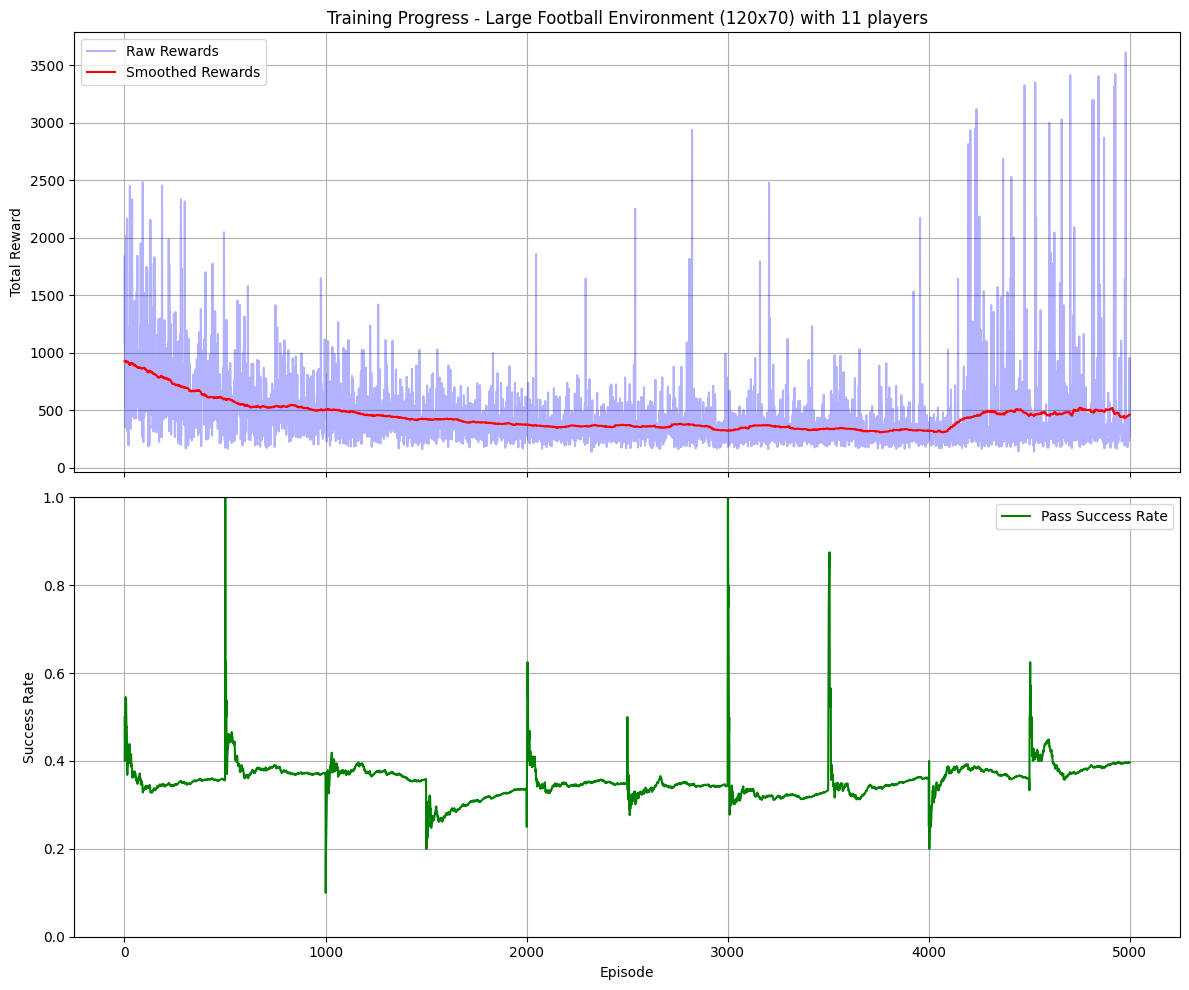


Evaluating agents for 5 episodes on 120x70 field...
Episode 1/5
Ball starting position: [22 14], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibD

Episode 2/5
Ball starting position: [43 33], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibD

Episode 3/5
Ball starting position: [26 33], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibD

Episode 4/5
Ball starting position: [37  8], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibD

Episode 5/5
Ball starting position: [33 30], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\926573869.py:387: MatplotlibD


Evaluation Results:
Average Reward: 356.20
Average Steps per Episode: 40.60
Pass Success Rate: 5/19 (26.3%)
Creating evaluation GIF with 203 frames...
Evaluation GIF saved as 11agents.gif


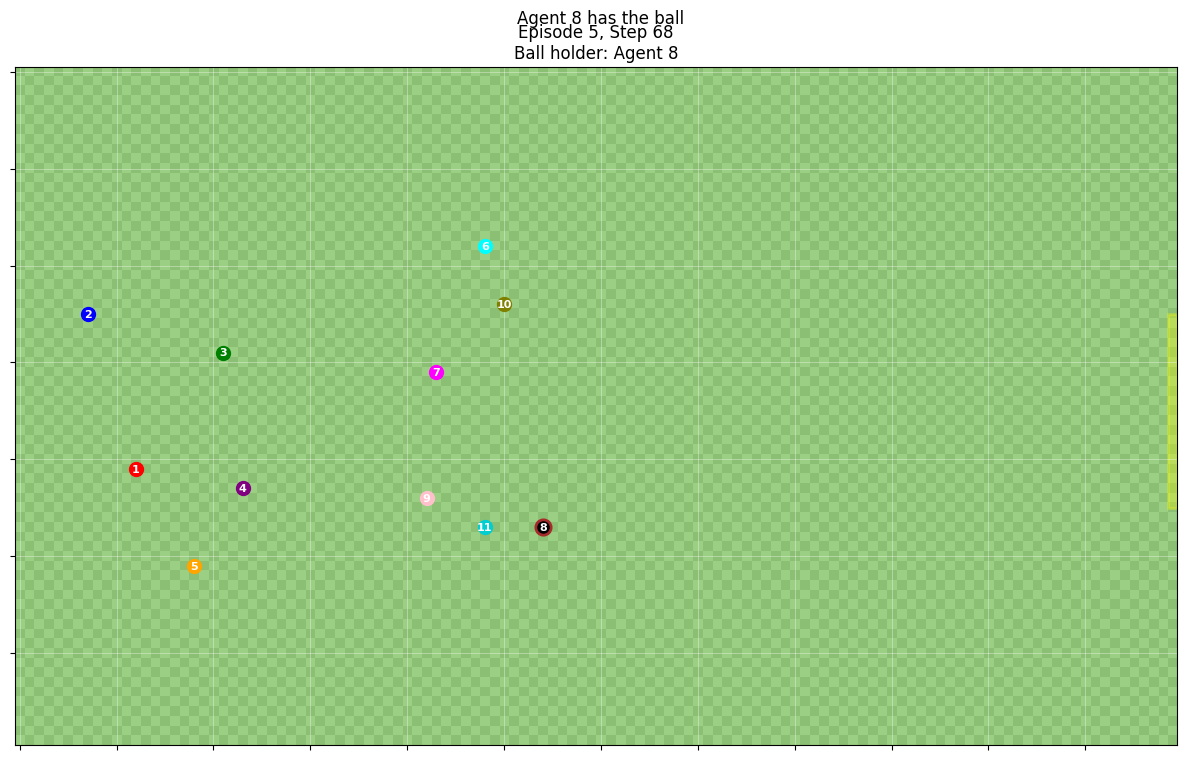

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import time
import gymnasium as gym
from gymnasium import spaces

# Using the previously defined bresenham_line and Agent classes

def train_large_football_system(field_height=70, field_width=120, num_agents=11, episodes=10000, max_steps=1000,
                               learning_rate=0.1, discount_factor=0.95, epsilon_start=0.9, epsilon_end=0.05,
                               print_frequency=500, plot_results=True):
    """
    Train multiple agents in a large football environment using Q-learning.
    
    Args:
        field_height: Height of the football field (70)
        field_width: Width of the football field (120)
        num_agents: Number of agents to train (11)
        episodes: Number of training episodes
        max_steps: Maximum steps per episode
        learning_rate: Learning rate (alpha)
        discount_factor: Discount factor (gamma)
        epsilon_start: Starting exploration rate
        epsilon_end: Final exploration rate
        print_frequency: How often to print progress
        plot_results: Whether to plot learning curves
        
    Returns:
        env: Trained environment with agents
        rewards_history: History of rewards during training
        pass_success_history: History of pass success rates
    """
    # Initialize agents at strategic positions across the field
    agents = []
    
    # Define strategic positions for 11 players - formation 4-4-2
    positions = [
        [field_height // 2, 5],                      # Goalkeeper
        [field_height // 6, field_width // 6],       # Defender left
        [field_height // 3, field_width // 6],       # Defender center-left
        [2 * field_height // 3, field_width // 6],   # Defender center-right
        [5 * field_height // 6, field_width // 6],   # Defender right
        [field_height // 6, field_width // 3],       # Midfielder left
        [field_height // 3, field_width // 3],       # Midfielder center-left
        [2 * field_height // 3, field_width // 3],   # Midfielder center-right
        [5 * field_height // 6, field_width // 3],   # Midfielder right
        [field_height // 3, field_width // 2],       # Forward left
        [2 * field_height // 3, field_width // 2]    # Forward right
    ]
    
    for i in range(num_agents):
        agents.append(Agent(field_height, field_width, pos=positions[i]))
    
    # Create environment
    env = FootballEnv(field_height, field_width, agents)
    
    # Modify the reset method of the environment to spawn ball at random positions
    original_reset = env.reset
    
    def random_ball_reset(seed=None, options=None):
        # Call original reset to reset agents
        observations, _, _ = original_reset(seed, options)
        
        # Explicitly place the ball at a random position in the first third of the field
        env.ball_pos = np.array([
            np.random.randint(field_height // 4, 3 * field_height // 4),
            np.random.randint(5, field_width // 3)
        ])
        
        # No agent starts with the ball
        env.ball_holder = None
        env.ball_in_transit = False
        
        # Check if any agent is already at the ball position
        for i, agent_pos in enumerate(env.agents_positions):
            if np.array_equal(agent_pos, env.ball_pos):
                env.ball_holder = i  # This agent starts with the ball
                break
        
        # Return observations
        observations = [env._get_observation(i) for i in range(len(env.agents))]
        return observations, env.ball_pos, env.ball_holder
    
    # Replace the reset method
    env.reset = random_ball_reset
    
    # Train the agents
    print(f"Starting training with {num_agents} agents on a {field_width}x{field_height} field for {episodes} episodes...")
    print("Ball will spawn at random positions in the defensive third for each episode")
    start_time = time.time()
    
    rewards_history, pass_success_history = env.train(
        episodes=episodes,
        max_steps=max_steps,
        epsilon_start=epsilon_start,
        epsilon_end=epsilon_end,
        gamma=discount_factor,
        alpha=learning_rate,
        print_frequency=print_frequency
    )
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Plot learning curves if requested
    if plot_results:
        plot_training_results(rewards_history, pass_success_history)
    
    return env, rewards_history, pass_success_history

def evaluate_large_football_system(env, num_episodes=5, max_steps=100, render=True, 
                                  output_gif="large_football_evaluation.gif", random_ball=True):
    """
    Evaluate trained agents in the large football environment.
    
    Args:
        env: Trained FootballEnv instance
        num_episodes: Number of evaluation episodes
        max_steps: Maximum steps per episode
        render: Whether to render the environment
        output_gif: Filename for output GIF (if render=True)
        random_ball: Whether to spawn the ball randomly for each episode
        
    Returns:
        metrics: Dictionary with evaluation metrics
    """
    total_rewards = []
    episode_steps = []
    successful_passes = 0
    total_pass_attempts = 0
    
    if render:
        frames = []
        fig, ax = plt.subplots(figsize=(15, 9))  # Larger figure for the bigger field
    
    # If random_ball is True, make sure we're using the modified reset
    if random_ball and not hasattr(env, '_original_reset'):
        # Store the original reset function if not already stored
        env._original_reset = env.reset
        
        def random_ball_reset_eval(seed=None, options=None):
            # Call original reset
            observations, _, _ = env._original_reset(seed, options)
            
            # Place ball at random position in the defensive third
            env.ball_pos = np.array([
                np.random.randint(env.field_height // 4, 3 * env.field_height // 4),
                np.random.randint(5, env.field_width // 3)
            ])
            
            # Check if any agent is at the ball position
            env.ball_holder = None
            for i, agent_pos in enumerate(env.agents_positions):
                if np.array_equal(agent_pos, env.ball_pos):
                    env.ball_holder = i
                    break
            
            # Reset other ball-related attributes
            env.ball_in_transit = False
            env.ball_trajectory = []
            env.ball_trajectory_index = 0
            env.pass_attempts = 0
            env.successful_passes = 0
            
            # Get updated observations
            observations = [env._get_observation(i) for i in range(len(env.agents))]
            return observations, env.ball_pos, env.ball_holder
        
        # Replace reset function for evaluation
        env.reset = random_ball_reset_eval
    
    print(f"\nEvaluating agents for {num_episodes} episodes on {env.field_width}x{env.field_height} field...")
    
    for episode in range(num_episodes):
        observations, _, _ = env.reset()
        episode_reward = 0
        step_count = 0
        done = False
        
        print(f"Episode {episode+1}/{num_episodes}")
        print(f"Ball starting position: {env.ball_pos}, Holder: {env.ball_holder}")
        
        while not done and step_count < max_steps:
            # Use the learned policy (no exploration)
            actions = []
            for i, agent in enumerate(env.agents):
                state = observations[i]
                if state in agent.q_table:
                    actions.append(np.argmax(agent.q_table[state]))
                else:
                    # If state not seen during training, choose a reasonable action
                    if env.ball_holder == i:
                        actions.append(0)  # Move right (toward goal)
                    else:
                        # Move toward the ball
                        agent_pos = env.agents_positions[i]
                        ball_pos = env.ball_pos
                        
                        # Calculate direction vector to ball
                        dx = ball_pos[0] - agent_pos[0]
                        dy = ball_pos[1] - agent_pos[1]
                        
                        # Choose movement action based on direction
                        if abs(dx) > abs(dy):
                            # Prioritize vertical movement
                            if dx > 0:
                                actions.append(2)  # Down
                            else:
                                actions.append(6)  # Up
                        else:
                            # Prioritize horizontal movement
                            if dy > 0:
                                actions.append(0)  # Right
                            else:
                                actions.append(4)  # Left
            
            # Take actions in the environment
            next_observations, rewards, done, _ = env.step(actions)
            
            episode_reward += sum(rewards)
            observations = next_observations
            step_count += 1
            
            # Capture frames for GIF if rendering
            if render:
                frame = render_football_frame(env, ax, fig, episode, step_count)
                frames.append(frame)
            else:
                # Text-based rendering for large field (show area around ball)
                if step_count % 5 == 0:  # Only render every 5 steps to save console space
                    print(f"Step {step_count}:")
                    env.render()
        
        total_rewards.append(episode_reward)
        episode_steps.append(step_count)
        successful_passes += env.successful_passes
        total_pass_attempts += env.pass_attempts
        
        # Add one final frame
        if render and not done:
            frame = render_football_frame(env, ax, fig, episode, step_count, done=True)
            frames.append(frame)
            
            # Add pause between episodes
            for _ in range(10):
                frames.append(frame)
    
    # Calculate evaluation metrics
    avg_reward = sum(total_rewards) / num_episodes if num_episodes > 0 else 0
    avg_steps = sum(episode_steps) / num_episodes if num_episodes > 0 else 0
    pass_success_rate = successful_passes / total_pass_attempts if total_pass_attempts > 0 else 0
    
    print("\nEvaluation Results:")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Average Steps per Episode: {avg_steps:.2f}")
    print(f"Pass Success Rate: {successful_passes}/{total_pass_attempts} ({pass_success_rate*100:.1f}%)")
    
    # Save GIF if rendering
    if render and frames:
        print(f"Creating evaluation GIF with {len(frames)} frames...")
        frames_pil = [Image.fromarray(frame) for frame in frames]
        frames_pil[0].save(
            output_gif,
            save_all=True,
            append_images=frames_pil[1:],
            optimize=False,
            duration=200,  # milliseconds per frame
            loop=0  # 0 means loop forever
        )
        print(f"Evaluation GIF saved as {output_gif}")
    
    # Restore original reset function if we modified it for evaluation
    if random_ball and hasattr(env, '_original_reset'):
        env.reset = env._original_reset
        delattr(env, '_original_reset')
    
    # Return metrics
    metrics = {
        'avg_reward': avg_reward,
        'avg_steps': avg_steps,
        'pass_success_rate': pass_success_rate,
        'total_passes': total_pass_attempts,
        'successful_passes': successful_passes
    }
    
    return metrics

def render_football_frame(env, ax, fig, episode, step, done=False):
    """
    Render a single frame of the football environment.
    
    Args:
        env: Football environment
        ax: Matplotlib axis
        fig: Matplotlib figure
        episode: Current episode number
        step: Current step number
        done: Whether the episode is done
        
    Returns:
        frame: Rendered frame as numpy array
    """
    # Clear the axis
    ax.clear()
    
    # Create a checkerboard pattern for the field
    field_pattern = np.zeros((env.field_height, env.field_width))
    for i in range(env.field_height):
        for j in range(env.field_width):
            field_pattern[i, j] = (i + j) % 2
    
    # Display the field with a green colormap
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(['#8BBF73', '#9BCF83'])  # Light green colors
    ax.imshow(field_pattern, cmap=cmap, origin='upper')
    
    # Add grid - for large fields, don't show all grid lines
    # Instead, show major grid lines every 10 cells
    ax.set_xticks(np.arange(0, env.field_width, 10))
    ax.set_yticks(np.arange(0, env.field_height, 10))
    ax.grid(which='major', color='white', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Draw goal area
    import matplotlib.patches as patches
    goal_rect = patches.Rectangle((env.goal_y-0.5, env.field_height//2-10), 1, 20, 
                                 linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
    ax.add_patch(goal_rect)
    
    # Agent colors for 11 players
    agent_colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 
                   'magenta', 'brown', 'pink', 'olive', 'darkturquoise']
    
    # Plot agents
    for i, pos in enumerate(env.agents_positions):
        agent_label = f"{i+1}"
        if i == env.ball_holder:
            ax.plot(pos[1], pos[0], 'o', markersize=12, color=agent_colors[i % len(agent_colors)], zorder=10)
            ax.plot(pos[1], pos[0], 'o', markersize=8, color='black', zorder=11)  # Ball indicator
        else:
            ax.plot(pos[1], pos[0], 'o', markersize=10, color=agent_colors[i % len(agent_colors)], zorder=10)
        
        ax.text(pos[1], pos[0], agent_label, ha='center', va='center', fontsize=8, 
                color='white', fontweight='bold', zorder=12)
    
    # Plot the ball if it's not with any agent
    if env.ball_holder is None:
        ax.plot(env.ball_pos[1], env.ball_pos[0], 'o', markersize=8, color='black', zorder=11)
    
    # Display ball trajectory if in transit
    if env.ball_in_transit and env.ball_trajectory:
        # Only show remaining trajectory
        remaining_traj = env.ball_trajectory[env.ball_trajectory_index:]
        if remaining_traj:
            traj_x = [p[1] for p in remaining_traj]  # y-coordinate for plotting
            traj_y = [p[0] for p in remaining_traj]  # x-coordinate for plotting
            ax.plot(traj_x, traj_y, 'k--', alpha=0.5, zorder=5)
            # Add arrow to show direction
            if len(traj_x) > 1:
                ax.annotate('', xy=(traj_x[-1], traj_y[-1]), 
                          xytext=(traj_x[0], traj_y[0]),
                          arrowprops=dict(arrowstyle='->', color='black', lw=1.5), zorder=6)
    
    # Add episode/step info
    status = "Complete!" if done else f"Step {step}"
    ax.set_title(f"Episode {episode+1}, {status}\n"
                f"Ball holder: {'None' if env.ball_holder is None else f'Agent {env.ball_holder+1}'}")
    
    # Add caption explaining the current state
    status_text = ""
    if env.ball_in_transit:
        status_text = "Ball in transit"
        if hasattr(env, 'last_passer') and env.last_passer is not None:
            status_text += f" (from Agent {env.last_passer+1})"
    elif env.ball_holder is not None:
        status_text = f"Agent {env.ball_holder+1} has the ball"
    else:
        status_text = "Ball is free"
        
    ax.text(env.field_width/2, -5, status_text, ha='center', fontsize=12)
    
    # Capture the frame
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return frame

def plot_training_results(rewards_history, pass_success_history):
    """
    Plot the training progress metrics.
    
    Args:
        rewards_history: List of episode rewards
        pass_success_history: List of pass success rates
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Smooth the rewards for better visualization
    window_size = min(100, len(rewards_history) // 10)
    if window_size < 1:
        window_size = 1
    
    smoothed_rewards = []
    for i in range(len(rewards_history)):
        start_idx = max(0, i - window_size)
        end_idx = min(len(rewards_history), i + window_size + 1)
        smoothed_rewards.append(sum(rewards_history[start_idx:end_idx]) / (end_idx - start_idx))
    
    episodes = range(1, len(rewards_history) + 1)
    
    # Plot rewards
    ax1.plot(episodes, rewards_history, 'b-', alpha=0.3, label='Raw Rewards')
    ax1.plot(episodes, smoothed_rewards, 'r-', label='Smoothed Rewards')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Training Progress - Large Football Environment (120x70) with 11 players')
    ax1.legend()
    ax1.grid(True)
    
    # Plot pass success rate
    ax2.plot(episodes, pass_success_history, 'g-', label='Pass Success Rate')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Success Rate')
    ax2.set_ylim([0, 1])
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('11player_training_progress.png')
    plt.show()

# Main function to run training and evaluation
def main():
    # Set parameters for large field
    field_height = 70
    field_width = 120
    num_agents = 11  # Updated to 11 players
    
    # Training parameters
    training_episodes = 5000  # Reduced from 8000 to balance training time
    max_steps_per_episode = 1000  # Increased for larger field
    
    # Train agents
    trained_env, rewards_history, pass_success_history = train_large_football_system(
        field_height=field_height,
        field_width=field_width,
        num_agents=num_agents,
        episodes=training_episodes,
        max_steps=max_steps_per_episode,
        epsilon_start=0.9,
        epsilon_end=0.05,
        print_frequency=500,
        plot_results=True
    )
    
    # Evaluate trained agents
    eval_metrics = evaluate_large_football_system(
        env=trained_env,
        num_episodes=5,
        max_steps=150,
        render=True,
        output_gif="11agents.gif",  # Updated filename
        random_ball=True
    )
    
    return trained_env, eval_metrics

if __name__ == "__main__":
    trained_env, eval_metrics = main()

# 4 Player - Updated rewards

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import time
import gymnasium as gym
from gymnasium import spaces

def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    
    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
            
    return points

class Agent:
    def __init__(self, field_height, field_width, pos=None):
        self.field_height = field_height
        self.field_width = field_width
        self.action_space = spaces.Discrete(10)  # 8 moves + pass + stay still
        self.pos = pos
        self.position = np.array(pos) if pos is not None else np.array([
            np.random.randint(0, field_height),
            np.random.randint(0, field_width)
        ])
        self.pass_speed = 4  # Reduced pass speed for smaller futsal field
        self.pass_speed_decay = 1
        
        # Use dictionary for Q-table to handle complex state representation
        self.q_table = {}
    
    def get_q_value(self, state, action):
        """Get Q-value, initializing to zero if state-action pair not seen before"""
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space.n)
        return self.q_table[state][action]
    
    def update_q_value(self, state, action, value):
        """Update Q-value for a state-action pair"""
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space.n)
        self.q_table[state][action] = value
    
    def policy(self, state, epsilon):
        """Select action using epsilon-greedy policy"""
        if np.random.uniform(0, 1) < epsilon:
            return self.action_space.sample()
        else:
            if state not in self.q_table:
                self.q_table[state] = np.zeros(self.action_space.n)
            return np.argmax(self.q_table[state])

    def reset_position(self):
        if self.pos is None:
            self.position = np.array([
                np.random.randint(0, self.field_height),
                np.random.randint(0, self.field_width)
            ])
        else:
            self.position = np.array(self.pos)
        return self.position

    def pass_ball(self, current_position, target_position):
        """
        Calculate ball trajectory using Bresenham's line algorithm.
        
        :param current_position: Current ball position (x, y)
        :param target_position: Target position for pass (x, y)
        :return: ball trajectory points, initial speed, and direction vector
        """
        # Convert positions to integers for Bresenham algorithm
        start_x, start_y = int(current_position[0]), int(current_position[1])
        target_x, target_y = int(target_position[0]), int(target_position[1])
        
        # Calculate trajectory points using Bresenham's algorithm
        trajectory_points = bresenham_line(start_x, start_y, target_x, target_y)
        
        # Skip the first point (current position)
        if len(trajectory_points) > 1:
            trajectory_points = trajectory_points[1:]
        
        # Calculate direction vector (normalized)
        direction = np.array([target_position[0] - current_position[0], 
                             target_position[1] - current_position[1]])
        direction_norm = np.linalg.norm(direction)
        
        if direction_norm > 0:
            direction = direction / direction_norm
        else:
            direction = np.array([0, 0])
        
        return trajectory_points, self.pass_speed, direction

class FootballEnv(gym.Env):
    def __init__(self, field_height, field_width, agents):
        super(FootballEnv, self).__init__()

        self.field_height = field_height  # x-axis (rows)
        self.field_width = field_width  # y-axis (columns)
        self.goal_y = self.field_width - 1  # Goal at the far right (y-axis)

        # Observation Space: Handled differently with complex state representation
        self.observation_space = spaces.Discrete(field_height * field_width)

        self.field = np.full((self.field_height, self.field_width), '.', dtype=str)
        self.rewards = np.full((self.field_height, self.field_width), -0.1, dtype=np.float32)
        
        self.ball_holder = None  # None: no one has the ball, 0: agent1, 1: agent2
        self.agents = agents
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0
        self.last_passer = None
        self.pass_target = None
        self.pass_attempts = 0
        self.successful_passes = 0
        self.done = False

        self.reset()

    def _get_observation(self, agent_idx):
        """
        Create a comprehensive state representation for an agent that includes:
        - Agent's own position
        - Ball position
        - Ball holder information
        """
        # Calculate individual state features
        agent_pos = self.agents_positions[agent_idx]
        
        # For large fields, we'll use a simplified state representation
        # Encode agent's position relative to the ball rather than absolute position
        ball_rel_x = agent_pos[0] - self.ball_pos[0]
        ball_rel_y = agent_pos[1] - self.ball_pos[1]
        
        # Discretize relative positions to handle large field size
        # Map to ranges like -5 to +5 to keep state space manageable
        ball_rel_x = max(-5, min(5, ball_rel_x))
        ball_rel_y = max(-5, min(5, ball_rel_y))
        
        # Distance to goal (discretized to keep state space manageable)
        goal_dist_x = agent_pos[0] - self.field_height // 2  # Distance to goal center (x-axis)
        goal_dist_y = self.goal_y - agent_pos[1]  # Distance to goal line (y-axis)
        goal_dist_x = max(-5, min(5, goal_dist_x // 10))  # Discretize distance
        goal_dist_y = max(0, min(7, goal_dist_y // 10))  # Discretize distance
        
        # Encode ball holder (add field size to indicate no holder)
        ball_holder_state = -1 if self.ball_holder is None else self.ball_holder
        
        # Encode if ball is in transit
        ball_transit_state = 1 if self.ball_in_transit else 0
        
        # Is this agent the ball holder?
        is_ball_holder = 1 if self.ball_holder == agent_idx else 0
        
        # Combine features into a tuple that can be used as a dictionary key
        state_tuple = (ball_rel_x, ball_rel_y, goal_dist_x, goal_dist_y, 
                       ball_holder_state, ball_transit_state, is_ball_holder)
        
        return state_tuple

    def reset(self, seed=None, options=None):
        self.agents_positions = [agent.reset_position() for agent in self.agents]
        # Center of the field
        self.ball_pos = np.array([self.field_height // 2, self.field_width // 2])
        self.ball_holder = None
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0
        self.last_passer = None
        self.pass_target = None
        self.done = False
        
        # Initial observations
        observations = [self._get_observation(i) for i in range(len(self.agents))]
        
        return observations, self.ball_pos, self.ball_holder

    def closest_pass(self, ball_holder_idx):
        """Find the best agent to pass to based on position and distance"""
        ball_holder_pos = self.agents_positions[ball_holder_idx]
        
        # Calculate distances to all other agents
        distances = []
        for i, agent in enumerate(self.agents):
            if i != ball_holder_idx:
                # Calculate distance
                dist = np.linalg.norm(agent.position - ball_holder_pos)
                
                # Calculate position advantage (prefer agents ahead toward goal)
                position_advantage = 0
                if agent.position[1] > ball_holder_pos[1]:  # Agent is ahead (toward goal)
                    position_advantage = 10  # Strong preference for forward passes
                
                # Calculate score (lower is better - adjust weights as needed)
                score = dist - position_advantage
                
                # Only consider agents at a reasonable passing distance
                # For larger field, increase the reasonable pass distance
                if 3 <= dist <= 10:
                    distances.append((i, score))
        
        # Sort by score and return the best option
        if distances:
            distances.sort(key=lambda x: x[1])
            return distances[0][0]  # Return the index of best agent to pass to
        
        # If no good passing option, find the closest agent as fallback
        closest_idx = -1
        min_dist = float('inf')
        for i, agent in enumerate(self.agents):
            if i != ball_holder_idx:
                dist = np.linalg.norm(agent.position - ball_holder_pos)
                if dist < min_dist:
                    min_dist = dist
                    closest_idx = i
        
        return closest_idx

    def calculate_reward(self, agent_idx, old_position, new_position):
        """Calculate rewards based on game situation and agent actions"""
        reward = 0
        
        # Base small negative reward to encourage efficiency
        reward -= 0.1
        
        # If agent has the ball
        if self.ball_holder == agent_idx:
            # Reward for moving toward the goal (but passing is higher priority)
            if new_position[1] > old_position[1]:  # Moving right toward goal
                reward += 0.5
            
            # Check for potential passing opportunities
            pass_target = self.closest_pass(agent_idx)
            if pass_target != -1:
                target_pos = self.agents_positions[pass_target]
                # If there's a good passing lane, encourage passing
                if 3 <= np.linalg.norm(new_position - target_pos) <= 10:
                    reward += 1  # Incentivize moving to positions where passing is good
        
        # If agent doesn't have the ball
        else:
            # If ball is free (no one has it) and not in transit
            if self.ball_holder is None and not self.ball_in_transit:
                # Reward for moving toward the ball
                ball_dist_old = np.linalg.norm(old_position - self.ball_pos)
                ball_dist_new = np.linalg.norm(new_position - self.ball_pos)
                if ball_dist_new < ball_dist_old:
                    reward += 0.7
            
            # If ball is in transit - reward for moving to receive position
            elif self.ball_in_transit:
                # If this agent is the target of a pass
                if self.pass_target == agent_idx:
                    # Reward for moving toward the predicted ball landing point
                    if self.ball_trajectory and self.ball_trajectory_index < len(self.ball_trajectory):
                        target_point = self.ball_trajectory[-1]  # Final point in trajectory
                        target_point = np.array(target_point)
                        
                        old_dist = np.linalg.norm(old_position - target_point)
                        new_dist = np.linalg.norm(new_position - target_point)
                        
                        if new_dist < old_dist:
                            reward += 1.5  # Significant reward for moving to receive position
            
            # If teammate has the ball
            elif self.ball_holder is not None:
                holder_pos = self.agents_positions[self.ball_holder]
                
                # Reward for positioning for a pass
                dist_to_holder = np.linalg.norm(new_position - holder_pos)
                
                # Calculate optimal passing distance range (scaled for larger field)
                if 3 <= dist_to_holder <= 10:
                    reward += 0.5
                    
                    # Bonus for being ahead of ball holder (toward goal)
                    if new_position[1] > holder_pos[1]:
                        reward += 0.7
        
        return reward
    
    def step(self, actions):
        rewards = [0] * len(self.agents)
        
        # Store old positions for reward calculation
        old_positions = [agent.position.copy() for agent in self.agents]

        # Define movement mapping for 8 directions
        move_map = {
            0: np.array([0, 1]),   # Right
            1: np.array([1, 1]),   # Down-Right
            2: np.array([1, 0]),   # Down
            3: np.array([1, -1]),  # Down-Left
            4: np.array([0, -1]),  # Left
            5: np.array([-1, -1]), # Up-Left
            6: np.array([-1, 0]),  # Up
            7: np.array([-1, 1])   # Up-Right
        }

        # Ball in transit logic
        if self.ball_in_transit and self.ball_trajectory:
            steps_to_move = min(self.ball_transit_speed, len(self.ball_trajectory) - self.ball_trajectory_index)

            for _ in range(steps_to_move):
                if self.ball_trajectory_index < len(self.ball_trajectory):
                    next_x, next_y = self.ball_trajectory[self.ball_trajectory_index]
                    self.ball_pos = np.array([next_x, next_y])
                    self.ball_trajectory_index += 1

                    # Check if any agent receives the ball
                    for i, agent in enumerate(self.agents):
                        if np.array_equal(agent.position, self.ball_pos):
                            self.ball_holder = i
                            self.ball_in_transit = False
                            
                            # Significant rewards for successful passes
                            rewards[i] += 50  # Reward for receiving a pass
                            rewards[self.last_passer] += 150  # Major reward for successful pass
                            
                            self.successful_passes += 1
                            
                            # End episode on successful pass
                            self.done = True
                            
                            # Get observations for return
                            observations = [self._get_observation(i) for i in range(len(self.agents))]
                            return observations, rewards, self.done, {}

                else:
                    self.ball_in_transit = False
                    break

            # Apply speed decay
            self.ball_transit_speed = max(0, self.ball_transit_speed - self.agents[0].pass_speed_decay)

            if self.ball_transit_speed == 0 or self.ball_trajectory_index >= len(self.ball_trajectory):
                self.ball_in_transit = False
                # Ball missed - negative reward for passer
                if self.last_passer is not None:
                    rewards[self.last_passer] -= 10  # Penalty for failed pass

        # Agent movements and actions
        for i, action in enumerate(actions):
            agent = self.agents[i]
            
            # Current position before movement
            old_position = agent.position.copy()

            if action in move_map:
                new_position = agent.position + move_map[action]
                new_position[0] = np.clip(new_position[0], 0, self.field_height - 1)
                new_position[1] = np.clip(new_position[1], 0, self.field_width - 1)
                
                # Check if new position overlaps with another agent
                position_valid = True
                for j, other_agent in enumerate(self.agents):
                    if j != i and np.array_equal(new_position, other_agent.position):
                        position_valid = False
                        break
                
                if position_valid:
                    agent.position = new_position
                    self.agents_positions[i] = new_position

                    # If this agent is holding the ball, update ball position
                    if self.ball_holder == i and not self.ball_in_transit:
                        self.ball_pos = new_position.copy()

                    # If agent moves to a position with the ball on the field
                    if not self.ball_in_transit and np.array_equal(agent.position, self.ball_pos) and self.ball_holder is None:
                        self.ball_holder = i
                        rewards[i] += (20)  # Picking up the ball
                
                # Calculate movement-based rewards
                move_reward = self.calculate_reward(i, old_position, agent.position)
                rewards[i] += move_reward

            elif action == 8:  # Passing
                if self.ball_holder == i and not self.ball_in_transit:
                    target_agent_index = self.closest_pass(i)
                    
                    if target_agent_index != -1:  # Valid target found
                        target_position = self.agents[target_agent_index].position
                        trajectory_points, pass_speed, pass_direction = agent.pass_ball(self.ball_pos, target_position)

                        self.ball_trajectory = [(int(x), int(y)) for x, y in trajectory_points]
                        self.ball_trajectory_index = 0

                        self.ball_in_transit = True
                        self.ball_transit_speed = pass_speed
                        self.ball_transit_direction = pass_direction
                        self.last_passer = i  # Store who made the pass
                        self.pass_target = target_agent_index  # Store the intended receiver
                        self.ball_holder = None
                        self.pass_attempts += 1
                        
                        # Small immediate reward for attempting pass
                        rewards[i] += 10

            elif action == 9:  # Stay still
                # Small reward for staying still if waiting to receive a pass
                if self.ball_in_transit and self.pass_target == i:
                    rewards[i] += 0.5

        # Get observations after all actions
        observations = [self._get_observation(i) for i in range(len(self.agents))]
        
        return observations, rewards, self.done, {}

    def train(self, episodes, max_steps, epsilon_start=0.9, epsilon_end=0.1, gamma=0.95, alpha=0.1, print_frequency=100):
        # Epsilon decay
        epsilon_decay = (epsilon_start - epsilon_end) / (episodes * 0.8)  # Decay over 80% of episodes
        epsilon = epsilon_start
        
        episode_rewards_history = []
        pass_success_rate_history = []
        
        for episode in range(episodes):
            # Reset the environment
            observations, _, _ = self.reset()
            
            total_rewards = [0] * len(self.agents)
            done = False
            steps = 0
            
            while not done and steps < max_steps:
                # Select actions using the policy
                actions = [agent.policy(observations[i], epsilon) for i, agent in enumerate(self.agents)]
                
                # Take actions in the environment
                next_observations, rewards, done, _ = self.step(actions)
                
                # Update Q-values using Q-learning
                for i, agent in enumerate(self.agents):
                    # Current Q-value
                    current_q = agent.get_q_value(observations[i], actions[i])
                    
                    # Calculate max future Q-value
                    next_max_q = max([agent.get_q_value(next_observations[i], a) 
                                     for a in range(agent.action_space.n)])
                    
                    # Q-learning update formula
                    new_q = current_q + alpha * (rewards[i] + gamma * next_max_q - current_q)
                    
                    # Update Q-value
                    agent.update_q_value(observations[i], actions[i], new_q)
                    
                    total_rewards[i] += rewards[i]
                
                # Update observations
                observations = next_observations
                steps += 1
            
            # Decay epsilon
            if epsilon > epsilon_end:
                epsilon -= epsilon_decay
            
            # Track metrics
            episode_rewards_history.append(sum(total_rewards))
            
            # Calculate pass success rate if attempts were made
            success_rate = 0
            if self.pass_attempts > 0:
                success_rate = self.successful_passes / self.pass_attempts
            pass_success_rate_history.append(success_rate)
            
            # Print progress
            if (episode + 1) % print_frequency == 0 or episode == episodes - 1:
                print(f"Episode {episode + 1}/{episodes}, "
                      f"Total Rewards: {sum(total_rewards):.1f}, "
                      f"Steps: {steps}, "
                      f"Epsilon: {epsilon:.3f}, "
                      f"Pass Success: {self.successful_passes}/{self.pass_attempts} ({success_rate*100:.1f}%)")
                
                # Reset success counter for next reporting period
                self.pass_attempts = 0
                self.successful_passes = 0
        
        return episode_rewards_history, pass_success_rate_history

    def render(self):
        field_copy = np.full((self.field_height, self.field_width), '.', dtype=str)
        
        # First, place the ball (if it's not held by an agent)
        if self.ball_holder is None:
            field_copy[self.ball_pos[0], self.ball_pos[1]] = 'B'  # (x, y) indexing
        
        # Place agents (will overwrite ball if they're in the same position)
        for i, pos in enumerate(self.agents_positions):
            field_copy[pos[0], pos[1]] = str(i + 1)  # Always just show the agent number
                
        # If ball is in transit, show trajectory
        if self.ball_in_transit:
            for idx, (x, y) in enumerate(self.ball_trajectory):
                if idx >= self.ball_trajectory_index:  # Only show remaining trajectory
                    if 0 <= x < self.field_height and 0 <= y < self.field_width:
                        if field_copy[x, y] == '.':  # Don't overwrite agents
                            field_copy[x, y] = '*'
        
        # For large field, just print a subset around the ball
        ball_x, ball_y = self.ball_pos
        view_range = 15  # View range around the ball
        min_x = max(0, ball_x - view_range)
        max_x = min(self.field_height, ball_x + view_range + 1)
        min_y = max(0, ball_y - view_range)
        max_y = min(self.field_width, ball_y + view_range + 1)
        
        # view = field_copy[min_x:max_x, min_y:max_y]
        view = field_copy
        print(f"Field view around ball position ({ball_x}, {ball_y}):")
        print("\n".join(["".join(row) for row in view]) + "\n")

Starting training with 5 agents on a 25x16 field for 10000 episodes...
Ball will spawn at random positions in the defensive third for each episode
Episode 500/10000, Total Rewards: 334.6, Steps: 47, Epsilon: 0.847, Pass Success: 500/1256 (39.8%)
Episode 1000/10000, Total Rewards: 213.5, Steps: 4, Epsilon: 0.794, Pass Success: 500/1284 (38.9%)
Episode 1500/10000, Total Rewards: 243.2, Steps: 11, Epsilon: 0.741, Pass Success: 500/1155 (43.3%)
Episode 2000/10000, Total Rewards: 248.4, Steps: 15, Epsilon: 0.688, Pass Success: 500/1235 (40.5%)
Episode 2500/10000, Total Rewards: 295.4, Steps: 18, Epsilon: 0.634, Pass Success: 500/1196 (41.8%)
Episode 3000/10000, Total Rewards: 294.8, Steps: 34, Epsilon: 0.581, Pass Success: 500/1139 (43.9%)
Episode 3500/10000, Total Rewards: 344.1, Steps: 35, Epsilon: 0.528, Pass Success: 500/1106 (45.2%)
Episode 4000/10000, Total Rewards: 252.3, Steps: 10, Epsilon: 0.475, Pass Success: 500/1086 (46.0%)
Episode 4500/10000, Total Rewards: 294.7, Steps: 21, Ep

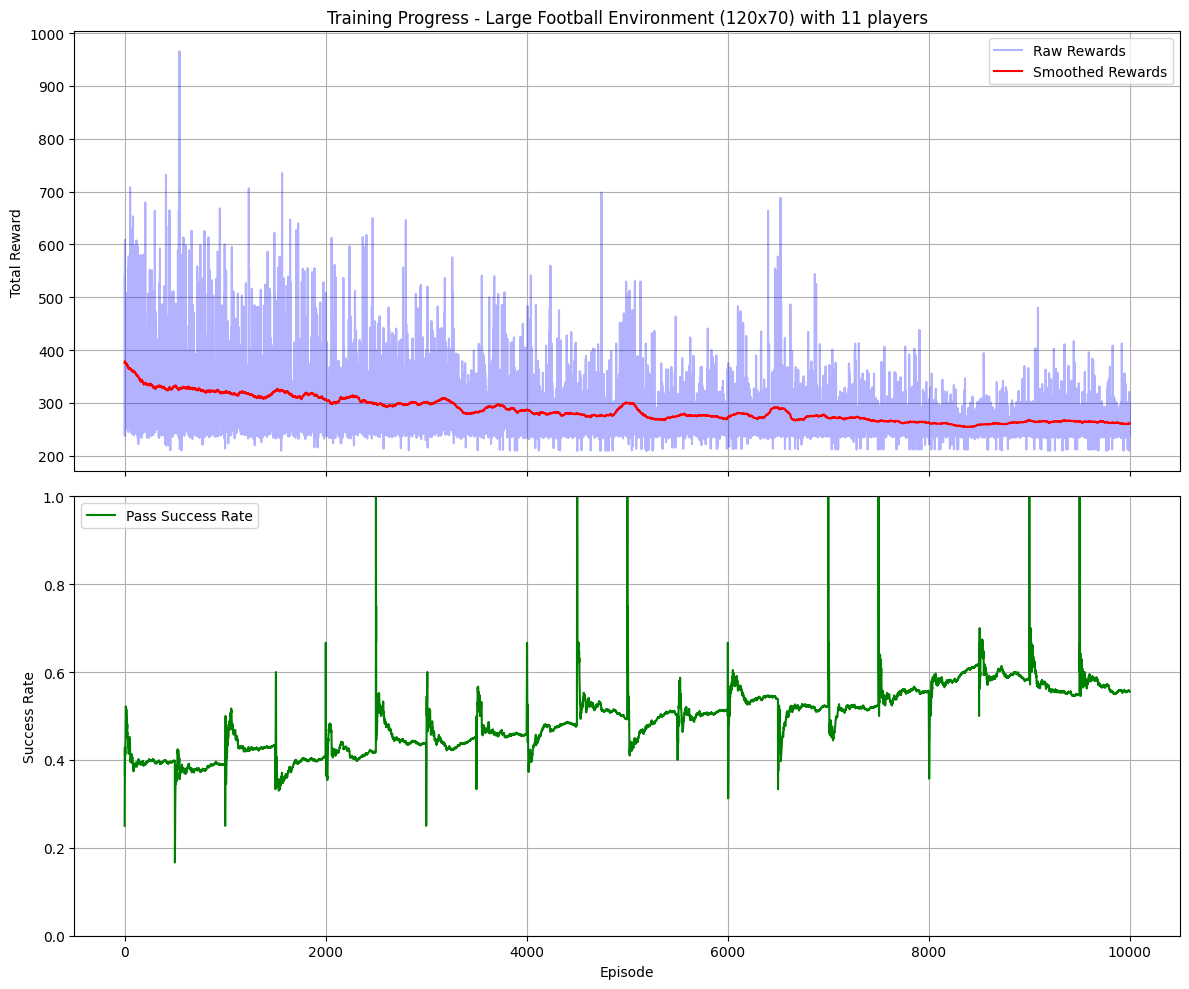


Evaluating agents for 5 episodes on 25x16 field...
Episode 1/5
Ball starting position: [9 6], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibD

Episode 2/5
Ball starting position: [5 7], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibD

Episode 3/5
Ball starting position: [10  6], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibD

Episode 4/5
Ball starting position: [4 7], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibD

Episode 5/5
Ball starting position: [6 7], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\772982082.py:380: MatplotlibD


Evaluation Results:
Average Reward: 255.90
Average Steps per Episode: 8.00
Pass Success Rate: 5/7 (71.4%)
Creating evaluation GIF with 40 frames...
Evaluation GIF saved as 4players_updated.gif


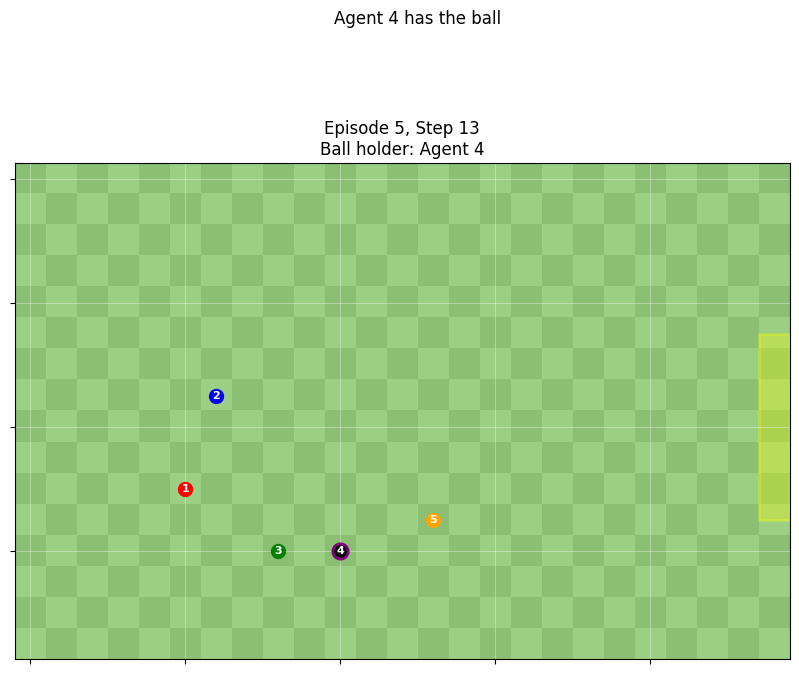

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import time
import gymnasium as gym
from gymnasium import spaces

# Using the previously defined bresenham_line and Agent classes

def train_large_football_system(field_height=70, field_width=120, num_agents=11, episodes=10000, max_steps=1000,
                               learning_rate=0.1, discount_factor=0.95, epsilon_start=0.9, epsilon_end=0.05,
                               print_frequency=500, plot_results=True):
    """
    Train multiple agents in a large football environment using Q-learning.
    
    Args:
        field_height: Height of the football field (70)
        field_width: Width of the football field (120)
        num_agents: Number of agents to train (11)
        episodes: Number of training episodes
        max_steps: Maximum steps per episode
        learning_rate: Learning rate (alpha)
        discount_factor: Discount factor (gamma)
        epsilon_start: Starting exploration rate
        epsilon_end: Final exploration rate
        print_frequency: How often to print progress
        plot_results: Whether to plot learning curves
        
    Returns:
        env: Trained environment with agents
        rewards_history: History of rewards during training
        pass_success_history: History of pass success rates
    """
    # Initialize agents at strategic positions across the field
    agents = []
    
    # Define strategic positions for 5 futsal players
    positions = [
        [field_height // 2, 2],                    # Goalkeeper
        [field_height // 4, field_width // 5],     # Defender left
        [3 * field_height // 4, field_width // 5], # Defender right
        [field_height // 2, field_width // 2],     # Midfielder
        [field_height // 2, 3 * field_width // 5]  # Forward
    ]
    
    for i in range(num_agents):
        agents.append(Agent(field_height, field_width, pos=positions[i]))
    
    # Create environment
    env = FootballEnv(field_height, field_width, agents)
    
    # Modify the reset method of the environment to spawn ball at random positions
    original_reset = env.reset
    
    def random_ball_reset(seed=None, options=None):
        # Call original reset to reset agents
        observations, _, _ = original_reset(seed, options)
        
        # Explicitly place the ball at a random position in the first third of the field
        env.ball_pos = np.array([
            np.random.randint(field_height // 4, 3 * field_height // 4),
            np.random.randint(2, field_width // 3)  # Adjusted for futsal field size
        ])
        
        # No agent starts with the ball
        env.ball_holder = None
        env.ball_in_transit = False
        
        # Check if any agent is already at the ball position
        for i, agent_pos in enumerate(env.agents_positions):
            if np.array_equal(agent_pos, env.ball_pos):
                env.ball_holder = i  # This agent starts with the ball
                break
        
        # Return observations
        observations = [env._get_observation(i) for i in range(len(env.agents))]
        return observations, env.ball_pos, env.ball_holder
    
    # Replace the reset method
    env.reset = random_ball_reset
    
    # Train the agents
    print(f"Starting training with {num_agents} agents on a {field_width}x{field_height} field for {episodes} episodes...")
    print("Ball will spawn at random positions in the defensive third for each episode")
    start_time = time.time()
    
    rewards_history, pass_success_history = env.train(
        episodes=episodes,
        max_steps=max_steps,
        epsilon_start=epsilon_start,
        epsilon_end=epsilon_end,
        gamma=discount_factor,
        alpha=learning_rate,
        print_frequency=print_frequency
    )
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Plot learning curves if requested
    if plot_results:
        plot_training_results(rewards_history, pass_success_history)
    
    return env, rewards_history, pass_success_history

def evaluate_large_football_system(env, num_episodes=5, max_steps=100, render=True, 
                                  output_gif="large_football_evaluation.gif", random_ball=True):
    """
    Evaluate trained agents in the large football environment.
    
    Args:
        env: Trained FootballEnv instance
        num_episodes: Number of evaluation episodes
        max_steps: Maximum steps per episode
        render: Whether to render the environment
        output_gif: Filename for output GIF (if render=True)
        random_ball: Whether to spawn the ball randomly for each episode
        
    Returns:
        metrics: Dictionary with evaluation metrics
    """
    total_rewards = []
    episode_steps = []
    successful_passes = 0
    total_pass_attempts = 0
    
    if render:
        frames = []
        fig, ax = plt.subplots(figsize=(10, 7))  # Smaller figure for futsal field
    
    # If random_ball is True, make sure we're using the modified reset
    if random_ball and not hasattr(env, '_original_reset'):
        # Store the original reset function if not already stored
        env._original_reset = env.reset
        
        def random_ball_reset_eval(seed=None, options=None):
            # Call original reset
            observations, _, _ = env._original_reset(seed, options)
            
            # Place ball at random position in the defensive third
            env.ball_pos = np.array([
                np.random.randint(env.field_height // 4, 3 * env.field_height // 4),
                np.random.randint(5, env.field_width // 3)
            ])
            
            # Check if any agent is at the ball position
            env.ball_holder = None
            for i, agent_pos in enumerate(env.agents_positions):
                if np.array_equal(agent_pos, env.ball_pos):
                    env.ball_holder = i
                    break
            
            # Reset other ball-related attributes
            env.ball_in_transit = False
            env.ball_trajectory = []
            env.ball_trajectory_index = 0
            env.pass_attempts = 0
            env.successful_passes = 0
            
            # Get updated observations
            observations = [env._get_observation(i) for i in range(len(env.agents))]
            return observations, env.ball_pos, env.ball_holder
        
        # Replace reset function for evaluation
        env.reset = random_ball_reset_eval
    
    print(f"\nEvaluating agents for {num_episodes} episodes on {env.field_width}x{env.field_height} field...")
    
    for episode in range(num_episodes):
        observations, _, _ = env.reset()
        episode_reward = 0
        step_count = 0
        done = False
        
        print(f"Episode {episode+1}/{num_episodes}")
        print(f"Ball starting position: {env.ball_pos}, Holder: {env.ball_holder}")
        
        while not done and step_count < max_steps:
            # Use the learned policy (no exploration)
            actions = []
            for i, agent in enumerate(env.agents):
                state = observations[i]
                if state in agent.q_table:
                    actions.append(np.argmax(agent.q_table[state]))
                else:
                    # If state not seen during training, choose a reasonable action
                    if env.ball_holder == i:
                        actions.append(0)  # Move right (toward goal)
                    else:
                        # Move toward the ball
                        agent_pos = env.agents_positions[i]
                        ball_pos = env.ball_pos
                        
                        # Calculate direction vector to ball
                        dx = ball_pos[0] - agent_pos[0]
                        dy = ball_pos[1] - agent_pos[1]
                        
                        # Choose movement action based on direction
                        if abs(dx) > abs(dy):
                            # Prioritize vertical movement
                            if dx > 0:
                                actions.append(2)  # Down
                            else:
                                actions.append(6)  # Up
                        else:
                            # Prioritize horizontal movement
                            if dy > 0:
                                actions.append(0)  # Right
                            else:
                                actions.append(4)  # Left
            
            # Take actions in the environment
            next_observations, rewards, done, _ = env.step(actions)
            
            episode_reward += sum(rewards)
            observations = next_observations
            step_count += 1
            
            # Capture frames for GIF if rendering
            if render:
                frame = render_football_frame(env, ax, fig, episode, step_count)
                frames.append(frame)
            else:
                # Text-based rendering for large field (show area around ball)
                if step_count % 5 == 0:  # Only render every 5 steps to save console space
                    print(f"Step {step_count}:")
                    env.render()
        
        total_rewards.append(episode_reward)
        episode_steps.append(step_count)
        successful_passes += env.successful_passes
        total_pass_attempts += env.pass_attempts
        
        # Add one final frame
        if render and not done:
            frame = render_football_frame(env, ax, fig, episode, step_count, done=True)
            frames.append(frame)
            
            # Add pause between episodes
            for _ in range(10):
                frames.append(frame)
    
    # Calculate evaluation metrics
    avg_reward = sum(total_rewards) / num_episodes if num_episodes > 0 else 0
    avg_steps = sum(episode_steps) / num_episodes if num_episodes > 0 else 0
    pass_success_rate = successful_passes / total_pass_attempts if total_pass_attempts > 0 else 0
    
    print("\nEvaluation Results:")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Average Steps per Episode: {avg_steps:.2f}")
    print(f"Pass Success Rate: {successful_passes}/{total_pass_attempts} ({pass_success_rate*100:.1f}%)")
    
    # Save GIF if rendering
    if render and frames:
        print(f"Creating evaluation GIF with {len(frames)} frames...")
        frames_pil = [Image.fromarray(frame) for frame in frames]
        frames_pil[0].save(
            output_gif,
            save_all=True,
            append_images=frames_pil[1:],
            optimize=False,
            duration=200,  # milliseconds per frame
            loop=0  # 0 means loop forever
        )
        print(f"Evaluation GIF saved as {output_gif}")
    
    # Restore original reset function if we modified it for evaluation
    if random_ball and hasattr(env, '_original_reset'):
        env.reset = env._original_reset
        delattr(env, '_original_reset')
    
    # Return metrics
    metrics = {
        'avg_reward': avg_reward,
        'avg_steps': avg_steps,
        'pass_success_rate': pass_success_rate,
        'total_passes': total_pass_attempts,
        'successful_passes': successful_passes
    }
    
    return metrics

def render_football_frame(env, ax, fig, episode, step, done=False):
    """
    Render a single frame of the football environment.
    
    Args:
        env: Football environment
        ax: Matplotlib axis
        fig: Matplotlib figure
        episode: Current episode number
        step: Current step number
        done: Whether the episode is done
        
    Returns:
        frame: Rendered frame as numpy array
    """
    # Clear the axis
    ax.clear()
    
    # Create a checkerboard pattern for the field
    field_pattern = np.zeros((env.field_height, env.field_width))
    for i in range(env.field_height):
        for j in range(env.field_width):
            field_pattern[i, j] = (i + j) % 2
    
    # Display the field with a green colormap
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(['#8BBF73', '#9BCF83'])  # Light green colors
    ax.imshow(field_pattern, cmap=cmap, origin='upper')
    
    # Add grid - for large fields, don't show all grid lines
    # Show all grid lines for smaller field
    ax.set_xticks(np.arange(0, env.field_width, 5))
    ax.set_yticks(np.arange(0, env.field_height, 4))
    ax.grid(which='major', color='white', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Draw goal area - smaller for futsal
    import matplotlib.patches as patches
    goal_rect = patches.Rectangle((env.goal_y-0.5, env.field_height//2-3), 1, 6, 
                                linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
    ax.add_patch(goal_rect)
    
    # Agent colors for 11 players
    agent_colors = ['red', 'blue', 'green', 'purple', 'orange']
    
    # Plot agents
    for i, pos in enumerate(env.agents_positions):
        agent_label = f"{i+1}"
        if i == env.ball_holder:
            ax.plot(pos[1], pos[0], 'o', markersize=12, color=agent_colors[i % len(agent_colors)], zorder=10)
            ax.plot(pos[1], pos[0], 'o', markersize=8, color='black', zorder=11)  # Ball indicator
        else:
            ax.plot(pos[1], pos[0], 'o', markersize=10, color=agent_colors[i % len(agent_colors)], zorder=10)
        
        ax.text(pos[1], pos[0], agent_label, ha='center', va='center', fontsize=8, 
                color='white', fontweight='bold', zorder=12)
    
    # Plot the ball if it's not with any agent
    if env.ball_holder is None:
        ax.plot(env.ball_pos[1], env.ball_pos[0], 'o', markersize=8, color='black', zorder=11)
    
    # Display ball trajectory if in transit
    if env.ball_in_transit and env.ball_trajectory:
        # Only show remaining trajectory
        remaining_traj = env.ball_trajectory[env.ball_trajectory_index:]
        if remaining_traj:
            traj_x = [p[1] for p in remaining_traj]  # y-coordinate for plotting
            traj_y = [p[0] for p in remaining_traj]  # x-coordinate for plotting
            ax.plot(traj_x, traj_y, 'k--', alpha=0.5, zorder=5)
            # Add arrow to show direction
            if len(traj_x) > 1:
                ax.annotate('', xy=(traj_x[-1], traj_y[-1]), 
                          xytext=(traj_x[0], traj_y[0]),
                          arrowprops=dict(arrowstyle='->', color='black', lw=1.5), zorder=6)
    
    # Add episode/step info
    status = "Complete!" if done else f"Step {step}"
    ax.set_title(f"Episode {episode+1}, {status}\n"
                f"Ball holder: {'None' if env.ball_holder is None else f'Agent {env.ball_holder+1}'}")
    
    # Add caption explaining the current state
    status_text = ""
    if env.ball_in_transit:
        status_text = "Ball in transit"
        if hasattr(env, 'last_passer') and env.last_passer is not None:
            status_text += f" (from Agent {env.last_passer+1})"
    elif env.ball_holder is not None:
        status_text = f"Agent {env.ball_holder+1} has the ball"
    else:
        status_text = "Ball is free"
        
    ax.text(env.field_width/2, -5, status_text, ha='center', fontsize=12)
    
    # Capture the frame
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return frame

def plot_training_results(rewards_history, pass_success_history):
    """
    Plot the training progress metrics.
    
    Args:
        rewards_history: List of episode rewards
        pass_success_history: List of pass success rates
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Smooth the rewards for better visualization
    window_size = min(100, len(rewards_history) // 10)
    if window_size < 1:
        window_size = 1
    
    smoothed_rewards = []
    for i in range(len(rewards_history)):
        start_idx = max(0, i - window_size)
        end_idx = min(len(rewards_history), i + window_size + 1)
        smoothed_rewards.append(sum(rewards_history[start_idx:end_idx]) / (end_idx - start_idx))
    
    episodes = range(1, len(rewards_history) + 1)
    
    # Plot rewards
    ax1.plot(episodes, rewards_history, 'b-', alpha=0.3, label='Raw Rewards')
    ax1.plot(episodes, smoothed_rewards, 'r-', label='Smoothed Rewards')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Training Progress - Large Football Environment (120x70) with 11 players')
    ax1.legend()
    ax1.grid(True)
    
    # Plot pass success rate
    ax2.plot(episodes, pass_success_history, 'g-', label='Pass Success Rate')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Success Rate')
    ax2.set_ylim([0, 1])
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('4player_updated_training_progress.png')
    plt.show()

# Main function to run training and evaluation
def main():
    # Set parameters for futsal field
    field_height = 16
    field_width = 25
    num_agents = 5  # 5 players for futsal
    
    # Training parameters
    training_episodes = 10000  # Reduced from 8000 to balance training time
    max_steps_per_episode = 500  # Increased for larger field
    
    # Train agents
    trained_env, rewards_history, pass_success_history = train_large_football_system(
        field_height=field_height,
        field_width=field_width,
        num_agents=num_agents,
        episodes=training_episodes,
        max_steps=max_steps_per_episode,
        epsilon_start=0.9,
        epsilon_end=0.05,
        print_frequency=500,
        plot_results=True
    )
    
    # Evaluate trained agents
    eval_metrics = evaluate_large_football_system(
        env=trained_env,
        num_episodes=5,
        max_steps=100,
        render=True,
        output_gif="4players_updated.gif",  # Updated filename
        random_ball=True
    )
    
    return trained_env, eval_metrics

if __name__ == "__main__":
    trained_env, eval_metrics = main()

# 11 Player - Updated rewards

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import time
import gymnasium as gym
from gymnasium import spaces

def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    
    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
            
    return points

class Agent:
    def __init__(self, field_height, field_width, pos=None):
        self.field_height = field_height
        self.field_width = field_width
        self.action_space = spaces.Discrete(10)  # 8 moves + pass + stay still
        self.pos = pos
        self.position = np.array(pos) if pos is not None else np.array([
            np.random.randint(0, field_height),
            np.random.randint(0, field_width)
        ])
        self.pass_speed = 6  # Increased pass speed for larger field
        self.pass_speed_decay = 1
        
        # Use dictionary for Q-table to handle complex state representation
        self.q_table = {}
    
    def get_q_value(self, state, action):
        """Get Q-value, initializing to zero if state-action pair not seen before"""
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space.n)
        return self.q_table[state][action]
    
    def update_q_value(self, state, action, value):
        """Update Q-value for a state-action pair"""
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space.n)
        self.q_table[state][action] = value
    
    def policy(self, state, epsilon):
        """Select action using epsilon-greedy policy"""
        if np.random.uniform(0, 1) < epsilon:
            return self.action_space.sample()
        else:
            if state not in self.q_table:
                self.q_table[state] = np.zeros(self.action_space.n)
            return np.argmax(self.q_table[state])

    def reset_position(self):
        if self.pos is None:
            self.position = np.array([
                np.random.randint(0, self.field_height),
                np.random.randint(0, self.field_width)
            ])
        else:
            self.position = np.array(self.pos)
        return self.position

    def pass_ball(self, current_position, target_position):
        """
        Calculate ball trajectory using Bresenham's line algorithm.
        
        :param current_position: Current ball position (x, y)
        :param target_position: Target position for pass (x, y)
        :return: ball trajectory points, initial speed, and direction vector
        """
        # Convert positions to integers for Bresenham algorithm
        start_x, start_y = int(current_position[0]), int(current_position[1])
        target_x, target_y = int(target_position[0]), int(target_position[1])
        
        # Calculate trajectory points using Bresenham's algorithm
        trajectory_points = bresenham_line(start_x, start_y, target_x, target_y)
        
        # Skip the first point (current position)
        if len(trajectory_points) > 1:
            trajectory_points = trajectory_points[1:]
        
        # Calculate direction vector (normalized)
        direction = np.array([target_position[0] - current_position[0], 
                             target_position[1] - current_position[1]])
        direction_norm = np.linalg.norm(direction)
        
        if direction_norm > 0:
            direction = direction / direction_norm
        else:
            direction = np.array([0, 0])
        
        return trajectory_points, self.pass_speed, direction

class FootballEnv(gym.Env):
    def __init__(self, field_height, field_width, agents):
        super(FootballEnv, self).__init__()

        self.field_height = field_height  # x-axis (rows)
        self.field_width = field_width  # y-axis (columns)
        self.goal_y = self.field_width - 1  # Goal at the far right (y-axis)

        # Observation Space: Handled differently with complex state representation
        self.observation_space = spaces.Discrete(field_height * field_width)

        self.field = np.full((self.field_height, self.field_width), '.', dtype=str)
        self.rewards = np.full((self.field_height, self.field_width), -0.1, dtype=np.float32)
        
        self.ball_holder = None  # None: no one has the ball, 0: agent1, 1: agent2
        self.agents = agents
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0
        self.last_passer = None
        self.pass_target = None
        self.pass_attempts = 0
        self.successful_passes = 0
        self.done = False

        self.reset()

    def _get_observation(self, agent_idx):
        """
        Create a comprehensive state representation for an agent that includes:
        - Agent's own position
        - Ball position
        - Ball holder information
        """
        # Calculate individual state features
        agent_pos = self.agents_positions[agent_idx]
        
        # For large fields, we'll use a simplified state representation
        # Encode agent's position relative to the ball rather than absolute position
        ball_rel_x = agent_pos[0] - self.ball_pos[0]
        ball_rel_y = agent_pos[1] - self.ball_pos[1]
        
        # Discretize relative positions to handle large field size
        # Map to ranges like -5 to +5 to keep state space manageable
        ball_rel_x = max(-5, min(5, ball_rel_x))
        ball_rel_y = max(-5, min(5, ball_rel_y))
        
        # Distance to goal (discretized to keep state space manageable)
        goal_dist_x = agent_pos[0] - self.field_height // 2  # Distance to goal center (x-axis)
        goal_dist_y = self.goal_y - agent_pos[1]  # Distance to goal line (y-axis)
        goal_dist_x = max(-5, min(5, goal_dist_x // 10))  # Discretize distance
        goal_dist_y = max(0, min(7, goal_dist_y // 10))  # Discretize distance
        
        # Encode ball holder (add field size to indicate no holder)
        ball_holder_state = -1 if self.ball_holder is None else self.ball_holder
        
        # Encode if ball is in transit
        ball_transit_state = 1 if self.ball_in_transit else 0
        
        # Is this agent the ball holder?
        is_ball_holder = 1 if self.ball_holder == agent_idx else 0
        
        # Combine features into a tuple that can be used as a dictionary key
        state_tuple = (ball_rel_x, ball_rel_y, goal_dist_x, goal_dist_y, 
                       ball_holder_state, ball_transit_state, is_ball_holder)
        
        return state_tuple

    def reset(self, seed=None, options=None):
        self.agents_positions = [agent.reset_position() for agent in self.agents]
        # Center of the field
        self.ball_pos = np.array([self.field_height // 2, self.field_width // 2])
        self.ball_holder = None
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0
        self.last_passer = None
        self.pass_target = None
        self.done = False
        
        # Initial observations
        observations = [self._get_observation(i) for i in range(len(self.agents))]
        
        return observations, self.ball_pos, self.ball_holder

    def closest_pass(self, ball_holder_idx):
        """Find the best agent to pass to based on position and distance"""
        ball_holder_pos = self.agents_positions[ball_holder_idx]
        
        # Calculate distances to all other agents
        distances = []
        for i, agent in enumerate(self.agents):
            if i != ball_holder_idx:
                # Calculate distance
                dist = np.linalg.norm(agent.position - ball_holder_pos)
                
                # Calculate position advantage (prefer agents ahead toward goal)
                position_advantage = 0
                if agent.position[1] > ball_holder_pos[1]:  # Agent is ahead (toward goal)
                    position_advantage = 10  # Strong preference for forward passes
                
                # Calculate score (lower is better - adjust weights as needed)
                score = dist - position_advantage
                
                # Only consider agents at a reasonable passing distance
                # For larger field, increase the reasonable pass distance
                if 5 <= dist <= 20:
                    distances.append((i, score))
        
        # Sort by score and return the best option
        if distances:
            distances.sort(key=lambda x: x[1])
            return distances[0][0]  # Return the index of best agent to pass to
        
        # If no good passing option, find the closest agent as fallback
        closest_idx = -1
        min_dist = float('inf')
        for i, agent in enumerate(self.agents):
            if i != ball_holder_idx:
                dist = np.linalg.norm(agent.position - ball_holder_pos)
                if dist < min_dist:
                    min_dist = dist
                    closest_idx = i
        
        return closest_idx

    def calculate_reward(self, agent_idx, old_position, new_position):
        """Calculate rewards based on game situation and agent actions"""
        reward = 0
        
        # Base small negative reward to encourage efficiency
        reward -= 0.1
        
        # If agent has the ball
        if self.ball_holder == agent_idx:
            # Reward for moving toward the goal (but passing is higher priority)
            if new_position[1] > old_position[1]:  # Moving right toward goal
                reward += 0.5
            
            # Check for potential passing opportunities
            pass_target = self.closest_pass(agent_idx)
            if pass_target != -1:
                target_pos = self.agents_positions[pass_target]
                # If there's a good passing lane, encourage passing
                if 5 <= np.linalg.norm(new_position - target_pos) <= 20:
                    reward += 0.8  # Incentivize moving to positions where passing is good
        
        # If agent doesn't have the ball
        else:
            # If ball is free (no one has it) and not in transit
            if self.ball_holder is None and not self.ball_in_transit:
                # Reward for moving toward the ball
                ball_dist_old = np.linalg.norm(old_position - self.ball_pos)
                ball_dist_new = np.linalg.norm(new_position - self.ball_pos)
                if ball_dist_new < ball_dist_old:
                    reward += 0.7
            
            # If ball is in transit - reward for moving to receive position
            elif self.ball_in_transit:
                # If this agent is the target of a pass
                if self.pass_target == agent_idx:
                    # Reward for moving toward the predicted ball landing point
                    if self.ball_trajectory and self.ball_trajectory_index < len(self.ball_trajectory):
                        target_point = self.ball_trajectory[-1]  # Final point in trajectory
                        target_point = np.array(target_point)
                        
                        old_dist = np.linalg.norm(old_position - target_point)
                        new_dist = np.linalg.norm(new_position - target_point)
                        
                        if new_dist < old_dist:
                            reward += 1.5  # Significant reward for moving to receive position
            
            # If teammate has the ball
            elif self.ball_holder is not None:
                holder_pos = self.agents_positions[self.ball_holder]
                
                # Reward for positioning for a pass
                dist_to_holder = np.linalg.norm(new_position - holder_pos)
                
                # Calculate optimal passing distance range (scaled for larger field)
                if 5 <= dist_to_holder <= 20:
                    reward += 0.5
                    
                    # Bonus for being ahead of ball holder (toward goal)
                    if new_position[1] > holder_pos[1]:
                        reward += 0.7
        
        return reward
    
    def step(self, actions):
        rewards = [0] * len(self.agents)
        
        # Store old positions for reward calculation
        old_positions = [agent.position.copy() for agent in self.agents]

        # Define movement mapping for 8 directions
        move_map = {
            0: np.array([0, 1]),   # Right
            1: np.array([1, 1]),   # Down-Right
            2: np.array([1, 0]),   # Down
            3: np.array([1, -1]),  # Down-Left
            4: np.array([0, -1]),  # Left
            5: np.array([-1, -1]), # Up-Left
            6: np.array([-1, 0]),  # Up
            7: np.array([-1, 1])   # Up-Right
        }

        # Ball in transit logic
        if self.ball_in_transit and self.ball_trajectory:
            steps_to_move = min(self.ball_transit_speed, len(self.ball_trajectory) - self.ball_trajectory_index)

            for _ in range(steps_to_move):
                if self.ball_trajectory_index < len(self.ball_trajectory):
                    next_x, next_y = self.ball_trajectory[self.ball_trajectory_index]
                    self.ball_pos = np.array([next_x, next_y])
                    self.ball_trajectory_index += 1

                    # Check if any agent receives the ball
                    for i, agent in enumerate(self.agents):
                        if np.array_equal(agent.position, self.ball_pos):
                            self.ball_holder = i
                            self.ball_in_transit = False
                            
                            # Significant rewards for successful passes
                            rewards[i] += 50  # Reward for receiving a pass
                            rewards[self.last_passer] += 150  # Major reward for successful pass
                            
                            self.successful_passes += 1
                            
                            # End episode on successful pass
                            self.done = True
                            
                            # Get observations for return
                            observations = [self._get_observation(i) for i in range(len(self.agents))]
                            return observations, rewards, self.done, {}

                else:
                    self.ball_in_transit = False
                    break

            # Apply speed decay
            self.ball_transit_speed = max(0, self.ball_transit_speed - self.agents[0].pass_speed_decay)

            if self.ball_transit_speed == 0 or self.ball_trajectory_index >= len(self.ball_trajectory):
                self.ball_in_transit = False
                # Ball missed - negative reward for passer
                if self.last_passer is not None:
                    rewards[self.last_passer] -= 10  # Penalty for failed pass

        # Agent movements and actions
        for i, action in enumerate(actions):
            agent = self.agents[i]
            
            # Current position before movement
            old_position = agent.position.copy()

            if action in move_map:
                new_position = agent.position + move_map[action]
                new_position[0] = np.clip(new_position[0], 0, self.field_height - 1)
                new_position[1] = np.clip(new_position[1], 0, self.field_width - 1)
                
                # Check if new position overlaps with another agent
                position_valid = True
                for j, other_agent in enumerate(self.agents):
                    if j != i and np.array_equal(new_position, other_agent.position):
                        position_valid = False
                        break
                
                if position_valid:
                    agent.position = new_position
                    self.agents_positions[i] = new_position

                    # If this agent is holding the ball, update ball position
                    if self.ball_holder == i and not self.ball_in_transit:
                        self.ball_pos = new_position.copy()

                    # If agent moves to a position with the ball on the field
                    if not self.ball_in_transit and np.array_equal(agent.position, self.ball_pos) and self.ball_holder is None:
                        self.ball_holder = i
                        rewards[i] += (20)  # Picking up the ball
                
                # Calculate movement-based rewards
                move_reward = self.calculate_reward(i, old_position, agent.position)
                rewards[i] += move_reward

            elif action == 8:  # Passing
                if self.ball_holder == i and not self.ball_in_transit:
                    target_agent_index = self.closest_pass(i)
                    
                    if target_agent_index != -1:  # Valid target found
                        target_position = self.agents[target_agent_index].position
                        trajectory_points, pass_speed, pass_direction = agent.pass_ball(self.ball_pos, target_position)

                        self.ball_trajectory = [(int(x), int(y)) for x, y in trajectory_points]
                        self.ball_trajectory_index = 0

                        self.ball_in_transit = True
                        self.ball_transit_speed = pass_speed
                        self.ball_transit_direction = pass_direction
                        self.last_passer = i  # Store who made the pass
                        self.pass_target = target_agent_index  # Store the intended receiver
                        self.ball_holder = None
                        self.pass_attempts += 1
                        
                        # Small immediate reward for attempting pass
                        rewards[i] += 10

            elif action == 9:  # Stay still
                # Small reward for staying still if waiting to receive a pass
                if self.ball_in_transit and self.pass_target == i:
                    rewards[i] += 0.5

        # Get observations after all actions
        observations = [self._get_observation(i) for i in range(len(self.agents))]
        
        return observations, rewards, self.done, {}

    def train(self, episodes, max_steps, epsilon_start=0.9, epsilon_end=0.1, gamma=0.95, alpha=0.1, print_frequency=100):
        # Epsilon decay
        epsilon_decay = (epsilon_start - epsilon_end) / (episodes * 0.8)  # Decay over 80% of episodes
        epsilon = epsilon_start
        
        episode_rewards_history = []
        pass_success_rate_history = []
        
        for episode in range(episodes):
            # Reset the environment
            observations, _, _ = self.reset()
            
            total_rewards = [0] * len(self.agents)
            done = False
            steps = 0
            
            while not done and steps < max_steps:
                # Select actions using the policy
                actions = [agent.policy(observations[i], epsilon) for i, agent in enumerate(self.agents)]
                
                # Take actions in the environment
                next_observations, rewards, done, _ = self.step(actions)
                
                # Update Q-values using Q-learning
                for i, agent in enumerate(self.agents):
                    # Current Q-value
                    current_q = agent.get_q_value(observations[i], actions[i])
                    
                    # Calculate max future Q-value
                    next_max_q = max([agent.get_q_value(next_observations[i], a) 
                                     for a in range(agent.action_space.n)])
                    
                    # Q-learning update formula
                    new_q = current_q + alpha * (rewards[i] + gamma * next_max_q - current_q)
                    
                    # Update Q-value
                    agent.update_q_value(observations[i], actions[i], new_q)
                    
                    total_rewards[i] += rewards[i]
                
                # Update observations
                observations = next_observations
                steps += 1
            
            # Decay epsilon
            if epsilon > epsilon_end:
                epsilon -= epsilon_decay
            
            # Track metrics
            episode_rewards_history.append(sum(total_rewards))
            
            # Calculate pass success rate if attempts were made
            success_rate = 0
            if self.pass_attempts > 0:
                success_rate = self.successful_passes / self.pass_attempts
            pass_success_rate_history.append(success_rate)
            
            # Print progress
            if (episode + 1) % print_frequency == 0 or episode == episodes - 1:
                print(f"Episode {episode + 1}/{episodes}, "
                      f"Total Rewards: {sum(total_rewards):.1f}, "
                      f"Steps: {steps}, "
                      f"Epsilon: {epsilon:.3f}, "
                      f"Pass Success: {self.successful_passes}/{self.pass_attempts} ({success_rate*100:.1f}%)")
                
                # Reset success counter for next reporting period
                self.pass_attempts = 0
                self.successful_passes = 0
        
        return episode_rewards_history, pass_success_rate_history

    def render(self):
        field_copy = np.full((self.field_height, self.field_width), '.', dtype=str)
        
        # First, place the ball (if it's not held by an agent)
        if self.ball_holder is None:
            field_copy[self.ball_pos[0], self.ball_pos[1]] = 'B'  # (x, y) indexing
        
        # Place agents (will overwrite ball if they're in the same position)
        for i, pos in enumerate(self.agents_positions):
            field_copy[pos[0], pos[1]] = str(i + 1)  # Always just show the agent number
                
        # If ball is in transit, show trajectory
        if self.ball_in_transit:
            for idx, (x, y) in enumerate(self.ball_trajectory):
                if idx >= self.ball_trajectory_index:  # Only show remaining trajectory
                    if 0 <= x < self.field_height and 0 <= y < self.field_width:
                        if field_copy[x, y] == '.':  # Don't overwrite agents
                            field_copy[x, y] = '*'
        
        # For large field, just print a subset around the ball
        ball_x, ball_y = self.ball_pos
        view_range = 15  # View range around the ball
        min_x = max(0, ball_x - view_range)
        max_x = min(self.field_height, ball_x + view_range + 1)
        min_y = max(0, ball_y - view_range)
        max_y = min(self.field_width, ball_y + view_range + 1)
        
        view = field_copy[min_x:max_x, min_y:max_y]
        print(f"Field view around ball position ({ball_x}, {ball_y}):")
        print("\n".join(["".join(row) for row in view]) + "\n")

def render_football_frame(env, ax, fig, episode, step, done=False):
    """
    Render a single frame of the football environment.
    
    Args:
        env: Football environment
        ax: Matplotlib axis
        fig: Matplotlib figure
        episode: Current episode number
        step: Current step number
        done: Whether the episode is done
        
    Returns:
        frame: Rendered frame as numpy array
    """
    # Clear the axis
    ax.clear()
    
    # Create a checkerboard pattern for the field
    field_pattern = np.zeros((env.field_height, env.field_width))
    for i in range(env.field_height):
        for j in range(env.field_width):
            field_pattern[i, j] = (i + j) % 2
    
    # Display the field with a green colormap
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(['#8BBF73', '#9BCF83'])  # Light green colors
    ax.imshow(field_pattern, cmap=cmap, origin='upper')
    
    # Add grid - for large fields, don't show all grid lines
    # Instead, show major grid lines every 10 cells
    ax.set_xticks(np.arange(0, env.field_width, 10))
    ax.set_yticks(np.arange(0, env.field_height, 10))
    ax.grid(which='major', color='white', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Draw goal area
    import matplotlib.patches as patches
    goal_rect = patches.Rectangle((env.goal_y-0.5, env.field_height//2-10), 1, 20, 
                                 linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
    ax.add_patch(goal_rect)
    
    # Agent colors for 11 players (added one more color)
    agent_colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 
                   'magenta', 'brown', 'pink', 'olive', 'darkturquoise']
    
    # Plot agents
    for i, pos in enumerate(env.agents_positions):
        agent_label = f"{i+1}"
        if i == env.ball_holder:
            ax.plot(pos[1], pos[0], 'o', markersize=12, color=agent_colors[i % len(agent_colors)], zorder=10)
            ax.plot(pos[1], pos[0], 'o', markersize=8, color='black', zorder=11)  # Ball indicator
        else:
            ax.plot(pos[1], pos[0], 'o', markersize=10, color=agent_colors[i % len(agent_colors)], zorder=10)
        
        ax.text(pos[1], pos[0], agent_label, ha='center', va='center', fontsize=8, 
                color='white', fontweight='bold', zorder=12)
    
    # Plot the ball if it's not with any agent
    if env.ball_holder is None:
        ax.plot(env.ball_pos[1], env.ball_pos[0], 'o', markersize=8, color='black', zorder=11)
    
    # Display ball trajectory if in transit
    if env.ball_in_transit and env.ball_trajectory:
        # Only show remaining trajectory
        remaining_traj = env.ball_trajectory[env.ball_trajectory_index:]
        if remaining_traj:
            traj_x = [p[1] for p in remaining_traj]  # y-coordinate for plotting
            traj_y = [p[0] for p in remaining_traj]  # x-coordinate for plotting
            ax.plot(traj_x, traj_y, 'k--', alpha=0.5, zorder=5)
            # Add arrow to show direction
            if len(traj_x) > 1:
                ax.annotate('', xy=(traj_x[-1], traj_y[-1]), 
                          xytext=(traj_x[0], traj_y[0]),
                          arrowprops=dict(arrowstyle='->', color='black', lw=1.5), zorder=6)
    
    # Add episode/step info
    status = "Complete!" if done else f"Step {step}"
    ax.set_title(f"Episode {episode+1}, {status}\n"
                f"Ball holder: {'None' if env.ball_holder is None else f'Agent {env.ball_holder+1}'}")
    
    # Add caption explaining the current state
    status_text = ""
    if env.ball_in_transit:
        status_text = "Ball in transit"
        if hasattr(env, 'last_passer') and env.last_passer is not None:
            status_text += f" (from Agent {env.last_passer+1})"
    elif env.ball_holder is not None:
        status_text = f"Agent {env.ball_holder+1} has the ball"
    else:
        status_text = "Ball is free"
        
    ax.text(env.field_width/2, -5, status_text, ha='center', fontsize=12)
    
    # Capture the frame
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return frame

Starting training with 11 agents on a 120x70 field for 5000 episodes...
Ball will spawn at random positions in the defensive third for each episode
Episode 500/5000, Total Rewards: 1484.4, Steps: 435, Epsilon: 0.794, Pass Success: 498/1529 (32.6%)
Episode 1000/5000, Total Rewards: 460.3, Steps: 71, Epsilon: 0.688, Pass Success: 500/1379 (36.3%)
Episode 1500/5000, Total Rewards: 387.5, Steps: 47, Epsilon: 0.581, Pass Success: 500/1426 (35.1%)
Episode 2000/5000, Total Rewards: 384.9, Steps: 56, Epsilon: 0.475, Pass Success: 500/1514 (33.0%)
Episode 2500/5000, Total Rewards: 414.6, Steps: 45, Epsilon: 0.369, Pass Success: 500/1445 (34.6%)
Episode 3000/5000, Total Rewards: 830.8, Steps: 160, Epsilon: 0.263, Pass Success: 500/1423 (35.1%)
Episode 3500/5000, Total Rewards: 435.4, Steps: 50, Epsilon: 0.156, Pass Success: 500/1439 (34.7%)
Episode 4000/5000, Total Rewards: 283.8, Steps: 12, Epsilon: 0.050, Pass Success: 496/1432 (34.6%)
Episode 4500/5000, Total Rewards: 512.7, Steps: 74, Epsilo

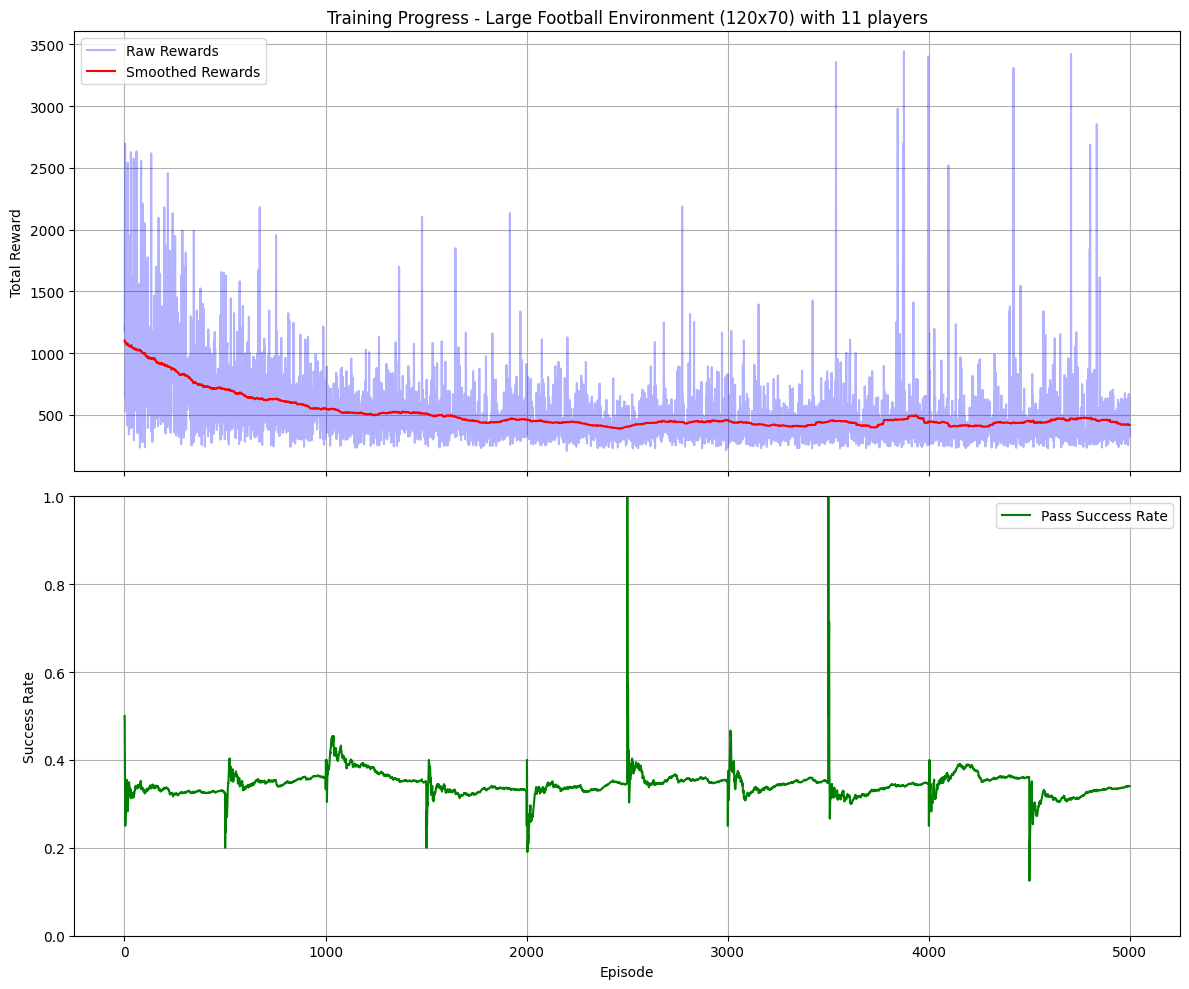


Evaluating agents for 5 episodes on 120x70 field...
Episode 1/5
Ball starting position: [47 12], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: Matplot

Episode 2/5
Ball starting position: [37 25], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: Matplot

Episode 3/5
Ball starting position: [43 19], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: Matplot

Episode 4/5
Ball starting position: [36 15], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: Matplot

Episode 5/5
Ball starting position: [49 36], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1594442919.py:387: Matplot


Evaluation Results:
Average Reward: 405.22
Average Steps per Episode: 28.80
Pass Success Rate: 5/10 (50.0%)
Creating evaluation GIF with 144 frames...
Evaluation GIF saved as trial.gif


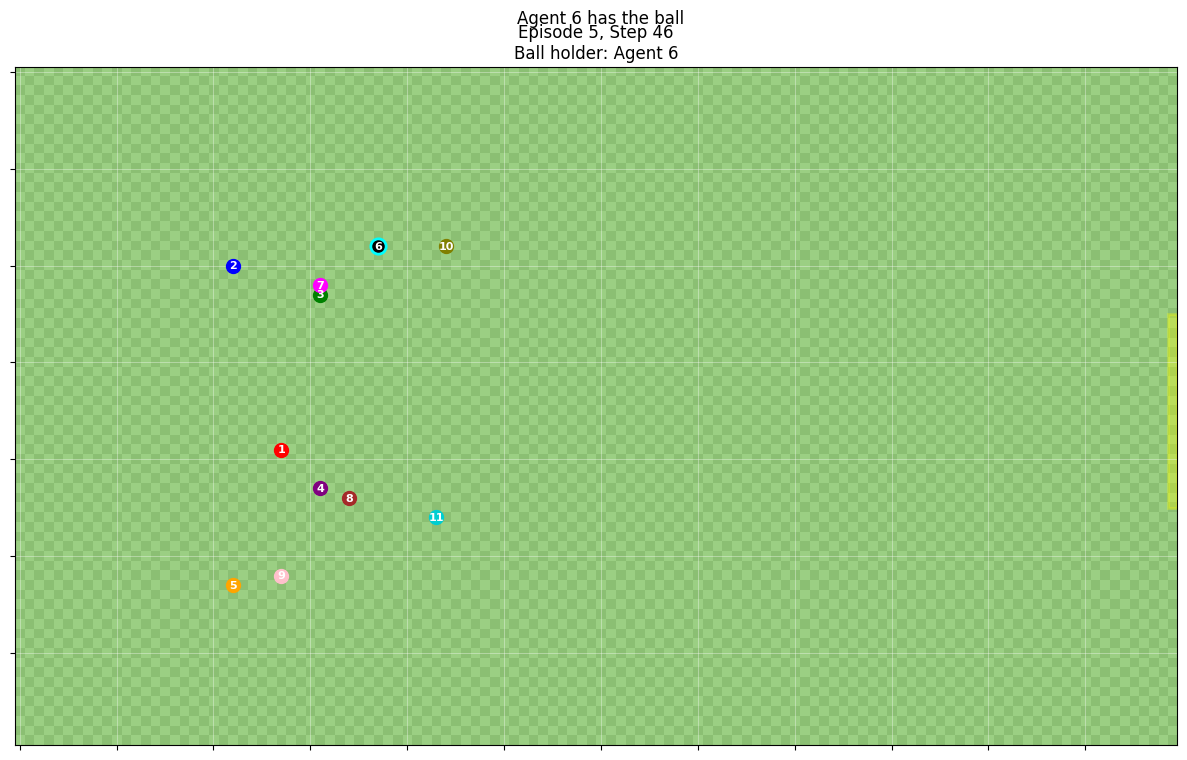

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import time
import gymnasium as gym
from gymnasium import spaces

# Using the previously defined bresenham_line and Agent classes

def train_large_football_system(field_height=70, field_width=120, num_agents=11, episodes=10000, max_steps=1000,
                               learning_rate=0.1, discount_factor=0.95, epsilon_start=0.9, epsilon_end=0.05,
                               print_frequency=500, plot_results=True):
    """
    Train multiple agents in a large football environment using Q-learning.
    
    Args:
        field_height: Height of the football field (70)
        field_width: Width of the football field (120)
        num_agents: Number of agents to train (11)
        episodes: Number of training episodes
        max_steps: Maximum steps per episode
        learning_rate: Learning rate (alpha)
        discount_factor: Discount factor (gamma)
        epsilon_start: Starting exploration rate
        epsilon_end: Final exploration rate
        print_frequency: How often to print progress
        plot_results: Whether to plot learning curves
        
    Returns:
        env: Trained environment with agents
        rewards_history: History of rewards during training
        pass_success_history: History of pass success rates
    """
    # Initialize agents at strategic positions across the field
    agents = []
    
    # Define strategic positions for 11 players - formation 4-4-2
    positions = [
        [field_height // 2, 5],                      # Goalkeeper
        [field_height // 6, field_width // 6],       # Defender left
        [field_height // 3, field_width // 6],       # Defender center-left
        [2 * field_height // 3, field_width // 6],   # Defender center-right
        [5 * field_height // 6, field_width // 6],   # Defender right
        [field_height // 6, field_width // 3],       # Midfielder left
        [field_height // 3, field_width // 3],       # Midfielder center-left
        [2 * field_height // 3, field_width // 3],   # Midfielder center-right
        [5 * field_height // 6, field_width // 3],   # Midfielder right
        [field_height // 3, field_width // 2],       # Forward left
        [2 * field_height // 3, field_width // 2]    # Forward right
    ]
    
    for i in range(num_agents):
        agents.append(Agent(field_height, field_width, pos=positions[i]))
    
    # Create environment
    env = FootballEnv(field_height, field_width, agents)
    
    # Modify the reset method of the environment to spawn ball at random positions
    original_reset = env.reset
    
    def random_ball_reset(seed=None, options=None):
        # Call original reset to reset agents
        observations, _, _ = original_reset(seed, options)
        
        # Explicitly place the ball at a random position in the first third of the field
        env.ball_pos = np.array([
            np.random.randint(field_height // 4, 3 * field_height // 4),
            np.random.randint(5, field_width // 3)
        ])
        
        # No agent starts with the ball
        env.ball_holder = None
        env.ball_in_transit = False
        
        # Check if any agent is already at the ball position
        for i, agent_pos in enumerate(env.agents_positions):
            if np.array_equal(agent_pos, env.ball_pos):
                env.ball_holder = i  # This agent starts with the ball
                break
        
        # Return observations
        observations = [env._get_observation(i) for i in range(len(env.agents))]
        return observations, env.ball_pos, env.ball_holder
    
    # Replace the reset method
    env.reset = random_ball_reset
    
    # Train the agents
    print(f"Starting training with {num_agents} agents on a {field_width}x{field_height} field for {episodes} episodes...")
    print("Ball will spawn at random positions in the defensive third for each episode")
    start_time = time.time()
    
    rewards_history, pass_success_history = env.train(
        episodes=episodes,
        max_steps=max_steps,
        epsilon_start=epsilon_start,
        epsilon_end=epsilon_end,
        gamma=discount_factor,
        alpha=learning_rate,
        print_frequency=print_frequency
    )
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Plot learning curves if requested
    if plot_results:
        plot_training_results(rewards_history, pass_success_history)
    
    return env, rewards_history, pass_success_history

def evaluate_large_football_system(env, num_episodes=5, max_steps=100, render=True, 
                                  output_gif="large_football_evaluation.gif", random_ball=True):
    """
    Evaluate trained agents in the large football environment.
    
    Args:
        env: Trained FootballEnv instance
        num_episodes: Number of evaluation episodes
        max_steps: Maximum steps per episode
        render: Whether to render the environment
        output_gif: Filename for output GIF (if render=True)
        random_ball: Whether to spawn the ball randomly for each episode
        
    Returns:
        metrics: Dictionary with evaluation metrics
    """
    total_rewards = []
    episode_steps = []
    successful_passes = 0
    total_pass_attempts = 0
    
    if render:
        frames = []
        fig, ax = plt.subplots(figsize=(15, 9))  # Larger figure for the bigger field
    
    # If random_ball is True, make sure we're using the modified reset
    if random_ball and not hasattr(env, '_original_reset'):
        # Store the original reset function if not already stored
        env._original_reset = env.reset
        
        def random_ball_reset_eval(seed=None, options=None):
            # Call original reset
            observations, _, _ = env._original_reset(seed, options)
            
            # Place ball at random position in the defensive third
            env.ball_pos = np.array([
                np.random.randint(env.field_height // 4, 3 * env.field_height // 4),
                np.random.randint(5, env.field_width // 3)
            ])
            
            # Check if any agent is at the ball position
            env.ball_holder = None
            for i, agent_pos in enumerate(env.agents_positions):
                if np.array_equal(agent_pos, env.ball_pos):
                    env.ball_holder = i
                    break
            
            # Reset other ball-related attributes
            env.ball_in_transit = False
            env.ball_trajectory = []
            env.ball_trajectory_index = 0
            env.pass_attempts = 0
            env.successful_passes = 0
            
            # Get updated observations
            observations = [env._get_observation(i) for i in range(len(env.agents))]
            return observations, env.ball_pos, env.ball_holder
        
        # Replace reset function for evaluation
        env.reset = random_ball_reset_eval
    
    print(f"\nEvaluating agents for {num_episodes} episodes on {env.field_width}x{env.field_height} field...")
    
    for episode in range(num_episodes):
        observations, _, _ = env.reset()
        episode_reward = 0
        step_count = 0
        done = False
        
        print(f"Episode {episode+1}/{num_episodes}")
        print(f"Ball starting position: {env.ball_pos}, Holder: {env.ball_holder}")
        
        while not done and step_count < max_steps:
            # Use the learned policy (no exploration)
            actions = []
            for i, agent in enumerate(env.agents):
                state = observations[i]
                if state in agent.q_table:
                    actions.append(np.argmax(agent.q_table[state]))
                else:
                    # If state not seen during training, choose a reasonable action
                    if env.ball_holder == i:
                        actions.append(0)  # Move right (toward goal)
                    else:
                        # Move toward the ball
                        agent_pos = env.agents_positions[i]
                        ball_pos = env.ball_pos
                        
                        # Calculate direction vector to ball
                        dx = ball_pos[0] - agent_pos[0]
                        dy = ball_pos[1] - agent_pos[1]
                        
                        # Choose movement action based on direction
                        if abs(dx) > abs(dy):
                            # Prioritize vertical movement
                            if dx > 0:
                                actions.append(2)  # Down
                            else:
                                actions.append(6)  # Up
                        else:
                            # Prioritize horizontal movement
                            if dy > 0:
                                actions.append(0)  # Right
                            else:
                                actions.append(4)  # Left
            
            # Take actions in the environment
            next_observations, rewards, done, _ = env.step(actions)
            
            episode_reward += sum(rewards)
            observations = next_observations
            step_count += 1
            
            # Capture frames for GIF if rendering
            if render:
                frame = render_football_frame(env, ax, fig, episode, step_count)
                frames.append(frame)
            else:
                # Text-based rendering for large field (show area around ball)
                if step_count % 5 == 0:  # Only render every 5 steps to save console space
                    print(f"Step {step_count}:")
                    env.render()
        
        total_rewards.append(episode_reward)
        episode_steps.append(step_count)
        successful_passes += env.successful_passes
        total_pass_attempts += env.pass_attempts
        
        # Add one final frame
        if render and not done:
            frame = render_football_frame(env, ax, fig, episode, step_count, done=True)
            frames.append(frame)
            
            # Add pause between episodes
            for _ in range(10):
                frames.append(frame)
    
    # Calculate evaluation metrics
    avg_reward = sum(total_rewards) / num_episodes if num_episodes > 0 else 0
    avg_steps = sum(episode_steps) / num_episodes if num_episodes > 0 else 0
    pass_success_rate = successful_passes / total_pass_attempts if total_pass_attempts > 0 else 0
    
    print("\nEvaluation Results:")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Average Steps per Episode: {avg_steps:.2f}")
    print(f"Pass Success Rate: {successful_passes}/{total_pass_attempts} ({pass_success_rate*100:.1f}%)")
    
    # Save GIF if rendering
    if render and frames:
        print(f"Creating evaluation GIF with {len(frames)} frames...")
        frames_pil = [Image.fromarray(frame) for frame in frames]
        frames_pil[0].save(
            output_gif,
            save_all=True,
            append_images=frames_pil[1:],
            optimize=False,
            duration=200,  # milliseconds per frame
            loop=0  # 0 means loop forever
        )
        print(f"Evaluation GIF saved as {output_gif}")
    
    # Restore original reset function if we modified it for evaluation
    if random_ball and hasattr(env, '_original_reset'):
        env.reset = env._original_reset
        delattr(env, '_original_reset')
    
    # Return metrics
    metrics = {
        'avg_reward': avg_reward,
        'avg_steps': avg_steps,
        'pass_success_rate': pass_success_rate,
        'total_passes': total_pass_attempts,
        'successful_passes': successful_passes
    }
    
    return metrics

def render_football_frame(env, ax, fig, episode, step, done=False):
    """
    Render a single frame of the football environment.
    
    Args:
        env: Football environment
        ax: Matplotlib axis
        fig: Matplotlib figure
        episode: Current episode number
        step: Current step number
        done: Whether the episode is done
        
    Returns:
        frame: Rendered frame as numpy array
    """
    # Clear the axis
    ax.clear()
    
    # Create a checkerboard pattern for the field
    field_pattern = np.zeros((env.field_height, env.field_width))
    for i in range(env.field_height):
        for j in range(env.field_width):
            field_pattern[i, j] = (i + j) % 2
    
    # Display the field with a green colormap
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(['#8BBF73', '#9BCF83'])  # Light green colors
    ax.imshow(field_pattern, cmap=cmap, origin='upper')
    
    # Add grid - for large fields, don't show all grid lines
    # Instead, show major grid lines every 10 cells
    ax.set_xticks(np.arange(0, env.field_width, 10))
    ax.set_yticks(np.arange(0, env.field_height, 10))
    ax.grid(which='major', color='white', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Draw goal area
    import matplotlib.patches as patches
    goal_rect = patches.Rectangle((env.goal_y-0.5, env.field_height//2-10), 1, 20, 
                                 linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
    ax.add_patch(goal_rect)
    
    # Agent colors for 11 players
    agent_colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 
                   'magenta', 'brown', 'pink', 'olive', 'darkturquoise']
    
    # Plot agents
    for i, pos in enumerate(env.agents_positions):
        agent_label = f"{i+1}"
        if i == env.ball_holder:
            ax.plot(pos[1], pos[0], 'o', markersize=12, color=agent_colors[i % len(agent_colors)], zorder=10)
            ax.plot(pos[1], pos[0], 'o', markersize=8, color='black', zorder=11)  # Ball indicator
        else:
            ax.plot(pos[1], pos[0], 'o', markersize=10, color=agent_colors[i % len(agent_colors)], zorder=10)
        
        ax.text(pos[1], pos[0], agent_label, ha='center', va='center', fontsize=8, 
                color='white', fontweight='bold', zorder=12)
    
    # Plot the ball if it's not with any agent
    if env.ball_holder is None:
        ax.plot(env.ball_pos[1], env.ball_pos[0], 'o', markersize=8, color='black', zorder=11)
    
    # Display ball trajectory if in transit
    if env.ball_in_transit and env.ball_trajectory:
        # Only show remaining trajectory
        remaining_traj = env.ball_trajectory[env.ball_trajectory_index:]
        if remaining_traj:
            traj_x = [p[1] for p in remaining_traj]  # y-coordinate for plotting
            traj_y = [p[0] for p in remaining_traj]  # x-coordinate for plotting
            ax.plot(traj_x, traj_y, 'k--', alpha=0.5, zorder=5)
            # Add arrow to show direction
            if len(traj_x) > 1:
                ax.annotate('', xy=(traj_x[-1], traj_y[-1]), 
                          xytext=(traj_x[0], traj_y[0]),
                          arrowprops=dict(arrowstyle='->', color='black', lw=1.5), zorder=6)
    
    # Add episode/step info
    status = "Complete!" if done else f"Step {step}"
    ax.set_title(f"Episode {episode+1}, {status}\n"
                f"Ball holder: {'None' if env.ball_holder is None else f'Agent {env.ball_holder+1}'}")
    
    # Add caption explaining the current state
    status_text = ""
    if env.ball_in_transit:
        status_text = "Ball in transit"
        if hasattr(env, 'last_passer') and env.last_passer is not None:
            status_text += f" (from Agent {env.last_passer+1})"
    elif env.ball_holder is not None:
        status_text = f"Agent {env.ball_holder+1} has the ball"
    else:
        status_text = "Ball is free"
        
    ax.text(env.field_width/2, -5, status_text, ha='center', fontsize=12)
    
    # Capture the frame
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return frame

def plot_training_results(rewards_history, pass_success_history):
    """
    Plot the training progress metrics.
    
    Args:
        rewards_history: List of episode rewards
        pass_success_history: List of pass success rates
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Smooth the rewards for better visualization
    window_size = min(100, len(rewards_history) // 10)
    if window_size < 1:
        window_size = 1
    
    smoothed_rewards = []
    for i in range(len(rewards_history)):
        start_idx = max(0, i - window_size)
        end_idx = min(len(rewards_history), i + window_size + 1)
        smoothed_rewards.append(sum(rewards_history[start_idx:end_idx]) / (end_idx - start_idx))
    
    episodes = range(1, len(rewards_history) + 1)
    
    # Plot rewards
    ax1.plot(episodes, rewards_history, 'b-', alpha=0.3, label='Raw Rewards')
    ax1.plot(episodes, smoothed_rewards, 'r-', label='Smoothed Rewards')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Training Progress - Large Football Environment (120x70) with 11 players')
    ax1.legend()
    ax1.grid(True)
    
    # Plot pass success rate
    ax2.plot(episodes, pass_success_history, 'g-', label='Pass Success Rate')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Success Rate')
    ax2.set_ylim([0, 1])
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('11player_updated_training_progress.png')
    plt.show()

# Main function to run training and evaluation
def main():
    # Set parameters for large field
    field_height = 70
    field_width = 120
    num_agents = 11  # Updated to 11 players
    
    # Training parameters
    training_episodes = 5000  # Reduced from 8000 to balance training time
    max_steps_per_episode = 1000  # Increased for larger field
    
    # Train agents
    trained_env, rewards_history, pass_success_history = train_large_football_system(
        field_height=field_height,
        field_width=field_width,
        num_agents=num_agents,
        episodes=training_episodes,
        max_steps=max_steps_per_episode,
        epsilon_start=0.9,
        epsilon_end=0.05,
        print_frequency=500,
        plot_results=True
    )
    
    # Evaluate trained agents
    eval_metrics = evaluate_large_football_system(
        env=trained_env,
        num_episodes=5,
        max_steps=150,
        render=True,
        output_gif="11players_updated.gif",  # Updated filename
        random_ball=True
    )
    
    return trained_env, eval_metrics

if __name__ == "__main__":
    trained_env, eval_metrics = main()

# 11 Player - Curriculum learning

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import time
import gymnasium as gym
from gymnasium import spaces

def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    
    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
            
    return points

class Agent:
    def __init__(self, field_height, field_width, pos=None):
        self.field_height = field_height
        self.field_width = field_width
        self.action_space = spaces.Discrete(10)  # 8 moves + pass + stay still
        self.pos = pos
        self.position = np.array(pos) if pos is not None else np.array([
            np.random.randint(0, field_height),
            np.random.randint(0, field_width)
        ])
        self.pass_speed = 6  # Pass speed for larger field
        self.pass_speed_decay = 1
        self.movement_history = []  # To track recent movements
        
        # Use dictionary for Q-table to handle complex state representation
        self.q_table = {}
    
    def get_q_value(self, state, action):
        """Get Q-value, initializing to zero if state-action pair not seen before"""
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space.n)
        return self.q_table[state][action]
    
    def update_q_value(self, state, action, value):
        """Update Q-value for a state-action pair"""
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space.n)
        self.q_table[state][action] = value
    
    def policy(self, state, epsilon):
        """Enhanced epsilon-greedy policy with passing bias"""
        # Random action with probability epsilon
        if np.random.uniform(0, 1) < epsilon:
            return self.action_space.sample()
        
        # Get Q-values for this state
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space.n)
        
        q_values = self.q_table[state].copy()
        
        # Bias toward passing when appropriate conditions are met
        if state[6] == 1:  # If agent is ball holder
            # Check if any teammates are in good passing positions
            if state[7] > 0:  # Using enhanced state representation with teammates in position
                # Boost pass action Q-value
                q_values[8] *= 1.2  # Increase pass action value by 20%
        
        return np.argmax(q_values)

    def reset_position(self):
        if self.pos is None:
            self.position = np.array([
                np.random.randint(0, self.field_height),
                np.random.randint(0, self.field_width)
            ])
        else:
            self.position = np.array(self.pos)
        self.movement_history = []  # Reset movement history
        return self.position

    def update_movement_history(self, old_pos, new_pos):
        """Track agent's recent movement direction"""
        if len(self.movement_history) >= 3:
            self.movement_history.pop(0)
        
        movement = new_pos - old_pos
        if not np.array_equal(movement, np.array([0, 0])):
            self.movement_history.append(movement)

    def predict_movement(self):
        """Predict future movement based on recent history"""
        if not self.movement_history:
            return np.array([0, 0])
        
        # Average recent movement vectors for prediction
        avg_movement = np.mean(self.movement_history, axis=0)
        return avg_movement

    def pass_ball(self, current_position, target_position, target_agent):
        """
        Calculate ball trajectory with improved prediction considering receiver movement.
        
        :param current_position: Current ball position (x, y)
        :param target_position: Target position for pass (x, y)
        :param target_agent: The agent who should receive the pass
        :return: ball trajectory points, initial speed, and direction vector
        """
        # Predict target agent's movement
        predicted_movement = target_agent.predict_movement()
        
        # Calculate anticipated receiver position (with dampening factor)
        anticipated_steps = min(len(self.movement_history) + 2, 5)  # Predict 2-5 steps ahead
        anticipated_target = target_position + (predicted_movement * anticipated_steps * 0.7)  # 0.7 dampening factor
        
        # Ensure anticipated target is within field bounds
        anticipated_target[0] = np.clip(anticipated_target[0], 0, self.field_height - 1)
        anticipated_target[1] = np.clip(anticipated_target[1], 0, self.field_width - 1)
        
        # Convert positions to integers for Bresenham algorithm
        start_x, start_y = int(current_position[0]), int(current_position[1])
        target_x, target_y = int(anticipated_target[0]), int(anticipated_target[1])
        
        # Calculate trajectory points using Bresenham's algorithm
        trajectory_points = bresenham_line(start_x, start_y, target_x, target_y)
        
        # Skip the first point (current position)
        if len(trajectory_points) > 1:
            trajectory_points = trajectory_points[1:]
        
        # Calculate direction vector (normalized)
        direction = np.array([anticipated_target[0] - current_position[0], 
                             anticipated_target[1] - current_position[1]])
        direction_norm = np.linalg.norm(direction)
        
        if direction_norm > 0:
            direction = direction / direction_norm
        else:
            direction = np.array([0, 0])
        
        # Return trajectory, speed, and direction
        return trajectory_points, self.pass_speed, direction

class FootballEnv(gym.Env):
    def __init__(self, field_height, field_width, agents):
        super(FootballEnv, self).__init__()

        self.field_height = field_height  # x-axis (rows)
        self.field_width = field_width  # y-axis (columns)
        self.goal_y = self.field_width - 1  # Goal at the far right (y-axis)

        # Observation Space: Handled differently with complex state representation
        self.observation_space = spaces.Discrete(field_height * field_width)

        self.field = np.full((self.field_height, self.field_width), '.', dtype=str)
        self.rewards = np.full((self.field_height, self.field_width), -0.1, dtype=np.float32)
        
        self.ball_holder = None  # None: no one has the ball, 0: agent1, 1: agent2
        self.agents = agents
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0
        self.last_passer = None
        self.pass_target = None
        self.pass_attempts = 0
        self.successful_passes = 0
        self.done = False
        
        # For curriculum learning
        self.active_agents = list(range(len(agents)))
        self.simplified_defense = False

        self.reset()

    def _get_observation(self, agent_idx):
        """
        Enhanced state representation for an agent that includes:
        - Agent's own position relative to ball
        - Ball position/holder information
        - Teammates in good passing positions
        - Clear passing lane indicator
        """
        # Calculate individual state features
        agent_pos = self.agents_positions[agent_idx]
        
        # For large fields, use a simplified state representation
        # Encode agent's position relative to the ball rather than absolute position
        ball_rel_x = agent_pos[0] - self.ball_pos[0]
        ball_rel_y = agent_pos[1] - self.ball_pos[1]
        
        # Discretize relative positions to handle large field size
        # Map to ranges like -5 to +5 to keep state space manageable
        ball_rel_x = max(-5, min(5, ball_rel_x))
        ball_rel_y = max(-5, min(5, ball_rel_y))
        
        # Distance to goal (discretized to keep state space manageable)
        goal_dist_x = agent_pos[0] - self.field_height // 2  # Distance to goal center (x-axis)
        goal_dist_y = self.goal_y - agent_pos[1]  # Distance to goal line (y-axis)
        goal_dist_x = max(-5, min(5, goal_dist_x // 10))  # Discretize distance
        goal_dist_y = max(0, min(7, goal_dist_y // 10))  # Discretize distance
        
        # Encode ball holder (add field size to indicate no holder)
        ball_holder_state = -1 if self.ball_holder is None else self.ball_holder
        
        # Encode if ball is in transit
        ball_transit_state = 1 if self.ball_in_transit else 0
        
        # Is this agent the ball holder?
        is_ball_holder = 1 if self.ball_holder == agent_idx else 0
        
        # Number of teammates in good passing positions (0-3 scale)
        teammates_in_position = 0
        if is_ball_holder:
            teammates_in_position = self.count_teammates_in_passing_positions(agent_idx)
        
        # Clear passing lane indicator (0/1)
        clear_passing_lane = 0
        if is_ball_holder and teammates_in_position > 0:
            # Find best passing option
            best_receiver = self.closest_pass(agent_idx)
            if best_receiver != -1:
                # Check if passing lane is clear
                clarity = self.calculate_passing_lane_clarity(
                    agent_pos, self.agents_positions[best_receiver])
                clear_passing_lane = 1 if clarity > 0.7 else 0
        
        # Combine features into a tuple that can be used as a dictionary key
        state_tuple = (ball_rel_x, ball_rel_y, goal_dist_x, goal_dist_y, 
                       ball_holder_state, ball_transit_state, is_ball_holder,
                       teammates_in_position, clear_passing_lane)
        
        return state_tuple

    def reset(self, seed=None, options=None):
        self.agents_positions = [agent.reset_position() for agent in self.agents]
        # Center of the field
        self.ball_pos = np.array([self.field_height // 2, self.field_width // 2])
        self.ball_holder = None
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0
        self.last_passer = None
        self.pass_target = None
        self.done = False
        
        # Initial observations
        observations = [self._get_observation(i) for i in range(len(self.agents))]
        
        return observations, self.ball_pos, self.ball_holder

    def count_teammates_in_passing_positions(self, agent_idx):
        """Count how many teammates are in good passing positions"""
        count = 0
        if self.ball_holder != agent_idx:
            return count
            
        holder_pos = self.agents_positions[agent_idx]
        
        for i, agent_pos in enumerate(self.agents_positions):
            if i != agent_idx and i in self.active_agents:
                # Calculate distance
                dist = np.linalg.norm(agent_pos - holder_pos)
                
                # Check if in reasonable passing range
                if 5 <= dist <= 20:
                    # Check position advantage (forward)
                    if agent_pos[1] > holder_pos[1]:
                        # Check space and passing lane
                        space = self.calculate_receiver_space(i)
                        clarity = self.calculate_passing_lane_clarity(holder_pos, agent_pos)
                        
                        # If good position and clear lane, count this agent
                        if space > 0.5 and clarity > 0.5:
                            count += 1
        
        # Cap at 3 for state space management
        return min(count, 3)

    def calculate_passing_lane_clarity(self, start_pos, end_pos):
        """Calculate how clear the passing lane is (0-1 scale)"""
        # Use Bresenham line for trajectory
        trajectory = bresenham_line(int(start_pos[0]), int(start_pos[1]), 
                                int(end_pos[0]), int(end_pos[1]))
        
        # Count how many agents are near the trajectory
        obstacles = 0
        for i, agent_pos in enumerate(self.agents_positions):
            # Skip ball holder and target receiver
            is_target = False
            for j, pos in enumerate(self.agents_positions):
                if np.array_equal(pos, end_pos) and i == j:
                    is_target = True
                    break
                    
            if i != self.ball_holder and not is_target:
                for point in trajectory:
                    dist = np.linalg.norm(np.array(point) - agent_pos)
                    if dist < 2:  # Agent is close to trajectory
                        obstacles += 1
                        break  # Count each agent only once
        
        # Convert to clarity score (0-1)
        clarity = max(0, 1 - (obstacles * 0.15))
        return clarity

    def calculate_receiver_space(self, agent_idx):
        """Calculate how much space a potential receiver has (0-1 scale)"""
        agent_pos = self.agents_positions[agent_idx]
        
        # Check distance to nearest teammate
        min_dist = float('inf')
        for i, pos in enumerate(self.agents_positions):
            if i != agent_idx and i in self.active_agents:
                dist = np.linalg.norm(agent_pos - pos)
                min_dist = min(min_dist, dist)
        
        # Convert to space score (0-1)
        space = min(1.0, min_dist / 10)
        return space

    def calculate_team_spacing(self, agent_idx):
        """Calculate how well an agent is maintaining team formation (0-1 scale)"""
        agent_pos = self.agents_positions[agent_idx]
        
        # Simple implementation: reward for maintaining some distance from teammates
        too_close_count = 0
        for i, pos in enumerate(self.agents_positions):
            if i != agent_idx and i in self.active_agents:
                dist = np.linalg.norm(agent_pos - pos)
                if dist < 5:  # Too close to teammate
                    too_close_count += 1
        
        # Convert to spacing score (0-1)
        spacing = max(0, 1 - (too_close_count * 0.25))
        return spacing

    def closest_pass(self, ball_holder_idx):
        """Find the best agent to pass to based on enhanced criteria"""
        ball_holder_pos = self.agents_positions[ball_holder_idx]
        
        # Calculate scores for potential pass receivers
        pass_scores = []
        for i, agent in enumerate(self.agents):
            if i != ball_holder_idx and i in self.active_agents:
                dist = np.linalg.norm(agent.position - ball_holder_pos)
                
                # Skip if too close or too far
                if dist < 3 or dist > 25:  # Adjusted ranges
                    continue
                    
                # Position advantage (forward passes)
                position_advantage = 0
                if agent.position[1] > ball_holder_pos[1]:
                    # Progressive scale - more forward = better
                    position_advantage = (agent.position[1] - ball_holder_pos[1]) * 0.5
                
                # Check for clear passing lane
                passing_lane_clarity = self.calculate_passing_lane_clarity(
                    ball_holder_pos, agent.position)
                
                # Calculate receiver's space (is he marked?)
                receiver_space = self.calculate_receiver_space(i)
                
                # Combined score (lower is better)
                score = dist - position_advantage - (passing_lane_clarity * 5) - (receiver_space * 3)
                
                pass_scores.append((i, score))
        
        # Return best option if available
        if pass_scores:
            pass_scores.sort(key=lambda x: x[1])
            return pass_scores[0][0]
        
        # If no good passing option, find the closest agent as fallback
        closest_idx = -1
        min_dist = float('inf')
        for i, agent in enumerate(self.agents):
            if i != ball_holder_idx and i in self.active_agents:
                dist = np.linalg.norm(agent.position - ball_holder_pos)
                if dist < min_dist:
                    min_dist = dist
                    closest_idx = i
        
        return closest_idx

    def calculate_reward(self, agent_idx, old_position, new_position):
        """Enhanced reward function with better incentives for passing and team play"""
        reward = 0
        
        # Base small negative reward to encourage efficiency
        reward -= 0.1
        
        # If agent has the ball
        if self.ball_holder == agent_idx:
            # Reward for moving toward the goal
            if new_position[1] > old_position[1]:  # Moving right toward goal
                reward += 0.5
            
            # Check for potential passing opportunities
            pass_target = self.closest_pass(agent_idx)
            if pass_target != -1:
                target_pos = self.agents_positions[pass_target]
                
                # If there's a good passing lane, encourage passing
                passing_lane_clarity = self.calculate_passing_lane_clarity(
                    new_position, target_pos)
                
                if passing_lane_clarity > 0.7:
                    reward += 1.2  # Significant incentive for setting up good passes
                elif passing_lane_clarity > 0.4:
                    reward += 0.8  # Moderate incentive for potential passes
        
        # If agent doesn't have the ball
        else:
            # If ball is free (no one has it) and not in transit
            if self.ball_holder is None and not self.ball_in_transit:
                # Reward for moving toward the ball
                ball_dist_old = np.linalg.norm(old_position - self.ball_pos)
                ball_dist_new = np.linalg.norm(new_position - self.ball_pos)
                if ball_dist_new < ball_dist_old:
                    reward += 0.7
            
            # If ball is in transit - reward for moving to receive position
            elif self.ball_in_transit:
                # If this agent is the target of a pass
                if self.pass_target == agent_idx:
                    # Reward for moving toward the predicted ball landing point
                    if self.ball_trajectory and self.ball_trajectory_index < len(self.ball_trajectory):
                        target_point = self.ball_trajectory[-1]  # Final point in trajectory
                        target_point = np.array(target_point)
                        
                        old_dist = np.linalg.norm(old_position - target_point)
                        new_dist = np.linalg.norm(new_position - target_point)
                        
                        if new_dist < old_dist:
                            reward += 2.0  # Increased reward for moving to receive position
            
            # If teammate has the ball
            elif self.ball_holder is not None:
                holder_pos = self.agents_positions[self.ball_holder]
                
                # Reward for positioning for a pass
                dist_to_holder = np.linalg.norm(new_position - holder_pos)
                
                # Calculate optimal passing distance range
                if 5 <= dist_to_holder <= 20:
                    reward += 0.5
                    
                    # Bonus for being ahead of ball holder (toward goal)
                    if new_position[1] > holder_pos[1]:
                        reward += 0.9  # Increased reward for forward positioning
                        
                    # Bonus for maintaining good spacing from other teammates
                    spacing = self.calculate_team_spacing(agent_idx)
                    reward += spacing * 0.8
        
        return reward
    
    def step(self, actions):
        rewards = [0] * len(self.agents)
        
        # Store old positions for reward calculation and movement history
        old_positions = [agent.position.copy() for agent in self.agents]

        # Define movement mapping for 8 directions
        move_map = {
            0: np.array([0, 1]),   # Right
            1: np.array([1, 1]),   # Down-Right
            2: np.array([1, 0]),   # Down
            3: np.array([1, -1]),  # Down-Left
            4: np.array([0, -1]),  # Left
            5: np.array([-1, -1]), # Up-Left
            6: np.array([-1, 0]),  # Up
            7: np.array([-1, 1])   # Up-Right
        }

        # Ball in transit logic
        if self.ball_in_transit and self.ball_trajectory:
            steps_to_move = min(self.ball_transit_speed, len(self.ball_trajectory) - self.ball_trajectory_index)

            for _ in range(steps_to_move):
                if self.ball_trajectory_index < len(self.ball_trajectory):
                    next_x, next_y = self.ball_trajectory[self.ball_trajectory_index]
                    self.ball_pos = np.array([next_x, next_y])
                    self.ball_trajectory_index += 1

                    # Check if any agent receives the ball
                    for i, agent in enumerate(self.agents):
                        if i in self.active_agents and np.array_equal(agent.position, self.ball_pos):
                            self.ball_holder = i
                            self.ball_in_transit = False
                            
                            # Increased rewards for successful passes
                            rewards[i] += 50  # Increased reward for receiving a pass
                            rewards[self.last_passer] += 150  # Increased reward for successful pass
                            
                            self.successful_passes += 1
                            
                            # End episode on successful pass
                            self.done = True
                            
                            # Get observations for return
                            observations = [self._get_observation(i) for i in range(len(self.agents))]
                            return observations, rewards, self.done, {}

                else:
                    self.ball_in_transit = False
                    break

            # Apply speed decay
            self.ball_transit_speed = max(0, self.ball_transit_speed - self.agents[0].pass_speed_decay)

            if self.ball_transit_speed == 0 or self.ball_trajectory_index >= len(self.ball_trajectory):
                self.ball_in_transit = False
                # Ball missed - reduced negative reward for passer
                if self.last_passer is not None:
                    rewards[self.last_passer] -= 10  # Reduced penalty for failed pass

        # Agent movements and actions
        for i, action in enumerate(actions):
            # Skip inactive agents
            if i not in self.active_agents:
                continue
                
            agent = self.agents[i]
            
            # Current position before movement
            old_position = agent.position.copy()

            if action in move_map:
                new_position = agent.position + move_map[action]
                new_position[0] = np.clip(new_position[0], 0, self.field_height - 1)
                new_position[1] = np.clip(new_position[1], 0, self.field_width - 1)
                
                # Check if new position overlaps with another agent
                position_valid = True
                for j, other_agent in enumerate(self.agents):
                    if j in self.active_agents and j != i and np.array_equal(new_position, other_agent.position):
                        position_valid = False
                        break
                
                if position_valid:
                    agent.position = new_position
                    self.agents_positions[i] = new_position
                    
                    # Update agent's movement history for pass prediction
                    agent.update_movement_history(old_position, new_position)

                    # If this agent is holding the ball, update ball position
                    if self.ball_holder == i and not self.ball_in_transit:
                        self.ball_pos = new_position.copy()

                    # If agent moves to a position with the ball on the field
                    if not self.ball_in_transit and np.array_equal(agent.position, self.ball_pos) and self.ball_holder is None:
                        self.ball_holder = i
                        rewards[i] += 20  # Picking up the ball
                
                # Calculate movement-based rewards
                move_reward = self.calculate_reward(i, old_position, agent.position)
                rewards[i] += move_reward

            elif action == 8:  # Passing
                if self.ball_holder == i and not self.ball_in_transit:
                    target_agent_index = self.closest_pass(i)
                    
                    if target_agent_index != -1:  # Valid target found
                        target_agent = self.agents[target_agent_index]
                        target_position = target_agent.position
                        
                        # Use improved pass_ball method with target agent prediction
                        trajectory_points, pass_speed, pass_direction = agent.pass_ball(
                            self.ball_pos, target_position, target_agent)

                        self.ball_trajectory = [(int(x), int(y)) for x, y in trajectory_points]
                        self.ball_trajectory_index = 0

                        self.ball_in_transit = True
                        self.ball_transit_speed = pass_speed
                        self.ball_transit_direction = pass_direction
                        self.last_passer = i  # Store who made the pass
                        self.pass_target = target_agent_index  # Store the intended receiver
                        self.ball_holder = None
                        self.pass_attempts += 1
                        
                        # Increased immediate reward for attempting pass
                        rewards[i] += 15  # Increased from 10

            elif action == 9:  # Stay still
                # Small reward for staying still if waiting to receive a pass
                if self.ball_in_transit and self.pass_target == i:
                    rewards[i] += 0.8  # Increased from 0.5

        # Get observations after all actions
        observations = [self._get_observation(i) for i in range(len(self.agents))]
        
        return observations, rewards, self.done, {}

    # Curriculum learning methods
    def enable_only_two_agents(self):
        """Enable only two agents for simple passing practice"""
        self.active_agents = [0, 1]  # First two agents
    
    def enable_subset_of_agents(self, num_agents):
        """Enable a subset of agents"""
        self.active_agents = list(range(min(num_agents, len(self.agents))))
    
    def enable_all_agents(self, simplified_defense=False):
        """Enable all agents, optionally with simplified defense logic"""
        self.active_agents = list(range(len(self.agents)))
        self.simplified_defense = simplified_defense

    def train_with_curriculum(self, total_episodes, max_steps, epsilon_start=0.9, 
                             epsilon_end=0.1, gamma=0.95, alpha=0.1, print_frequency=100):
        """Implement curriculum learning for training"""
        print("Starting curriculum learning...")
        rewards_history = []
        pass_success_history = []
        
        # Phase 1: Just 2 agents passing (first 20% of episodes)
        print("\nPhase 1: Two-agent passing practice")
        self.enable_only_two_agents()
        phase1_episodes = int(total_episodes * 0.2)
        phase1_rewards, phase1_success = self.train(
            episodes=phase1_episodes, 
            max_steps=max_steps,
            epsilon_start=epsilon_start,
            epsilon_end=epsilon_start * 0.8,  # Gradual epsilon reduction
            gamma=gamma,
            alpha=alpha,
            print_frequency=print_frequency
        )
        rewards_history.extend(phase1_rewards)
        pass_success_history.extend(phase1_success)
        
        # Phase 2: Small group passing practice (next 30%)
        print("\nPhase 2: Small group passing practice")
        self.enable_subset_of_agents(5)
        phase2_episodes = int(total_episodes * 0.3)
        phase2_rewards, phase2_success = self.train(
            episodes=phase2_episodes, 
            max_steps=max_steps,
            epsilon_start=epsilon_start * 0.8,
            epsilon_end=epsilon_start * 0.6,
            gamma=gamma,
            alpha=alpha,
            print_frequency=print_frequency
        )
        rewards_history.extend(phase2_rewards)
        pass_success_history.extend(phase2_success)
        
        # Phase 3: Full team with simplified defense (next 20%)
        print("\nPhase 3: Full team with simplified defensive positioning")
        self.enable_all_agents(simplified_defense=True)
        phase3_episodes = int(total_episodes * 0.2)
        phase3_rewards, phase3_success = self.train(
            episodes=phase3_episodes, 
            max_steps=max_steps,
            epsilon_start=epsilon_start * 0.6,
            epsilon_end=epsilon_start * 0.3,
            gamma=gamma,
            alpha=alpha,
            print_frequency=print_frequency
        )
        rewards_history.extend(phase3_rewards)
        pass_success_history.extend(phase3_success)
        
        # Phase 4: Full gameplay (remaining 30%)
        print("\nPhase 4: Full gameplay")
        self.enable_all_agents(simplified_defense=False)
        phase4_episodes = total_episodes - (phase1_episodes + phase2_episodes + phase3_episodes)
        phase4_rewards, phase4_success = self.train(
            episodes=phase4_episodes, 
            max_steps=max_steps,
            epsilon_start=epsilon_start * 0.3,
            epsilon_end=epsilon_end,
            gamma=gamma,
            alpha=alpha,
            print_frequency=print_frequency
        )
        rewards_history.extend(phase4_rewards)
        pass_success_history.extend(phase4_success)
        
        print("Curriculum training complete!")
        return rewards_history, pass_success_history

    def train(self, episodes, max_steps, epsilon_start=0.9, epsilon_end=0.1, gamma=0.95, alpha=0.1, print_frequency=100):
        """
        Train agents using Q-learning.
        
        Args:
            episodes: Number of training episodes
            max_steps: Maximum steps per episode
            epsilon_start: Starting exploration rate
            epsilon_end: Final exploration rate
            gamma: Discount factor
            alpha: Learning rate
            print_frequency: How often to print progress
            
        Returns:
            rewards_history: List of episode rewards
            pass_success_history: List of pass success rates
        """
        rewards_history = []
        pass_success_history = []
        
        # Calculate epsilon decay rate
        epsilon_decay = (epsilon_start - epsilon_end) / episodes
        epsilon = epsilon_start
        
        for episode in range(1, episodes + 1):
            observations, _, _ = self.reset()
            episode_rewards = 0
            
            for step in range(max_steps):
                # Choose actions using epsilon-greedy policy
                actions = []
                for i, agent in enumerate(self.agents):
                    if i in self.active_agents:
                        actions.append(agent.policy(observations[i], epsilon))
                    else:
                        actions.append(9)  # Inactive agents stay still
                
                # Take actions
                next_observations, rewards, done, _ = self.step(actions)
                
                # Update Q-values
                for i, agent in enumerate(self.agents):
                    if i in self.active_agents:
                        state = observations[i]
                        action = actions[i]
                        next_state = next_observations[i]
                        reward = rewards[i]
                        
                        # Get current Q-value
                        current_q = agent.get_q_value(state, action)
                        
                        # Get max Q-value for next state
                        if next_state in agent.q_table:
                            next_max_q = np.max(agent.q_table[next_state])
                        else:
                            next_max_q = 0
                        
                        # Q-learning update
                        new_q = current_q + alpha * (reward + gamma * next_max_q - current_q)
                        agent.update_q_value(state, action, new_q)
                
                # Track rewards
                episode_rewards += sum(rewards)
                
                # Update observations
                observations = next_observations
                
                # Break if episode is done
                if done:
                    break
            
            # Reduce epsilon
            epsilon = max(epsilon_end, epsilon - epsilon_decay)
            
            # Track statistics
            rewards_history.append(episode_rewards)
            
            # Calculate pass success rate for this episode
            pass_success_rate = 0
            if self.pass_attempts > 0:
                pass_success_rate = self.successful_passes / self.pass_attempts
            pass_success_history.append(pass_success_rate)
            
            # Print progress
            if episode % print_frequency == 0:
                print(f"Episode {episode}/{episodes}, "
                    f"Rewards: {episode_rewards:.2f}, "
                    f"Pass Success: {self.successful_passes}/{self.pass_attempts} "
                    f"({pass_success_rate*100:.1f}%), "
                    f"Epsilon: {epsilon:.3f}")
        
        return rewards_history, pass_success_history

    def render(self):
        """
        Print a text-based representation of the environment showing agents and ball.
        For large fields, only show the area around the ball.
        """
        # Create a view window around the ball
        view_size = 15  # Size of the view window around the ball
        ball_x, ball_y = int(self.ball_pos[0]), int(self.ball_pos[1])
        
        # Calculate view boundaries
        view_min_x = max(0, ball_x - view_size // 2)
        view_max_x = min(self.field_height, ball_x + view_size // 2 + 1)
        view_min_y = max(0, ball_y - view_size // 2)
        view_max_y = min(self.field_width, ball_y + view_size // 2 + 1)
        
        # Create and fill the view field
        view_field = np.full((view_max_x - view_min_x, view_max_y - view_min_y), '.', dtype=str)
        
        # Mark the goal
        if view_min_y <= self.goal_y <= view_max_y:
            goal_y_rel = self.goal_y - view_min_y
            for x_rel in range(view_max_x - view_min_x):
                view_field[x_rel, goal_y_rel] = '|'
        
        # Mark agents on the field
        for i, pos in enumerate(self.agents_positions):
            agent_x, agent_y = int(pos[0]), int(pos[1])
            if view_min_x <= agent_x < view_max_x and view_min_y <= agent_y < view_max_y:
                agent_x_rel = agent_x - view_min_x
                agent_y_rel = agent_y - view_min_y
                
                if i == self.ball_holder:
                    view_field[agent_x_rel, agent_y_rel] = str(i+1) + "B"  # Agent with ball
                else:
                    view_field[agent_x_rel, agent_y_rel] = str(i+1)  # Agent number
        
        # Mark ball if it's not with any agent
        if self.ball_holder is None and view_min_x <= ball_x < view_max_x and view_min_y <= ball_y < view_max_y:
            ball_x_rel = ball_x - view_min_x
            ball_y_rel = ball_y - view_min_y
            view_field[ball_x_rel, ball_y_rel] = 'O'  # Ball
        
        # Display the field with coordinates
        print(f"\nField view around ball position ({ball_x}, {ball_y}):")
        print(f"X range: {view_min_x} to {view_max_x-1}, Y range: {view_min_y} to {view_max_y-1}")
        print("   " + "".join([f"{y%10}" for y in range(view_min_y, view_max_y)]))
        
        for i in range(view_max_x - view_min_x):
            print(f"{(i+view_min_x)%10}: ", end="")
            for j in range(view_max_y - view_min_y):
                print(view_field[i, j], end="")
            print()
        
        # Print status info
        if self.ball_holder is not None:
            print(f"Ball held by Agent {self.ball_holder+1}")
        elif self.ball_in_transit:
            print(f"Ball in transit from Agent {self.last_passer+1}")
        else:
            print("Ball is free")
    

Starting football simulation training and evaluation system...
Configuration: Field size: 120x70, Agents: 11
Training episodes: 5000, Max steps per episode: 1000
Starting training with 11 agents on a 120x70 field...
Using curriculum learning for improved pass rate
Starting curriculum learning...

Phase 1: Two-agent passing practice
Episode 500/1000, Rewards: 623.40, Pass Success: 257/2411 (10.7%), Epsilon: 0.810
Episode 1000/1000, Rewards: 724.10, Pass Success: 730/6186 (11.8%), Epsilon: 0.720

Phase 2: Small group passing practice
Episode 500/1500, Rewards: 409.80, Pass Success: 1224/9732 (12.6%), Epsilon: 0.660
Episode 1000/1500, Rewards: 532.20, Pass Success: 1722/13361 (12.9%), Epsilon: 0.600
Episode 1500/1500, Rewards: 595.40, Pass Success: 2219/16819 (13.2%), Epsilon: 0.540

Phase 3: Full team with simplified defensive positioning
Episode 500/1000, Rewards: 473.10, Pass Success: 2718/19865 (13.7%), Epsilon: 0.405
Episode 1000/1000, Rewards: 497.00, Pass Success: 3217/23296 (13.8%

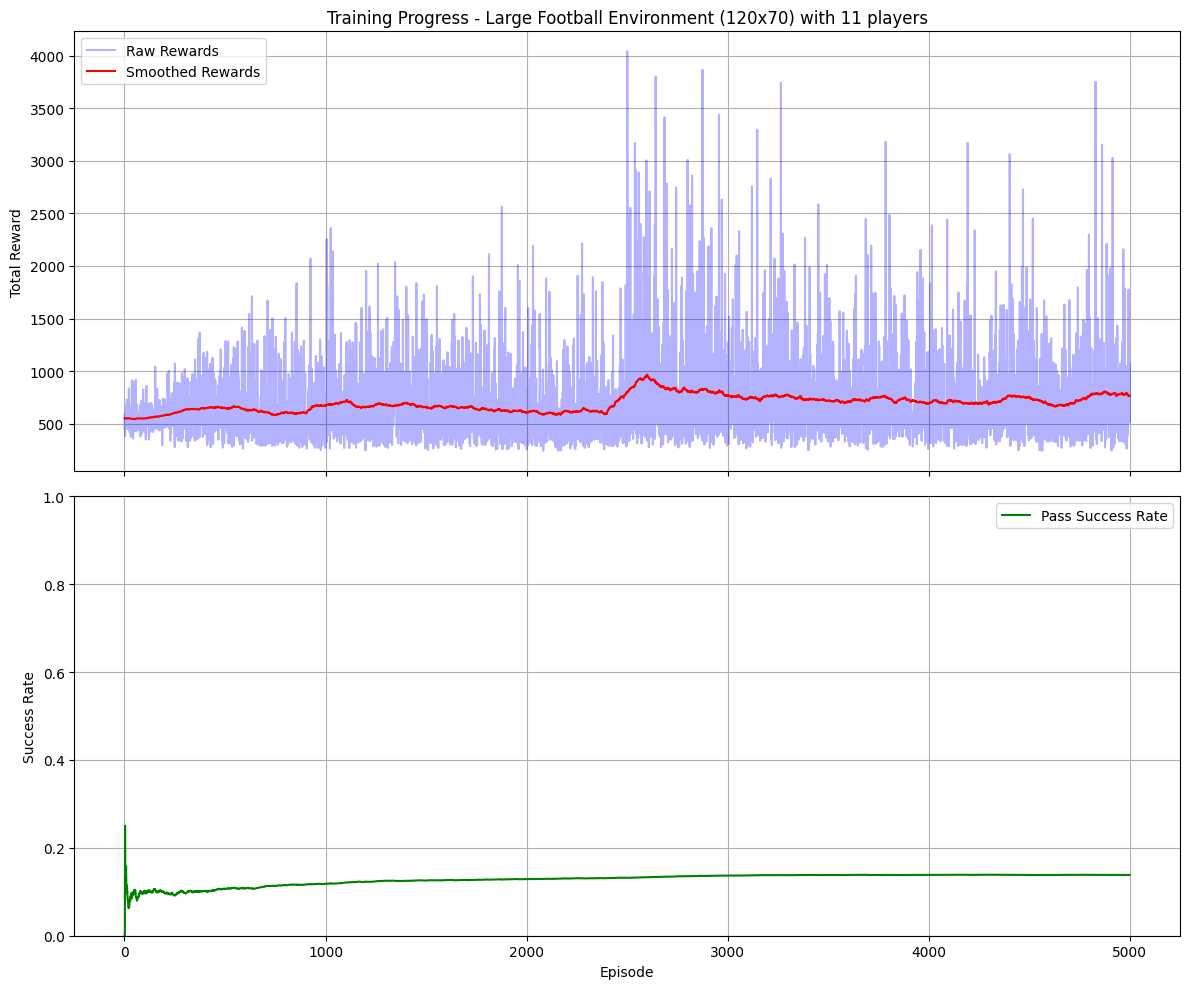


Evaluating agents for 5 episodes on 120x70 field...
Episode 1/5
Ball starting position: [36 30], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: Matplot

Episode 2/5
Ball starting position: [23 33], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: Matplot

Episode 3/5
Ball starting position: [17 10], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: Matplot

Episode 4/5
Ball starting position: [23 14], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: Matplot

Episode 5/5
Ball starting position: [32 16], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_23188\1694516700.py:401: Matplot


Evaluation Results:
Average Reward: 790.46
Average Steps per Episode: 87.00
Pass Success Rate: 4/47 (8.5%)
Creating evaluation GIF with 446 frames...
Evaluation GIF saved as 11agents_curriculum.gif

Final Evaluation Metrics:
avg_reward: 790.46
avg_steps: 87.0
pass_success_rate: 8.51%
total_passes: 47
successful_passes: 4

Training and evaluation complete!


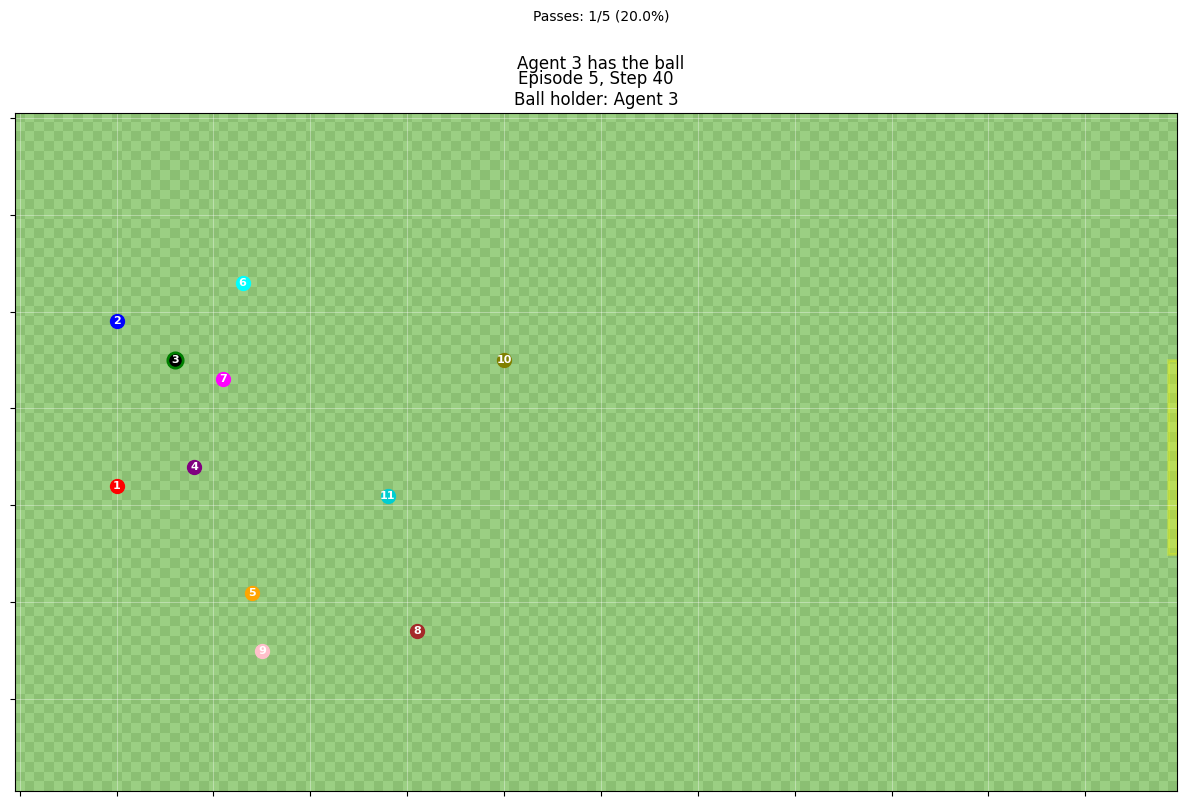

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import time

def train_large_football_system(field_height=70, field_width=120, num_agents=11, episodes=10000, max_steps=1000,
                               learning_rate=0.1, discount_factor=0.95, epsilon_start=0.9, epsilon_end=0.05,
                               print_frequency=500, plot_results=True):
    """
    Train multiple agents in a large football environment using Q-learning.
    
    Args:
        field_height: Height of the football field (70)
        field_width: Width of the football field (120)
        num_agents: Number of agents to train (11)
        episodes: Number of training episodes
        max_steps: Maximum steps per episode
        learning_rate: Learning rate (alpha)
        discount_factor: Discount factor (gamma)
        epsilon_start: Starting exploration rate
        epsilon_end: Final exploration rate
        print_frequency: How often to print progress
        plot_results: Whether to plot learning curves
        
    Returns:
        env: Trained environment with agents
        rewards_history: History of rewards during training
        pass_success_history: History of pass success rates
    """
    # Initialize agents at strategic positions across the field
    agents = []
    
    # Define strategic positions for 11 players - formation 4-4-2
    positions = [
        [field_height // 2, 5],                      # Goalkeeper
        [field_height // 6, field_width // 6],       # Defender left
        [field_height // 3, field_width // 6],       # Defender center-left
        [2 * field_height // 3, field_width // 6],   # Defender center-right
        [5 * field_height // 6, field_width // 6],   # Defender right
        [field_height // 6, field_width // 3],       # Midfielder left
        [field_height // 3, field_width // 3],       # Midfielder center-left
        [2 * field_height // 3, field_width // 3],   # Midfielder center-right
        [5 * field_height // 6, field_width // 3],   # Midfielder right
        [field_height // 3, field_width // 2],       # Forward left
        [2 * field_height // 3, field_width // 2]    # Forward right
    ]
    
    for i in range(num_agents):
        if i < len(positions):
            agents.append(Agent(field_height, field_width, pos=positions[i]))
        else:
            agents.append(Agent(field_height, field_width))
    
    # Create environment
    env = FootballEnv(field_height, field_width, agents)
    
    # Modify the reset method of the environment to spawn ball at random positions
    original_reset = env.reset
    
    def random_ball_reset(seed=None, options=None):
        # Call original reset to reset agents
        observations, _, _ = original_reset(seed, options)
        
        # Explicitly place the ball at a random position in the first third of the field
        env.ball_pos = np.array([
            np.random.randint(field_height // 4, 3 * field_height // 4),
            np.random.randint(5, field_width // 3)
        ])
        
        # No agent starts with the ball
        env.ball_holder = None
        env.ball_in_transit = False
        
        # Check if any agent is already at the ball position
        for i, agent_pos in enumerate(env.agents_positions):
            if np.array_equal(agent_pos, env.ball_pos):
                env.ball_holder = i  # This agent starts with the ball
                break
        
        # Return observations
        observations = [env._get_observation(i) for i in range(len(env.agents))]
        return observations, env.ball_pos, env.ball_holder
    
    # Replace the reset method
    env.reset = random_ball_reset
    
    # Train the agents using curriculum learning
    print(f"Starting training with {num_agents} agents on a {field_width}x{field_height} field...")
    print("Using curriculum learning for improved pass rate")
    start_time = time.time()
    
    rewards_history, pass_success_history = env.train_with_curriculum(
        total_episodes=episodes,
        max_steps=max_steps,
        epsilon_start=epsilon_start,
        epsilon_end=epsilon_end,
        gamma=discount_factor,
        alpha=learning_rate,
        print_frequency=print_frequency
    )
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Plot learning curves if requested
    if plot_results:
        plot_training_results(rewards_history, pass_success_history)
    
    return env, rewards_history, pass_success_history

def evaluate_large_football_system(env, num_episodes=5, max_steps=100, render=True, 
                                  output_gif="large_football_evaluation.gif", random_ball=True):
    """
    Evaluate trained agents in the large football environment.
    
    Args:
        env: Trained FootballEnv instance
        num_episodes: Number of evaluation episodes
        max_steps: Maximum steps per episode
        render: Whether to render the environment
        output_gif: Filename for output GIF (if render=True)
        random_ball: Whether to spawn the ball randomly for each episode
        
    Returns:
        metrics: Dictionary with evaluation metrics
    """
    total_rewards = []
    episode_steps = []
    successful_passes = 0
    total_pass_attempts = 0
    
    if render:
        frames = []
        fig, ax = plt.subplots(figsize=(15, 9))  # Larger figure for the bigger field
    
    # If random_ball is True, make sure we're using the modified reset
    if random_ball and not hasattr(env, '_original_reset'):
        # Store the original reset function if not already stored
        env._original_reset = env.reset
        
        def random_ball_reset_eval(seed=None, options=None):
            # Call original reset
            observations, _, _ = env._original_reset(seed, options)
            
            # Place ball at random position in the defensive third
            env.ball_pos = np.array([
                np.random.randint(env.field_height // 4, 3 * env.field_height // 4),
                np.random.randint(5, env.field_width // 3)
            ])
            
            # Check if any agent is at the ball position
            env.ball_holder = None
            for i, agent_pos in enumerate(env.agents_positions):
                if np.array_equal(agent_pos, env.ball_pos):
                    env.ball_holder = i
                    break
            
            # Reset other ball-related attributes
            env.ball_in_transit = False
            env.ball_trajectory = []
            env.ball_trajectory_index = 0
            env.pass_attempts = 0
            env.successful_passes = 0
            
            # Get updated observations
            observations = [env._get_observation(i) for i in range(len(env.agents))]
            return observations, env.ball_pos, env.ball_holder
        
        # Replace reset function for evaluation
        env.reset = random_ball_reset_eval
    
    print(f"\nEvaluating agents for {num_episodes} episodes on {env.field_width}x{env.field_height} field...")
    
    for episode in range(num_episodes):
        observations, _, _ = env.reset()
        episode_reward = 0
        step_count = 0
        done = False
        
        print(f"Episode {episode+1}/{num_episodes}")
        print(f"Ball starting position: {env.ball_pos}, Holder: {env.ball_holder}")
        
        while not done and step_count < max_steps:
            # Use the learned policy (no exploration)
            actions = []
            for i, agent in enumerate(env.agents):
                if i in env.active_agents:
                    state = observations[i]
                    if state in agent.q_table:
                        actions.append(np.argmax(agent.q_table[state]))
                    else:
                        # If state not seen during training, choose a reasonable action
                        if env.ball_holder == i:
                            actions.append(0)  # Move right (toward goal)
                        else:
                            # Move toward the ball
                            agent_pos = env.agents_positions[i]
                            ball_pos = env.ball_pos
                            
                            # Calculate direction vector to ball
                            dx = ball_pos[0] - agent_pos[0]
                            dy = ball_pos[1] - agent_pos[1]
                            
                            # Choose movement action based on direction
                            if abs(dx) > abs(dy):
                                # Prioritize vertical movement
                                if dx > 0:
                                    actions.append(2)  # Down
                                else:
                                    actions.append(6)  # Up
                            else:
                                # Prioritize horizontal movement
                                if dy > 0:
                                    actions.append(0)  # Right
                                else:
                                    actions.append(4)  # Left
                else:
                    # Inactive agents stay still
                    actions.append(9)
            
            # Take actions in the environment
            next_observations, rewards, done, _ = env.step(actions)
            
            episode_reward += sum(rewards)
            observations = next_observations
            step_count += 1
            
            # Capture frames for GIF if rendering
            if render:
                frame = render_football_frame(env, ax, fig, episode, step_count)
                frames.append(frame)
            else:
                # Text-based rendering for large field (show area around ball)
                if step_count % 5 == 0:  # Only render every 5 steps to save console space
                    print(f"Step {step_count}:")
                    env.render()
        
        total_rewards.append(episode_reward)
        episode_steps.append(step_count)
        successful_passes += env.successful_passes
        total_pass_attempts += env.pass_attempts
        
        # Add one final frame
        if render and not done:
            frame = render_football_frame(env, ax, fig, episode, step_count, done=True)
            frames.append(frame)
            
            # Add pause between episodes
            for _ in range(10):
                frames.append(frame)
    
    # Calculate evaluation metrics
    avg_reward = sum(total_rewards) / num_episodes if num_episodes > 0 else 0
    avg_steps = sum(episode_steps) / num_episodes if num_episodes > 0 else 0
    pass_success_rate = successful_passes / total_pass_attempts if total_pass_attempts > 0 else 0
    
    print("\nEvaluation Results:")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Average Steps per Episode: {avg_steps:.2f}")
    print(f"Pass Success Rate: {successful_passes}/{total_pass_attempts} ({pass_success_rate*100:.1f}%)")
    
    # Save GIF if rendering
    if render and frames:
        print(f"Creating evaluation GIF with {len(frames)} frames...")
        frames_pil = [Image.fromarray(frame) for frame in frames]
        frames_pil[0].save(
            output_gif,
            save_all=True,
            append_images=frames_pil[1:],
            optimize=False,
            duration=200,  # milliseconds per frame
            loop=0  # 0 means loop forever
        )
        print(f"Evaluation GIF saved as {output_gif}")
    
    # Restore original reset function if we modified it for evaluation
    if random_ball and hasattr(env, '_original_reset'):
        env.reset = env._original_reset
        delattr(env, '_original_reset')
    
    # Return metrics
    metrics = {
        'avg_reward': avg_reward,
        'avg_steps': avg_steps,
        'pass_success_rate': pass_success_rate,
        'total_passes': total_pass_attempts,
        'successful_passes': successful_passes
    }
    
    return metrics

def render_football_frame(env, ax, fig, episode, step, done=False):
    """
    Render a single frame of the football environment.
    
    Args:
        env: Football environment
        ax: Matplotlib axis
        fig: Matplotlib figure
        episode: Current episode number
        step: Current step number
        done: Whether the episode is done
        
    Returns:
        frame: Rendered frame as numpy array
    """
    # Clear the axis
    ax.clear()
    
    # Create a checkerboard pattern for the field
    field_pattern = np.zeros((env.field_height, env.field_width))
    for i in range(env.field_height):
        for j in range(env.field_width):
            field_pattern[i, j] = (i + j) % 2
    
    # Display the field with a green colormap
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(['#8BBF73', '#9BCF83'])  # Light green colors
    ax.imshow(field_pattern, cmap=cmap, origin='upper')
    
    # Add grid lines only for major sections (10-cell intervals)
    ax.set_xticks(np.arange(0, env.field_width, 10))
    ax.set_yticks(np.arange(0, env.field_height, 10))
    ax.grid(which='major', color='white', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Draw goal area
    import matplotlib.patches as patches
    goal_rect = patches.Rectangle((env.goal_y-0.5, env.field_height//2-10), 1, 20, 
                                 linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
    ax.add_patch(goal_rect)
    
    # Agent colors for 11 players
    agent_colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 
                   'magenta', 'brown', 'pink', 'olive', 'darkturquoise']
    
    # Plot agents
    for i, pos in enumerate(env.agents_positions):
        if i in env.active_agents:  # Only show active agents
            agent_label = f"{i+1}"
            if i == env.ball_holder:
                # Agent with ball (larger circle with ball indicator)
                ax.plot(pos[1], pos[0], 'o', markersize=12, color=agent_colors[i % len(agent_colors)], zorder=10)
                ax.plot(pos[1], pos[0], 'o', markersize=8, color='black', zorder=11)  # Ball indicator
            else:
                # Regular agent
                ax.plot(pos[1], pos[0], 'o', markersize=10, color=agent_colors[i % len(agent_colors)], zorder=10)
            
            # Agent number
            ax.text(pos[1], pos[0], agent_label, ha='center', va='center', fontsize=8, 
                    color='white', fontweight='bold', zorder=12)
    
    # Plot the ball if it's not with any agent
    if env.ball_holder is None:
        ax.plot(env.ball_pos[1], env.ball_pos[0], 'o', markersize=8, color='black', zorder=11)
    
    # Display ball trajectory if in transit
    if env.ball_in_transit and env.ball_trajectory:
        # Only show remaining trajectory
        remaining_traj = env.ball_trajectory[env.ball_trajectory_index:]
        if remaining_traj:
            traj_x = [p[1] for p in remaining_traj]  # y-coordinate for plotting
            traj_y = [p[0] for p in remaining_traj]  # x-coordinate for plotting
            ax.plot(traj_x, traj_y, 'k--', alpha=0.5, zorder=5)
            # Add arrow to show direction
            if len(traj_x) > 1:
                ax.annotate('', xy=(traj_x[-1], traj_y[-1]), 
                          xytext=(traj_x[0], traj_y[0]),
                          arrowprops=dict(arrowstyle='->', color='black', lw=1.5), zorder=6)
    
    # Add episode/step info
    status = "Complete!" if done else f"Step {step}"
    ax.set_title(f"Episode {episode+1}, {status}\n"
                f"Ball holder: {'None' if env.ball_holder is None else f'Agent {env.ball_holder+1}'}")
    
    # Add caption explaining the current state
    status_text = ""
    if env.ball_in_transit:
        status_text = "Ball in transit"
        if hasattr(env, 'last_passer') and env.last_passer is not None:
            status_text += f" (from Agent {env.last_passer+1})"
    elif env.ball_holder is not None:
        status_text = f"Agent {env.ball_holder+1} has the ball"
    else:
        status_text = "Ball is free"
        
    ax.text(env.field_width/2, -5, status_text, ha='center', fontsize=12)
    
    # Add pass statistics if available
    if hasattr(env, 'pass_attempts') and hasattr(env, 'successful_passes'):
        pass_success_rate = 0
        if env.pass_attempts > 0:
            pass_success_rate = env.successful_passes / env.pass_attempts * 100
        pass_stats = f"Passes: {env.successful_passes}/{env.pass_attempts} ({pass_success_rate:.1f}%)"
        ax.text(env.field_width/2, -10, pass_stats, ha='center', fontsize=10)
    
    # Capture the frame
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return frame

def plot_training_results(rewards_history, pass_success_history):
    """
    Plot the training progress metrics.
    
    Args:
        rewards_history: List of episode rewards
        pass_success_history: List of pass success rates
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Smooth the rewards for better visualization
    window_size = min(100, len(rewards_history) // 10)
    if window_size < 1:
        window_size = 1
    
    smoothed_rewards = []
    for i in range(len(rewards_history)):
        start_idx = max(0, i - window_size)
        end_idx = min(len(rewards_history), i + window_size + 1)
        smoothed_rewards.append(sum(rewards_history[start_idx:end_idx]) / (end_idx - start_idx))
    
    episodes = range(1, len(rewards_history) + 1)
    
    # Plot rewards
    ax1.plot(episodes, rewards_history, 'b-', alpha=0.3, label='Raw Rewards')
    ax1.plot(episodes, smoothed_rewards, 'r-', label='Smoothed Rewards')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Training Progress - Large Football Environment (120x70) with 11 players')
    ax1.legend()
    ax1.grid(True)
    
    # Plot pass success rate
    ax2.plot(episodes, pass_success_history, 'g-', label='Pass Success Rate')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Success Rate')
    ax2.set_ylim([0, 1])
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('11player_curriculum_training_progress.png')
    plt.show()

def main():
    """
    Main function to run training and evaluation of the football system.
    """
    # Set parameters for large field
    field_height = 70
    field_width = 120
    num_agents = 11  # 11 players
    
    # Training parameters
    training_episodes = 5000  # Number of episodes for training
    max_steps_per_episode = 1000  # Maximum steps per episode
    
    print("Starting football simulation training and evaluation system...")
    print(f"Configuration: Field size: {field_width}x{field_height}, Agents: {num_agents}")
    print(f"Training episodes: {training_episodes}, Max steps per episode: {max_steps_per_episode}")
    
    # Train agents
    trained_env, rewards_history, pass_success_history = train_large_football_system(
        field_height=field_height,
        field_width=field_width,
        num_agents=num_agents,
        episodes=training_episodes,
        max_steps=max_steps_per_episode,
        epsilon_start=0.9,
        epsilon_end=0.05,
        print_frequency=500,
        plot_results=True
    )
    
    # Evaluate trained agents
    eval_metrics = evaluate_large_football_system(
        env=trained_env,
        num_episodes=5,
        max_steps=150,
        render=True,
        output_gif="11agents_curriculum.gif",
        random_ball=True
    )
    
    print("\nFinal Evaluation Metrics:")
    for key, value in eval_metrics.items():
        if key in ['pass_success_rate']:
            print(f"{key}: {value*100:.2f}%")
        else:
            print(f"{key}: {value}")
    
    print("\nTraining and evaluation complete!")
    return trained_env, eval_metrics

if __name__ == "__main__":
    trained_env, eval_metrics = main()